## Spot Analysis of BF Correction

Originally written by Alex Broughton



In [1]:
! eups list -s | grep lsst_distrib

eups                  LOCAL:/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2021_52/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.7.0-ext/eups 	setup
lsst_distrib          g7ae64ea4b3+cca76d10ca 	w_latest w_2021_52 current setup


In [3]:
import os
import numpy as np
import glob
from astropy.io import fits
import pickle as pkl
import matplotlib.pyplot as plt
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.afw.image as afwImage
from lsst.obs.lsst import LsstCam
from lsst.afw.cameraGeom.utils import findAmp
from lsst.geom import Point2I
from astropy.table import Table, vstack, join
from scipy import stats
from scipy.optimize import curve_fit
import logging
logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

slacAmps = {'C10':'AMP01','C11':'AMP02','C12':'AMP03','C13':'AMP04',\
           'C14':'AMP05','C15':'AMP06','C16':'AMP07','C17':'AMP08',\
           'C07':'AMP09','C06':'AMP10','C05':'AMP11','C04':'AMP12',\
           'C03':'AMP13','C02':'AMP14','C01':'AMP15','C00':'AMP16'}

In [6]:
def getData(repo, collection):
    # Pulls out data from run and returns BF table
    
    # Get the BF-corrected butler
    col = collection

    subbutler = Butler(repo_path,collections=col)
    subregistry = subbutler.registry

    datasetRefs = list(subregistry.queryDatasets(
        datasetType="gridSpotSrc",
        collections=col))

    stamp = []
    exptimes = [0]
    tab = []
    for i, aref in enumerate(datasetRefs):

        # postISRCCD
        raw = subbutler.get("raw",dataId=aref.dataId)
        md = raw.getMetadata()
        sensor = md["RAFTBAY"] + "_" + md["CCDSLOT"]
        seqnum = md["SEQNUM"]
        tseqnum = md["TSEQNUM"]
        exptime = md["EXPTIME"]
        time = md["MJD"]
        botx,boty = md["BOTX"], md["BOTY"]
        
        camera = LsstCam().getCamera()
        detector = camera.get(sensor)
        
        #Use only a single image at each exposure
        #if np.any(np.isin(exptimes, [exptime])):
        #    continue
        #else:
        #exptimes.append(exptime)

        #if exptime > 20.0: 
        #    continue
        
        
        try:
            subbutler.datasetExists("gridSpotSrc",dataId=aref.dataId)
        except:
            continue
        
        
        src = subbutler.get("gridSpotSrc",dataId=aref.dataId)
        mdsrc = src.getMetadata()
        x0 = mdsrc['GRID_X0']
        y0 = mdsrc['GRID_Y0']

        # Flux cuts
        maxFlux = np.nanmax(src['base_SdssShape_instFlux'])
        select = src['base_SdssShape_instFlux'] >= 0.95*maxFlux
        src  = src.subset(select)
        
        # Get only points with a good grid fit:
        ymask = (np.abs(src['base_SdssCentroid_y'] - src['spotgrid_y'])<2)
        xmask = (np.abs(src['base_SdssCentroid_x'] - src['spotgrid_x'])<2)
        mask3 = xmask & ymask
        
        # Get only the circular spots (removes elliptical spots as well as spots w/ trail bleeding)
        #g1 = src['base_SdssShape_xx']-src['base_SdssShape_yy']
        #g2 = 2*src['base_SdssShape_xy']
        #ellpticities = np.sqrt(g1**2 + g2**2)
        
        #mask2 = (ellpticities < 0.7)

        # Center cuts
        #maxradius = 15.*np.mean([mdsrc["GRID_XSTEP"], mdsrc["GRID_YSTEP"]])
        #distances = np.sqrt((src["spotgrid_x"] - x0)**2 + (src["spotgrid_y"] - y0)**2)
        #mask1 = (distances < maxradius)

        # NaN cuts
        mask0 = (src['spotgrid_index'] >= 0)

        #src = src[mask0 & mask3]
        src = src[mask0 & mask3]

        
        # Get the peak spot values
        maxADC = np.zeros(len(src))
        amps = []
        channels = []
        s = 15
        if len(src) > 0:
            postisr = subbutler.get("postISRCCD",dataId=aref.dataId)
            image = postisr.getImage().getArray()
            

            for i,pt in enumerate(src["spotgrid_index"]):
                x = int(src['base_SdssCentroid_y'][i]) # The coordinate systems are flipped
                y = int(src['base_SdssCentroid_x'][i])
                
                # Get the corresponding channel/amp
                amp = findAmp(detector, Point2I(y,x))
                channels.append(amp.getName())
                amps.append(slacAmps[amp.getName()])
                
                try:
                    xmin = max(0,x-s)
                    xmax = min(image.shape[0]-1, x+s)
                    ymin = max(0,y-s)
                    ymax = min(image.shape[1]-1, y+s)
                    maxADC[i] = np.max(image[xmin:xmax,ymin:ymax])
                except:
                    print("Oh no!")
                    xmin = max(0,x-s)
                    xmax = min(image.shape[0]-1, x+s)
                    ymin = max(0,y-s)
                    ymax = min(image.shape[1]-1, y+s)
                    stamp = image[xmin:xmax,ymin:ymax]
                    maxADC[i] = 0
                    return stamp



        if len(src) > 0:
            indxs = np.argsort(src['spotgrid_index'])

            Mxx = src['base_SdssShape_xx'][indxs]
            Myy = src['base_SdssShape_yy'][indxs]
            Mxy = src['base_SdssShape_xy'][indxs]
            Muu_p_Mvv = Mxx + Myy
            Muu_m_Mvv = np.sqrt((Mxx - Myy)**2 + 4*Mxy**2)
            Muu = 0.5*(Muu_p_Mvv + Muu_m_Mvv)
            Mvv = 0.5*(Muu_p_Mvv - Muu_m_Mvv)
            theta = 0.5*np.arctan2(2*Mxy, Mxx - Myy)*180/np.pi
            a = np.sqrt(Muu)
            b = np.sqrt(Mvv)
            
            tab.append(
                {
                    "index": i, 
                    "exptime": exptime,
                    "SEQNUM": seqnum,
                    "TSEQNUM": tseqnum,
                    "MJD": time,
                    "BOTX": botx,
                    "BOTY": boty,
                    "numspots" : len(src),
                    "spot_indices": src['spotgrid_index'][indxs],
                    "amps": np.asarray(amps)[indxs],
                    "channels": np.asarray(channels)[indxs],
                    "spotgrid_x": src['spotgrid_x'][indxs],
                    "spotgrid_y": src['spotgrid_y'][indxs],
                    "maxADC": maxADC[indxs],
                    "a": a,
                    "b": b,
                    "theta": theta,
                    "base_SdssCentroid_x": src['base_SdssCentroid_x'][indxs],
                    "base_SdssCentroid_y": src['base_SdssCentroid_y'][indxs],
                    "base_SdssShape_x": src['base_SdssShape_x'][indxs],
                    "base_SdssShape_y": src['base_SdssShape_y'][indxs],
                    "base_SdssShape_xx": src['base_SdssShape_xx'][indxs],
                    "base_SdssShape_yy": src['base_SdssShape_yy'][indxs],
                    "base_SdssShape_xy": src['base_SdssShape_xy'][indxs],
                    "base_SdssShape_xxErr": src['base_SdssShape_xxErr'][indxs],
                    "base_SdssShape_yyErr": src['base_SdssShape_yyErr'][indxs],
                    "base_SdssShape_xyErr": src['base_SdssShape_xyErr'][indxs],
                    "base_PsfFlux_instFlux": src["base_PsfFlux_instFlux"][indxs],
                    "base_CircularApertureFlux_3_0_instFlux": src["base_CircularApertureFlux_3_0_instFlux"][indxs],
                    "base_CircularApertureFlux_25_0_instFlux": src["base_CircularApertureFlux_25_0_instFlux"][indxs],
                    "base_CircularApertureFlux_25_0_instFluxErr": src["base_CircularApertureFlux_25_0_instFluxErr"][indxs],
                    "base_CircularApertureFlux_70_0_instFlux": src["base_CircularApertureFlux_70_0_instFlux"][indxs],
                    "base_CircularApertureFlux_70_0_instFluxErr": src["base_CircularApertureFlux_70_0_instFluxErr"][indxs],
                    "ext_shapeHSM_HsmShapeBj_e1": src["ext_shapeHSM_HsmShapeBj_e1"][indxs],
                    "ext_shapeHSM_HsmShapeBj_e2": src["ext_shapeHSM_HsmShapeBj_e2"][indxs],
                    "ext_shapeHSM_HsmShapeBj_sigma": src["ext_shapeHSM_HsmShapeBj_sigma"][indxs],
                    "ext_shapeHSM_HsmPsfMoments_xx": src["ext_shapeHSM_HsmPsfMoments_xx"][indxs],
                    "ext_shapeHSM_HsmPsfMoments_yy": src["ext_shapeHSM_HsmPsfMoments_yy"][indxs],
                    "ext_shapeHSM_HsmPsfMoments_xy": src["ext_shapeHSM_HsmPsfMoments_xy"][indxs],
                    "ext_shapeHSM_HsmPsfMoments_xx": src["ext_shapeHSM_HsmPsfMoments_xx"][indxs],
                    "ext_shapeHSM_HsmPsfMoments_yy": src["ext_shapeHSM_HsmPsfMoments_yy"][indxs],
                    "ext_shapeHSM_HsmPsfMoments_xy": src["ext_shapeHSM_HsmPsfMoments_xy"][indxs],
                    "ext_shapeHSM_HsmShapeLinear_e1": src["ext_shapeHSM_HsmShapeLinear_e1"][indxs],
                    "ext_shapeHSM_HsmShapeLinear_e2": src["ext_shapeHSM_HsmShapeLinear_e2"][indxs],
                    "ext_shapeHSM_HsmShapeLinear_sigma": src["ext_shapeHSM_HsmShapeLinear_sigma"][indxs],
                    "ext_shapeHSM_HsmShapeRegauss_e1": src["ext_shapeHSM_HsmShapeRegauss_e1"][indxs],
                    "ext_shapeHSM_HsmShapeRegauss_e2": src["ext_shapeHSM_HsmShapeRegauss_e2"][indxs],
                    "ext_shapeHSM_HsmShapeRegauss_sigma": src["ext_shapeHSM_HsmShapeRegauss_sigma"][indxs],
                    "ext_shapeHSM_HsmSourceMoments_xx": src["ext_shapeHSM_HsmSourceMoments_xx"][indxs],
                    "ext_shapeHSM_HsmSourceMoments_yy": src["ext_shapeHSM_HsmSourceMoments_yy"][indxs],
                    "ext_shapeHSM_HsmSourceMoments_xy": src["ext_shapeHSM_HsmSourceMoments_xy"][indxs]
                }
            )

    t = Table(tab)
    t_sorted = t[np.argsort(t['exptime'])]
    
    return t_sorted



#### Spot Analysis

Plotted for Center Spots.

In [7]:
tab_low = getData(repo=repo_path, collection='u/abrought/BF/run_13230/R02_S00/corrected_linearized')
tab_high = getData(repo=repo_path, collection='u/abrought/BF/run_13231/R02_S00/corrected_linearized')

NameError: name 'LsstCam' is not defined

In [ ]:
picklefile_high = "./plots/R02-S00/run_13230/R02-S00_run13230_clean_corrected.pkl"
picklefile_low = "./plots/R02-S00/run_13231/R02-S00_run13231_clean_corrected.pkl"

# Pickle BF-corrected data
if(os.path.isfile(picklefile_low)):
    os.remove(picklefile_low)
        
with open(picklefile_low, 'wb') as f:
    print("Jarring a new data pickle:", picklefile_low)
    names = tab_high.colnames
    pkl.dump([dict(zip(names, row)) for row in tab_high], f)
    print("Done.")

# Pickle BF-corrected data
if(os.path.isfile(picklefile_high)):
    os.remove(picklefile_high)
        
with open(picklefile_high, 'wb') as f:
    print("Jarring a new data pickle:", picklefile_high)
    names = tab_low.colnames
    pkl.dump([dict(zip(names, row)) for row in tab_low], f)
    print("Done.")

In [ ]:
from astropy.table import vstack
picklefile_low = "./plots/R02-S00/run_13230/R02-S00_run13230_clean_corrected.pkl"
picklefile_high = "./plots/R02-S00/run_13231/R02-S00_run13231_clean_corrected.pkl"

tab_high = Table(pkl.load( open(picklefile_low, "rb") ))
tab_low = Table(pkl.load( open(picklefile_high, "rb") ))

tab = vstack([tab_low, tab_high], join_type='exact').group_by('exptime')

print("Low Flux")
for t in np.unique(tab_low['exptime']):
    print(str(t)+'s,', len(np.argwhere(tab['exptime']==t)), "images")

print("\n\nHigh Flux")
for t in np.unique(tab_high['exptime']):
    print(str(t)+'s,', len(np.argwhere(tab['exptime']==t)), "images")
    
print("\n\nCombined")
for t in np.unique(tab['exptime']):
    print(str(t)+'s,', len(np.argwhere(tab['exptime']==t)), "images")



In [ ]:
xx = []
yy = []
mjd = []
exptime = []
botx = []
boty = []
size = []

for t in tab:
    xx.append(np.nanmedian(t['base_SdssCentroid_x']))
    yy.append(np.nanmedian(t['base_SdssCentroid_y']))
    size.append(len(t['base_SdssCentroid_x']))
    mjd.append(t['MJD'])
    botx.append(t['BOTX'])
    boty.append(t['BOTY'])
    exptime.append(t['exptime'])

plt.figure(figsize=(12,4))
plt.title("R02_S00 (Run 13231 & 13230)")
sca = plt.scatter(mjd, xx, c=size, s=5)
#plt.scatter(mjd, yy, c=np.asarray(botx)/np.asarray(boty), s=5)
#plt.xlim(0.900,1.100)
#plt.ylim(4.9,5.5)
plt.colorbar(sca, label="Numspots")
plt.ylabel("base_SdssShape_xx/yy")
plt.xlabel("MJD")

Text(0.5, 0, 'sqrt(g1**2 + g2**2) \n where g1 = Ixx-Iyy, g2 = 2Ixy')

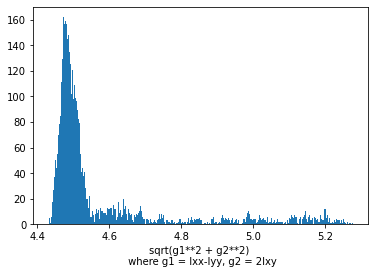

In [9]:
xx = []
yy = []
xy = []

for t in tab:
    cond = (t['amps'] == "C14")
    xx.extend(t['base_SdssShape_xx'][cond])
    yy.extend(t['base_SdssShape_yy'][cond])
    xy.extend(t['base_SdssShape_xy'][cond])

xx = np.asarray(xx)
yy = np.asarray(yy)
xy = np.asarray(xy)
g1 = xx-yy
g2 = 2*xy

h = plt.hist(xx, bins=300)
plt.xlabel("sqrt(g1**2 + g2**2) \n where g1 = Ixx-Iyy, g2 = 2Ixy")


Text(0.5, 0, 'sqrt(g1**2 + g2**2) \n where g1 = Ixx-Iyy, g2 = 2Ixy')

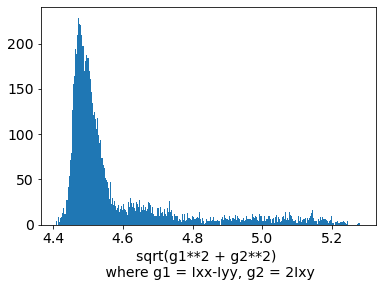

In [31]:
xx = []
yy = []
xy = []

for t in tab:
    cond = (t['amps'] == "C16")
    xx.extend(t['base_SdssShape_xx'][cond])
    yy.extend(t['base_SdssShape_yy'][cond])
    xy.extend(t['base_SdssShape_xy'][cond])

xx = np.asarray(xx)
yy = np.asarray(yy)
xy = np.asarray(xy)
g1 = xx-yy
g2 = 2*xy

h = plt.hist(xx, bins=300)
plt.xlabel("sqrt(g1**2 + g2**2) \n where g1 = Ixx-Iyy, g2 = 2Ixy")


Text(0.5, 0, 'sqrt(g1**2 + g2**2) \n where g1 = Ixx-Iyy, g2 = 2Ixy')

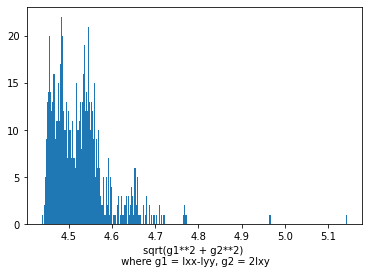

In [8]:
xx = []
yy = []
xy = []

for t in tab:
    cond = (t['amps'] == "C17")
    xx.extend(t['base_SdssShape_xx'][cond])
    yy.extend(t['base_SdssShape_yy'][cond])
    xy.extend(t['base_SdssShape_xy'][cond])

xx = np.asarray(xx)
yy = np.asarray(yy)
xy = np.asarray(xy)
g1 = xx-yy
g2 = 2*xy

h = plt.hist(xx, bins=300)
plt.xlabel("sqrt(g1**2 + g2**2) \n where g1 = Ixx-Iyy, g2 = 2Ixy")


[0.0, 162984.0, 3.5, 6.0]


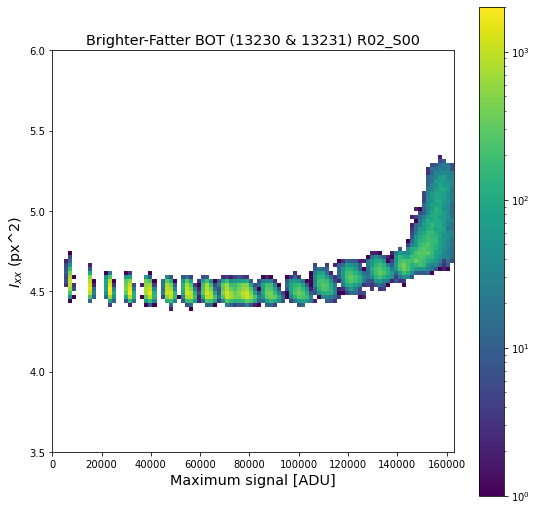

In [10]:
fig, ax = plt.subplots(1,1, figsize=(9,9), facecolor="w")
ax.set_title("Brighter-Fatter BOT (13230 & 13231) R02_S00", fontsize='x-large')

from matplotlib.colors import LogNorm
BINS=100
x = []
y = []
spot_x = []
spot_y = []
indexes = []
exps = []

for t in tab:
    x.extend(t['maxADC'])
    y.extend(t['base_SdssShape_xx'])
    spot_x.extend(t['spotgrid_x'])
    spot_y.extend(t['spotgrid_y'])
    exps.extend(t['exptime'] for i in range(len(t['maxADC'])))
    indexes.extend(t['index'] for i in range(len(t['maxADC'])))
    
heatmap, xedges, yedges = np.histogram2d(x, y, bins=BINS, range=[[0,162984],[3.5,6.0]])

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
print(extent)

x = np.array(x)
y = np.array(y)
spot_x = np.array(spot_x)
spot_y = np.array(spot_y)
indexes = np.array(indexes)
exps = np.array(exps)


im = ax.imshow(heatmap.T, extent=extent, origin='lower', cmap='viridis', norm=LogNorm())
ax.set_aspect((extent[1]-extent[0])/(extent[3]-extent[2]))
ax.set_xlabel("Maximum signal [ADU]", fontsize='x-large')
ax.set_ylabel("$I_{xx}$ (px^2)", fontsize='x-large')
ax.set_facecolor('white')
plt.colorbar(im)

In [10]:
plt.figure(figsize=(10,10))
col = 'u/abrought/run_13230/R02_S00/uncorrected'

    
subbutler = Butler(repo_path,collections=col)
subregistry = subbutler.registry

datasetRefs = list(subregistry.queryDatasets(
    datasetType="gridSpotSrc",
    collections=col))

x = []
y = []
count = 0
for i, aref in enumerate(datasetRefs):
    count = count + 1
    """if not count == 484:
        continue"""
    
    raw = subbutler.get("raw",dataId=aref.dataId)
    md = raw.getMetadata()
    exptime = md["EXPTIME"]
    
    src = subbutler.get("gridSpotSrc",dataId=aref.dataId)
    mdsrc = src.getMetadata()
    print(mdsrc)
    
    if exptime > 1.25:
        print(exptime, " continuing...")
        continue
    else:
        print(exptime)
        
    postisr = subbutler.get("postISRCCD",dataId=aref.dataId)
    image = postisr.getImage().getArray()
    src = subbutler.get("gridSpotSrc",dataId=aref.dataId)
    mdsrc = src.getMetadata()
    print(mdsrc)
    bad = (np.array(src['base_SdssShape_xx']) > 4.7)

    num = 0
    buf = 15
    
    x = int(src['spotgrid_x'][bad][num])
    y = int(src['spotgrid_y'][bad][num])
    print("(x,y) = " ,x,y)


    from scipy.ndimage import gaussian_filter
    #image[image < 1.0] = 1.0
    plt.imshow(image[y-buf:y+buf,x-buf:x+buf], cmap="plasma")
    #plt.scatter(x,y,marker='x', c='blue',s=1)
    #plt.xlim(0,4000)
    #plt.ylim(0,4000)
    plt.colorbar()
    plt.tight_layout()
    plt.show()





KeyboardInterrupt: 

<Figure size 720x720 with 0 Axes>

## Main Plot

In [8]:
import pandas as pd

# get ptc & cti turnoffs
sensorparams = pkl.load( open("dfmerge_13144.pkl", "rb") )

ptc_turnoffs = sensorparams[(sensorparams["BAY_SLOT"] == "R02_S00")]["PTC_TURNOFF"] * sensorparams[(sensorparams["BAY_SLOT"] == "R02_S00")]["PTC_GAIN"]
cti_turnoffs = sensorparams[(sensorparams["BAY_SLOT"] == "R02_S00")]["CTI_TURNOFF"] * sensorparams[(sensorparams["BAY_SLOT"] == "R02_S00")]["PTC_GAIN"]

# get maximum observed signal
eotest_results_path = "/sdf/group/lsst/camera/IandT/jobHarness/jh_archive/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/13162/raft_results_summary_BOT/v0/107240/"
h=fits.open(eotest_results_path + "R02_S00_13162_eotest_results.fits")
mos =h[1].data["MAX_OBSERVED_SIGNAL"] * sensorparams[(sensorparams["BAY_SLOT"] == "R02_S00")]["PTC_GAIN"]
h.close()



In [9]:
from astropy.stats import mad_std

class Aggregated:
    pass
    
table = tab
exptimes = np.unique(tab['exptime'])
#ref = tab_corr[np.where(tab_corr['exptime'] == 6.0)][0]

y1key="base_SdssShape_xx"
y2key="base_SdssShape_yy"
xkey="maxADC"
#xkey = "base_PsfFlux_instFlux"
#xkey="base_CircularApertureFlux_25_0_instFlux"
#xkey="base_CircularApertureFlux_70_0_instFlux"
#zskey="base_CircularApertureFlux_3_0_instFlux"

fontsize=14
T0s = []

# Find all spots common to all images
from functools import reduce
spots_to_track = reduce(np.intersect1d, tuple(i['spot_indices'] for i in table))


x = []
y = []
IxxErrs = []
IyyErrs = []
IxyErrs = []
ixx = []
iyy = []
zl = []
zs = []
e = []
exps = []
amps = []
for iterable in table:
    index = np.argwhere(exptimes==iterable['exptime'])[0][0]

    x.extend(iterable[xkey])
    Y1=iterable[y1key]
    Y2=iterable[y2key]
    amps.extend(iterable["amps"])
    y.extend( Y1 )
    IxxErrs.extend(iterable["base_SdssShape_xxErr"])
    IyyErrs.extend(iterable["base_SdssShape_yyErr"])
    IxyErrs.extend(iterable["base_SdssShape_xyErr"])
    ixx.extend(iterable["base_SdssShape_xx"])
    iyy.extend(iterable["base_SdssShape_yy"])
    
    e.extend([iterable['exptime']]*len(Y1))

x=np.array(x)
y=np.array(y)
IxxErrs = np.array(IxxErrs)
IyyErrs = np.array(IyyErrs)
IxyErrs = np.array(IxyErrs)
ixx = np.array(ixx)
iyy = np.array(iyy)
e = np.array(e)
amps = np.array(amps)
#print(e[0], y[np.where((e==e[0])&(y!=0))].std())

n = len(set(e))-1


# Plot

fig = plt.figure(figsize=(11,10), facecolor='w')
ax = plt.subplot(111)

# Plot the min and max ptc turnoffs for this sensor
ax.axvspan(np.min(ptc_turnoffs), np.max(ptc_turnoffs), alpha=0.35, color='red', label = "PTC_TURNOFF (13144)")
ax.axvspan(np.min(cti_turnoffs), np.max(cti_turnoffs), alpha=0.35, color='#1aa260', label = "CTI_TURNOFF (13144)")
ax.axvspan(np.min(mos), np.max(mos), alpha=0.35, color='#4285F4', label = "MAX_OBSERVED_SIGNAL (13162)")

array_aggregated = []

xs_stderrs = []
ys = []
es = []
stderrs_lowestexp = []
errofstderr_lowestexp = []
xxErrs = []
yyErrs = []
xyErrs = []
ixxs = []
iyys = []
properrs = []

fitx = []
fity = []


for j, i in enumerate(exptimes):
    
    import matplotlib
    normalize = matplotlib.colors.Normalize(vmin=1.25, vmax=40)

    cond = np.argwhere((e==i)&(y!=0))
    sca=ax.scatter(x[cond],y[cond],c=e[cond], cmap='turbo', norm=normalize, s=15, alpha=0.2)
    
    num = len(x[cond])
    from astropy.stats import bootstrap
    #errofstderr_lowestexp.append(bootstrap(y[cond], bootnum=100, bootfunc=np.std))
    
    aggregated = Aggregated()
    aggregated.e = np.mean(i)   
    aggregated.x = np.mean(x[cond])
    aggregated.y = np.mean(y[cond])
    aggregated.xerr = np.std(x[cond])
    aggregated.yerr = np.std(y[cond])
    
    xxErrs.append(np.median(IxxErrs[cond]))
    yyErrs.append(np.median(IyyErrs[cond]))
    xyErrs.append(np.median(IxyErrs[cond]))
    ixxs.append(np.median(ixx[cond]))
    iyys.append(np.median(iyy[cond]))

    
    stderrs_lowestexp.append(aggregated.yerr)
    xs_stderrs.append(aggregated.x)
    aggregated.num = num
    aggregated.color = plt.get_cmap('turbo')((j)/n)
    array_aggregated.append(aggregated)
    
    if i <= 16. and i > 6:
        fitx.append(aggregated.x)
        fity.append(aggregated.y)
        
    for spec in [1]:
        sca3=ax.errorbar(aggregated.x,aggregated.y*spec,
                        xerr=aggregated.xerr,
                        yerr=aggregated.yerr,
                        fmt="o",color=aggregated.color,mec="r",ecolor="r",alpha=1,
                        ms=10,mew=5)

    


ax.set_ylabel("{}".format("$I_{xx}$ (corrected) $[px^{2}]$"),fontsize=15)
ax.set_xlabel("Peak Signal [e-]", fontsize=15, y=-10)
ax.set_xlim(0,200000)
#ax.set_ylim(4.5,6.0)
ax.set_ylim(4.,6.0)
#ax.set_ylim(.05,.45)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.rcParams.update({'font.size': fontsize})

ax.grid(alpha=0.75)
print(fitx)
m, b  = np.polyfit(fitx, fity, 1)
slope = m*100*1000
plt.text(10000.,5.26,"{}".format(r"Slope $I_{xx}$ (corrected) = ") + "\n" + str(round(slope,4)) +"% per 10k e-", fontsize=16)

ax.plot(np.linspace(0,5.5e6, 1000), m*np.linspace(0,5.5e6, 1000) + b, color="red" , linestyle="--")
x1 = np.linspace(0,5.5e6, 1000)
y1 = m*np.linspace(0,5.5e6, 1000) + b



#for ch in [90595.07, 118279.234] :
#        ax.axvline(ch, c="k", ls="-", alpha=0.75, label="Low/High Max obs. signal")
plt.legend(loc=2)
        
#plt.colorbar(scb,label="EXPTIME",orientation="horizontal",location="bottom")

cbar_ax = fig.add_axes([0.935, 0.15, 0.03, 0.7])
cb = plt.colorbar(sca,cax=cbar_ax, ticks=[1.25,2.5,3.75,5.0,6.25,7.5,8.75,10.0,11.25,12.0,12.5,14.0,16.0,18.0,20.0,22.0,24.0,26.0,28.0,30.0,32.0,34.0,36.0,38.0,40.0])


sca.set_clim(1.25,40)
cb.set_label("Exposure time [s]", labelpad=10)
#uncorrslope = slope
plt.subplots_adjust(right=0.90,hspace=0)
ax.set_title("R02-S00 (Runs 13230 & 13231) ")
#plt.savefig("./Ixx-uncorrected-9raft-R22S11-integratedflux.png", bbox_inches='tight')

NameError: name 'tab' is not defined

## BF rel.to flux

Text(0.5, 1.0, 'R02-S00 (Runs 13230 & 13231)')

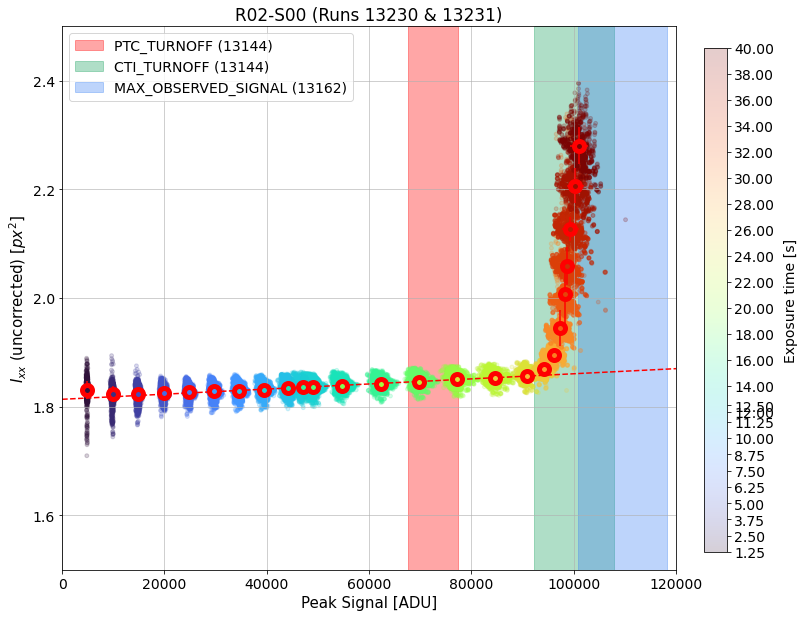

In [17]:
# (I70/ Ipsf) / (I70/ Ipsf) 0 - 1

from astropy.stats import mad_std

class Aggregated:
    pass
    
table = tab
exptimes = np.unique(tab['exptime'])
#ref = tab_corr[np.where(tab_corr['exptime'] == 6.0)][0]

y1key="base_SdssShape_xx"
y2key="base_SdssShape_yy"
xkey="maxADC"
#xkey = "base_PsfFlux_instFlux"
#xkey="base_CircularApertureFlux_25_0_instFlux"
#xkey="base_CircularApertureFlux_70_0_instFlux"
#zskey="base_CircularApertureFlux_3_0_instFlux"

fontsize=14
T0s = []

# Find all spots common to all images
from functools import reduce
spots_to_track = reduce(np.intersect1d, tuple(i['spot_indices'] for i in table))


x = []
y = []
IxxErrs = []
IyyErrs = []
IxyErrs = []
ixx = []
iyy = []
zl = []
zs = []
e = []
exps = []
for iterable in table:
    index = np.argwhere(exptimes==iterable['exptime'])[0][0]

    x.extend(iterable[xkey])
    Y1=iterable[y1key]
    Y2=iterable[y2key]
    y.extend( iterable["base_CircularApertureFlux_25_0_instFlux"] /  iterable["base_PsfFlux_instFlux"])
    IxxErrs.extend(iterable["base_SdssShape_xxErr"])
    IyyErrs.extend(iterable["base_SdssShape_yyErr"])
    IxyErrs.extend(iterable["base_SdssShape_xyErr"])
    ixx.extend(iterable["base_SdssShape_xx"])
    iyy.extend(iterable["base_SdssShape_yy"])
    
    e.extend([iterable['exptime']]*len(Y1))

x=np.array(x)
y=np.array(y)
IxxErrs = np.array(IxxErrs)
IyyErrs = np.array(IyyErrs)
IxyErrs = np.array(IxyErrs)
ixx = np.array(ixx)
iyy = np.array(iyy)
e = np.array(e)
#print(e[0], y[np.where((e==e[0])&(y!=0))].std())


n = len(set(e))-1


# Plot

fig = plt.figure(figsize=(11,10), facecolor='w')
ax = plt.subplot(111)

# Plot the min and max ptc turnoffs for this sensor
ax.axvspan(ptc_turnoff_min, ptc_turnoff_max, alpha=0.35, color='red', label = "PTC_TURNOFF (13144)")
ax.axvspan(cti_turnoff_min, cti_turnoff_max, alpha=0.35, color='#1aa260', label = "CTI_TURNOFF (13144)")
ax.axvspan(mos_min, mos_max, alpha=0.35, color='#4285F4', label = "MAX_OBSERVED_SIGNAL (13162)")

array_aggregated = []

xs_stderrs = []
ys = []
es = []
stderrs_lowestexp = []
errofstderr_lowestexp = []
xxErrs = []
yyErrs = []
xyErrs = []
ixxs = []
iyys = []
properrs = []

fitx = []
fity = []

for j, i in enumerate(exptimes):
    
    import matplotlib
    normalize = matplotlib.colors.Normalize(vmin=1.25, vmax=40)

    cond = np.argwhere((e==i)&(y!=0))
    sca=ax.scatter(x[cond],y[cond],c=e[cond], cmap='turbo', norm=normalize, s=15, alpha=0.2)
    
    num = len(x[cond])
    from astropy.stats import bootstrap
    errofstderr_lowestexp.append(bootstrap(y[cond], bootnum=100, bootfunc=np.std))
    
    aggregated = Aggregated()
    aggregated.e = np.mean(i)   
    aggregated.x = np.mean(x[cond])
    aggregated.y = np.mean(y[cond])
    aggregated.xerr = np.std(x[cond])
    aggregated.yerr = np.std(y[cond])
    
    xxErrs.append(np.median(IxxErrs[cond]))
    yyErrs.append(np.median(IyyErrs[cond]))
    xyErrs.append(np.median(IxyErrs[cond]))
    ixxs.append(np.median(ixx[cond]))
    iyys.append(np.median(iyy[cond]))

    
    stderrs_lowestexp.append(aggregated.yerr)
    xs_stderrs.append(aggregated.x)
    aggregated.num = num
    aggregated.color = plt.get_cmap('turbo')((j)/n)
    array_aggregated.append(aggregated)
    
    if i <= 24. and i > 6:
        fitx.append(aggregated.x)
        fity.append(aggregated.y)
        
    for spec in [1]:
        sca3=ax.errorbar(aggregated.x,aggregated.y*spec,
                        xerr=aggregated.xerr,
                        yerr=aggregated.yerr,
                        fmt="o",color=aggregated.color,mec="r",ecolor="r",alpha=1,
                        ms=10,mew=5)

    


ax.set_ylabel("{}".format("$I_{xx}$ (uncorrected) $[px^{2}]$"),fontsize=15)
ax.set_xlabel("Peak Signal [ADU]", fontsize=15, y=-10)
ax.set_xlim(0,120000)
#ax.set_ylim(4.8,5.3)
#ax.set_ylim(4.5,5.0)
#ax.set_ylim(4.25,5.5)
ax.set_ylim(1.5,2.5)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.rcParams.update({'font.size': fontsize})

ax.grid(alpha=0.75)

m, b  = np.polyfit(fitx, fity, 1)
slope = m*100*1000
#plt.text(10000.,5.1,"{}".format(r"Slope $I_{xx}$ (uncorrected) = ") + "\n" + str(round(slope,4)) +"% per 10k ADU", fontsize=16)

ax.plot(np.linspace(0,5.5e6, 1000), m*np.linspace(0,5.5e6, 1000) + b, color="red" , linestyle="--")
x1 = np.linspace(0,5.5e6, 1000)
y1 = m*np.linspace(0,5.5e6, 1000) + b



#for ch in [90595.07, 118279.234] :
#        ax.axvline(ch, c="k", ls="-", alpha=0.75, label="Low/High Max obs. signal")
plt.legend(loc=2)
        
#plt.colorbar(scb,label="EXPTIME",orientation="horizontal",location="bottom")

cbar_ax = fig.add_axes([0.935, 0.15, 0.03, 0.7])
cb = plt.colorbar(sca,cax=cbar_ax, ticks=[1.25,2.5,3.75,5.0,6.25,7.5,8.75,10.0,11.25,12.0,12.5,14.0,16.0,18.0,20.0,22.0,24.0,26.0,28.0,30.0,32.0,34.0,36.0,38.0,40.0])


sca.set_clim(1.25,40)
cb.set_label("Exposure time [s]", labelpad=10)
uncorrslope = slope
plt.subplots_adjust(right=0.90,hspace=0)
ax.set_title("R02-S00 (Runs 13230 & 13231)")
#plt.savefig("./Ixx-uncorrected-9raft-R22S11-integratedflux.png", bbox_inches='tight')

## BF Plot by Amplifier

Text(0.5, 1.0, 'R02-S00 (Runs 13230 & 13231)')

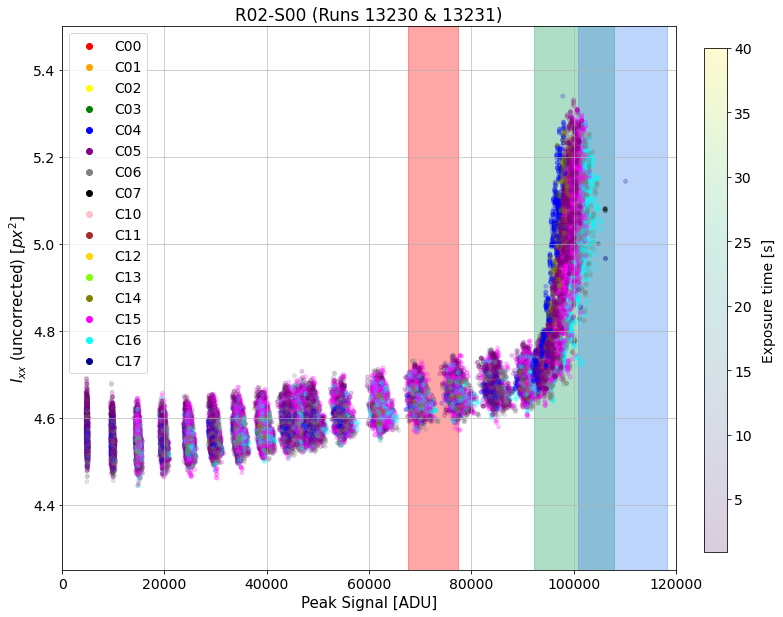

In [13]:
from astropy.stats import mad_std

class Aggregated:
    pass
    
table = tab
exptimes = np.unique(tab['exptime'])
#ref = tab_corr[np.where(tab_corr['exptime'] == 6.0)][0]

y1key="base_SdssShape_xx"
y2key="base_SdssShape_yy"
xkey="maxADC"
#xkey = "base_PsfFlux_instFlux"
#xkey="base_CircularApertureFlux_25_0_instFlux"
#xkey="base_CircularApertureFlux_70_0_instFlux"
#zskey="base_CircularApertureFlux_3_0_instFlux"

fontsize=14
T0s = []

# Find all spots common to all images
from functools import reduce
spots_to_track = reduce(np.intersect1d, tuple(i['spot_indices'] for i in table))


x = []
y = []
IxxErrs = []
IyyErrs = []
IxyErrs = []
ixx = []
iyy = []
zl = []
zs = []
e = []
exps = []
amps = []
for iterable in table:
    index = np.argwhere(exptimes==iterable['exptime'])[0][0]

    x.extend(iterable[xkey])
    Y1=iterable[y1key]
    Y2=iterable[y2key]
    y.extend( Y1 )
    IxxErrs.extend(iterable["base_SdssShape_xxErr"])
    IyyErrs.extend(iterable["base_SdssShape_yyErr"])
    IxyErrs.extend(iterable["base_SdssShape_xyErr"])
    ixx.extend(iterable["base_SdssShape_xx"])
    iyy.extend(iterable["base_SdssShape_yy"])
    amps.extend(iterable["amps"])
    e.extend([iterable['exptime']]*len(Y1))

x=np.array(x)
y=np.array(y)
IxxErrs = np.array(IxxErrs)
IyyErrs = np.array(IyyErrs)
IxyErrs = np.array(IxyErrs)
ixx = np.array(ixx)
iyy = np.array(iyy)
e = np.array(e)
amps = np.array(amps)
#print(e[0], y[np.where((e==e[0])&(y!=0))].std())


n = len(set(e))-1


# Plot

fig = plt.figure(figsize=(11,10), facecolor='w')
ax = plt.subplot(111)

# Plot the min and max ptc turnoffs for this sensor
ptc = ax.axvspan(ptc_turnoff_min, ptc_turnoff_max, alpha=0.35, color='red', label = "PTC_TURNOFF (13144)")
cti = ax.axvspan(cti_turnoff_min, cti_turnoff_max, alpha=0.35, color='#1aa260', label = "CTI_TURNOFF (13144)")
mos = ax.axvspan(mos_min, mos_max, alpha=0.35, color='#4285F4', label = "MAX_OBSERVED_SIGNAL (13162)")
color_dict = { 'C00':'red', 'C01':'orange', 'C02':'yellow', 
                   'C03':'green','C04':'blue', 'C05':'purple', 
                   'C06':'grey', 'C07':'black', 'C10':'pink', 
                   'C11':'brown', 'C12':'gold', 'C13':'chartreuse',
                   'C14':'olive', 'C15':'magenta', 'C16':'cyan', 
                   'C17':'navy'}

# The following two lines generate custom fake lines that will be used as legend entries:
markers = [ax.scatter([0,0],[0,0],color=color, marker='o') for color in color_dict.values()]

array_aggregated = []

xs_stderrs = []
ys = []
es = []
stderrs_lowestexp = []
errofstderr_lowestexp = []
xxErrs = []
yyErrs = []
xyErrs = []
ixxs = []
iyys = []
properrs = []

fitx = []
fity = []

for j, i in enumerate(exptimes):
    
    import matplotlib
    normalize = matplotlib.colors.Normalize(vmin=1.25, vmax=40)
    
    cond = np.argwhere((e==i)&(y!=0))
    colors = []
    for ch in amps[cond]:
        colors.append(color_dict[str(ch[0])])
    sca=ax.scatter(x[cond],y[cond],c=colors, cmap='turbo', norm=normalize, s=15, alpha=0.2)
    
    num = len(x[cond])
    from astropy.stats import bootstrap
    #errofstderr_lowestexp.append(bootstrap(y[cond], bootnum=100, bootfunc=np.std))
    
    aggregated = Aggregated()
    aggregated.e = np.mean(i)   
    aggregated.x = np.mean(x[cond])
    aggregated.y = np.mean(y[cond])
    aggregated.xerr = np.std(x[cond])
    aggregated.yerr = np.std(y[cond])
    
    xxErrs.append(np.median(IxxErrs[cond]))
    yyErrs.append(np.median(IyyErrs[cond]))
    xyErrs.append(np.median(IxyErrs[cond]))
    ixxs.append(np.median(ixx[cond]))
    iyys.append(np.median(iyy[cond]))

    
    stderrs_lowestexp.append(aggregated.yerr)
    xs_stderrs.append(aggregated.x)
    aggregated.num = num
    aggregated.color = plt.get_cmap('turbo')((j)/n)
    array_aggregated.append(aggregated)
    
    if i <= 24. and i > 6:
        fitx.append(aggregated.x)
        fity.append(aggregated.y)
        

    


ax.set_ylabel("{}".format("$I_{xx}$ (uncorrected) $[px^{2}]$"),fontsize=15)
ax.set_xlabel("Peak Signal [ADU]", fontsize=15, y=-10)
ax.set_xlim(0,120000)
#ax.set_ylim(4.8,5.3)
#ax.set_ylim(4.5,5.0)
ax.set_ylim(4.25,5.5)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.rcParams.update({'font.size': fontsize})

ax.grid(alpha=0.75)




#for ch in [90595.07, 118279.234] :
#        ax.axvline(ch, c="k", ls="-", alpha=0.75, label="Low/High Max obs. signal")
plt.legend(markers, color_dict.keys(), loc=2)

        
#plt.colorbar(scb,label="EXPTIME",orientation="horizontal",location="bottom")

cbar_ax = fig.add_axes([0.935, 0.15, 0.03, 0.7])
cb = plt.colorbar(sca,cax=cbar_ax)#, ticks=[1.25,2.5,3.75,5.0,6.25,7.5,8.75,10.0,11.25,12.0,12.5,14.0,16.0,18.0,20.0,22.0,24.0,26.0,28.0,30.0,32.0,34.0,36.0,38.0,40.0])


sca.set_clim(1.25,40)
cb.set_label("Exposure time [s]", labelpad=10)
uncorrslope = slope
plt.subplots_adjust(right=0.90,hspace=0)
ax.set_title("R02-S00 (Runs 13230 & 13231)")
#plt.savefig("./Ixx-uncorrected-9raft-R22S11-integratedflux.png", bbox_inches='tight')

<ipython-input-15-307d9620a811>:51: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot("111")


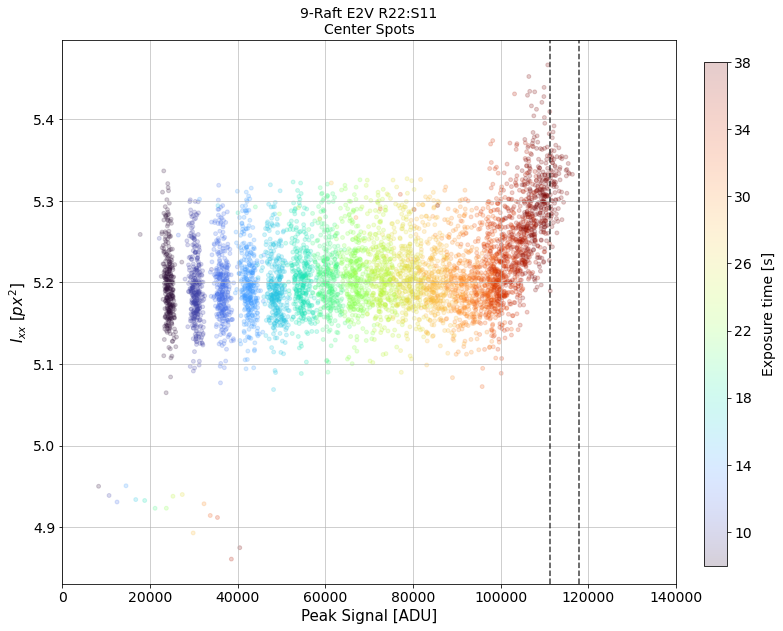

In [15]:
table = tab_corr
ref = tab_corr[np.where(tab_corr['exptime'] == 6.0)][0]

y1key="base_SdssShape_xx"#"a"
y2key="base_SdssShape_xy"#"b"
xkey="maxADC"
#xkey="base_CircularApertureFlux_70_0_instFlux"
#zskey="base_CircularApertureFlux_3_0_instFlux"
zskey="base_PsfFlux_instFlux"
zlkey="base_CircularApertureFlux_70_0_instFlux"

fontsize=14

x = []
y = []
y2 = []
zl = []
zs = []
e = []

for iterable in table:
    if iterable['exptime'] == 6.0:
        continue
    spots, iter_ind, ref_ind = np.intersect1d(iterable['spot_indices'], ref['spot_indices'], return_indices=True)
    x.extend(iterable[xkey][iter_ind])
    Y1=iterable[y1key][iter_ind]
    Y2=iterable[y2key][iter_ind]
    Y0_1=ref[y1key][ref_ind]
    Y0_2=ref[y2key][ref_ind] 
    
    zl.extend(iterable[zlkey][iter_ind]/ref[zlkey][ref_ind])
    zs.extend(iterable[zskey][iter_ind]/ref[zskey][ref_ind])
    y.extend( Y1)#-(Y0_1+Y0_2) )
    y2.extend(Y2)
    #e.extend((Y1+Y2))
    e.extend([iterable['exptime']]*len(Y1))

x=np.array(x)
y=np.array(y)
y2 = np.array(y2)
zl=np.array(zl)
zs=np.array(zs)
e = np.array(e)



# Plot

fig = plt.figure(figsize=(11,10), facecolor='w')
plt.title("9-Raft E2V R22:S11\nCenter Spots", fontsize=fontsize)
ax = plt.subplot("111")
sca=ax.scatter(x,y,c=e,s=15,cmap='turbo',alpha=0.2)
#ax.scatter(x2,y2,c="r", s=15)

"""for i in range(len(e2)):
    if (x2[i] >= 1e5) and (x2[i] <= 1e7) and (np.abs(y2[i]) <= 0.4):
        ax.text(x2[i],y2[i]+0.0075,str(e2[i]), c="red")"""
ax.set_ylabel("{}".format("$I_{xx}$ $[px^{2}]$"),fontsize=15)
ax.set_xlabel("Peak Signal [ADU]", fontsize=15, y=-10)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.rcParams.update({'font.size': fontsize})

#ax.set_xscale("log")
ax.set_xlim(0,140000)
#ax.set_ylim(10.,13.)
#ax.set_ylim(-.5,.5)
ax.grid(alpha=0.75)

# Plot the min and max ptc turnoffs for this sensor
#    from: https://github.com/lsst/obs_lsst/blob/master/policy/lsstCam/R10.yaml
for ch in [111273, 117803] :
    ax.axvline(ch, c="k", ls="--", alpha=0.75)
#plt.colorbar(scb,label="EXPTIME",orientation="horizontal",location="bottom")
cbar_ax = fig.add_axes([0.935, 0.15, 0.03, 0.7])
cb = plt.colorbar(sca,cax=cbar_ax, ticks=[6,10,14,18,22,26,30,34,38])
cb.set_label("Exposure time [s]", labelpad=10)

plt.subplots_adjust(right=0.90,hspace=0)



(array([[ 0.,  0.,  0., ..., 13.,  1.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  1., 15.,  1.],
        [ 0.,  0.,  0., ...,  7., 10.,  0.],
        [ 0.,  0.,  0., ...,  1., 14.,  2.]]),
 array([-0.3157384, -0.2940686, -0.2723988, -0.250729 , -0.2290592,
        -0.2073894, -0.1857196, -0.1640498, -0.14238  , -0.1207102,
        -0.0990404]),
 <a list of 311 BarContainer objects>)

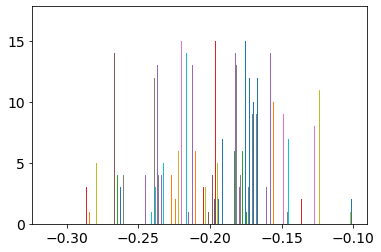

In [19]:
plt.hist(tab_corr["base_SdssShape_xy"])

<ipython-input-4-092b7186351b>:52: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot("111")


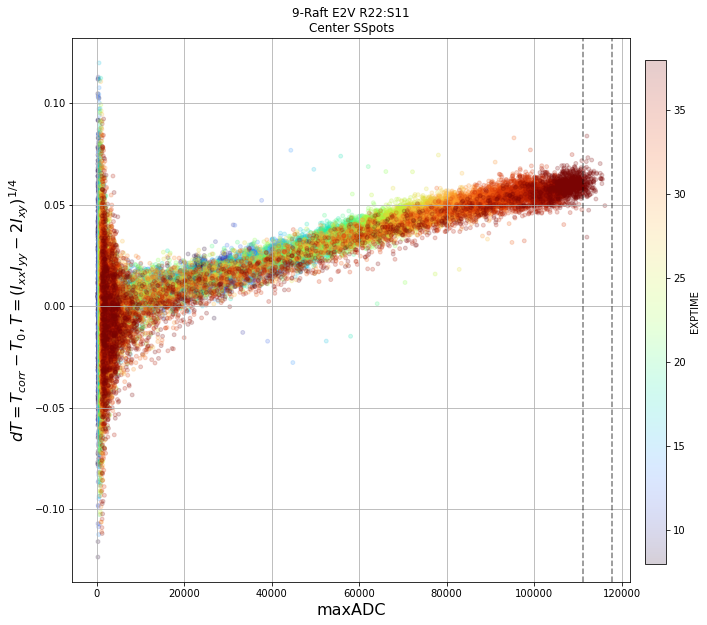

In [4]:
table = tab_uncorr
ref = tab_corr[np.where(tab_corr['exptime'] == 6.0)][0]

y1key="base_SdssShape_xx"#"a"
y2key="base_SdssShape_yy"#"b"
y3key="base_SdssShape_xy"
xkey="maxADC"
#xkey="base_CircularApertureFlux_70_0_instFlux"
#zskey="base_CircularApertureFlux_3_0_instFlux"
zskey="base_PsfFlux_instFlux"
zlkey="base_CircularApertureFlux_70_0_instFlux"

fontsize=16

x = []
y = []
zl = []
zs = []
e = []

for iterable in table:
    if iterable['exptime'] == 6.0:
        continue
    spots, iter_ind, ref_ind = np.intersect1d(iterable['spot_indices'], ref['spot_indices'], return_indices=True)
    x.extend(iterable[xkey][iter_ind])
    Y1=iterable[y1key][iter_ind]
    Y2=iterable[y2key][iter_ind]
    Y3=iterable[y3key][iter_ind]
    Y0_1=ref[y1key][ref_ind]
    Y0_2=ref[y2key][ref_ind] 
    Y0_3=ref[y3key][ref_ind]
    
    zl.extend(iterable[zlkey][iter_ind]/ref[zlkey][ref_ind])
    zs.extend(iterable[zskey][iter_ind]/ref[zskey][ref_ind])
    y.extend( (Y1*Y2-2*Y3)**(1./4.) - (Y0_1*Y0_2-2*Y0_3)**(1./4.))
    #y.extend( (Y1+Y2))#-(Y0_1+Y0_2) )
    #e.extend((Y1+Y2))
    e.extend([iterable['exptime']]*len(Y1))

x=np.array(x)
y=np.array(y)
zl=np.array(zl)
zs=np.array(zs)
e = np.array(e)



# Plot

fig = plt.figure(figsize=(10,10), facecolor='w')
plt.title("9-Raft E2V R22:S11\nCenter SSpots")
ax = plt.subplot("111")
sca=ax.scatter(x,y,c=e,s=15,cmap='turbo',alpha=0.2)
#ax.scatter(x2,y2,c="r", s=15)

"""for i in range(len(e2)):
    if (x2[i] >= 1e5) and (x2[i] <= 1e7) and (np.abs(y2[i]) <= 0.4):
        ax.text(x2[i],y2[i]+0.0075,str(e2[i]), c="red")"""
ax.set_ylabel("{}".format(r"$dT = T_{corr} - T_{0}, T =(I_{xx}I_{yy}-2I_{xy})^{1/4}$"),fontsize=fontsize)
ax.set_xlabel("maxADC", fontsize=fontsize)
#ax.set_xscale("log")
#ax.set_xlim(1e5,1e7)
#ax.set_ylim(10.,13.)
#ax.set_ylim(-.5,.5)
ax.grid()

# Plot the min and max ptc turnoffs for this sensor
#    from: https://github.com/lsst/obs_lsst/blob/master/policy/lsstCam/R10.yaml
for ch in [111273, 117803] :
    ax.axvline(ch, c="k", ls="--", alpha=0.5)
#plt.colorbar(scb,label="EXPTIME",orientation="horizontal",location="bottom")
cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
plt.colorbar(sca,cax=cbar_ax,label="EXPTIME")

plt.subplots_adjust(right=0.90,hspace=0)



<ipython-input-7-813e8c202b71>:60: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot("111")


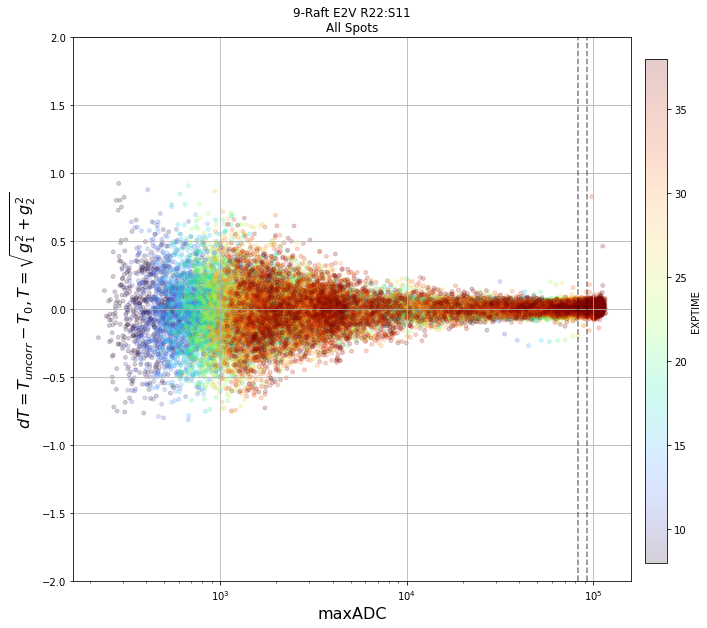

In [7]:
# sqrt(g1**2 + g2**2)  with g1=Ixx-Iyy and g2=2Ixy
table = tab_uncorr
ref = tab_corr[np.where(tab_corr['exptime'] == 6.0)][0]

y1key="base_SdssShape_xx"#"a"
y2key="base_SdssShape_yy"#"b"
y3key="base_SdssShape_xy"
xkey="maxADC"
#xkey="base_CircularApertureFlux_70_0_instFlux"
#zskey="base_CircularApertureFlux_3_0_instFlux"
zskey="base_PsfFlux_instFlux"
zlkey="base_CircularApertureFlux_70_0_instFlux"

fontsize=16

x = []
y = []
zl = []
zs = []
e = []

for iterable in table:
    if iterable['exptime'] == 6.0:
        continue
        
    spots, iter_ind, ref_ind = np.intersect1d(iterable['spot_indices'], ref['spot_indices'], return_indices=True)
    x.extend(iterable[xkey][iter_ind])
    Y1=iterable[y1key][iter_ind]
    Y2=iterable[y2key][iter_ind]
    Y3=iterable[y3key][iter_ind]
    Y0_1=ref[y1key][ref_ind]
    Y0_2=ref[y2key][ref_ind] 
    Y0_3=ref[y3key][ref_ind]
    
    zl.extend(iterable[zlkey][iter_ind]/ref[zlkey][ref_ind])
    zs.extend(iterable[zskey][iter_ind]/ref[zskey][ref_ind])
    
    g1 = Y1 - Y2
    g2 = 2. * Y3
    g0_1 = Y0_1 - Y0_2
    g0_2 = 2. * Y0_3
    
    y.extend( np.sqrt(g1**2. + g2**2.) - np.sqrt(g0_1**2. + g0_2**2.) )
    #y.extend( (Y1+Y2))#-(Y0_1+Y0_2) )
    #e.extend((Y1+Y2))
    e.extend([iterable['exptime']]*len(Y1))

x=np.array(x)
y=np.array(y)
zl=np.array(zl)
zs=np.array(zs)
e = np.array(e)



# Plot

fig = plt.figure(figsize=(10,10), facecolor='w')
plt.title("9-Raft E2V R22:S11\nCenter Spots")
ax = plt.subplot("111")
sca=ax.scatter(x,y,c=e,s=15,cmap='turbo',alpha=0.2)
#ax.scatter(x2,y2,c="r", s=15)

"""for i in range(len(e2)):
    if (x2[i] >= 1e5) and (x2[i] <= 1e7) and (np.abs(y2[i]) <= 0.4):
        ax.text(x2[i],y2[i]+0.0075,str(e2[i]), c="red")"""
ax.set_ylabel("{}".format(r"$dT = T_{uncorr} - T_{0}, T = \sqrt{g_{1}^2 + g_{2}^2}$"),fontsize=fontsize)

ax.set_xlabel("maxADC", fontsize=fontsize)
ax.set_xscale("log")
#ax.set_xlim(1e5,1e7)
ax.set_ylim(-2,2)
#ax.set_ylim(-.5,.5)
ax.grid()

# Plot the min and max ptc turnoffs for this sensor
#    from: https://github.com/lsst/obs_lsst/blob/master/policy/lsstCam/R10.yaml
for ch in [82733, 92824] :
    ax.axvline(ch, c="k", ls="--", alpha=0.5)
#plt.colorbar(scb,label="EXPTIME",orientation="horizontal",location="bottom")
cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
plt.colorbar(sca,cax=cbar_ax,label="EXPTIME")

plt.subplots_adjust(right=0.90,hspace=0)

<ipython-input-73-d048da4cee67>:44: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot("111")


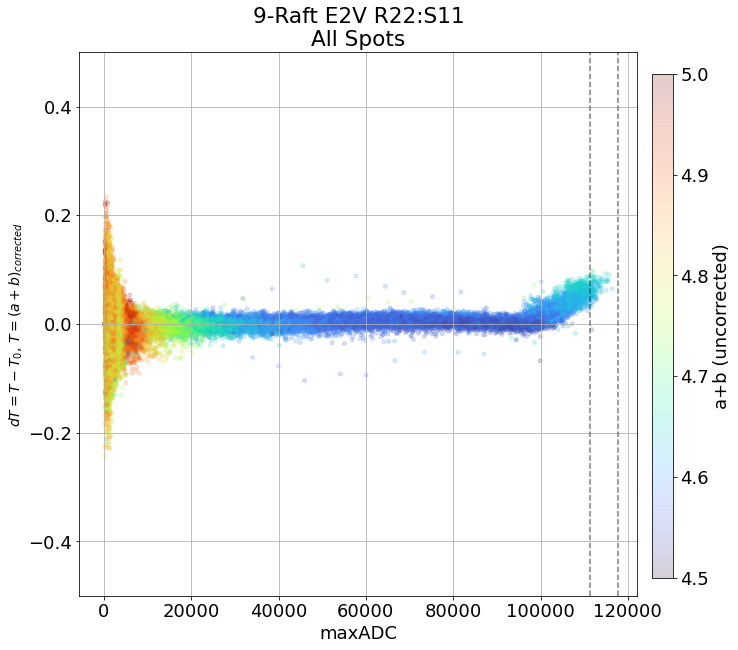

In [73]:
table = tab_corr
ref = tab_corr[np.where(tab_corr['exptime'] == 6.0)][0]

y1key="a"
y2key="b"
xkey="maxADC"
#xkey="base_CircularApertureFlux_70_0_instFlux"
#zskey="base_CircularApertureFlux_3_0_instFlux"
zskey="base_PsfFlux_instFlux"
zlkey="base_CircularApertureFlux_70_0_instFlux"

fontsize=14

x = []
y = []
zl = []
zs = []
e = []

for iterable in table:
    spots, iter_ind, ref_ind = np.intersect1d(iterable['spot_indices'], ref['spot_indices'], return_indices=True)
    x.extend(iterable[xkey][iter_ind])
    Y1=iterable[y1key][iter_ind]
    Y2=iterable[y2key][iter_ind]
    Y0_1=ref[y1key][ref_ind]
    Y0_2=ref[y2key][ref_ind] 
    
    zl.extend(iterable[zlkey][iter_ind]/ref[zlkey][ref_ind])
    zs.extend(iterable[zskey][iter_ind]/ref[zskey][ref_ind])
    y.extend( (Y1+Y2)-(Y0_1+Y0_2) )
    e.extend((Y1+Y2))

x=np.array(x)
y=np.array(y)
zl=np.array(zl)
zs=np.array(zs)



# Plot

fig = plt.figure(figsize=(10,10), facecolor='w')
plt.title("9-Raft E2V R22:S11\nCenter Spots")
ax = plt.subplot("111")
sca=ax.scatter(x,y,c=e,s=15,cmap='turbo',alpha=0.2, vmin=4.5, vmax=5.0)
#ax.scatter(x2,y2,c="r", s=15)

"""for i in range(len(e2)):
    if (x2[i] >= 1e5) and (x2[i] <= 1e7) and (np.abs(y2[i]) <= 0.4):
        ax.text(x2[i],y2[i]+0.0075,str(e2[i]), c="red")"""
ax.set_ylabel("{}".format(r"$dT=T-T_0$, $T = (a+b)_{corrected}$"),fontsize=fontsize)
ax.set_xlabel("maxADC")
#ax.set_xlim(1e5,1e7)
ax.set_ylim(-.5,.5)
ax.grid()

# Plot the min and max ptc turnoffs for this sensor
#    from: https://github.com/lsst/obs_lsst/blob/master/policy/lsstCam/R10.yaml
for ch in [111273, 117803] :
    ax.axvline(ch, c="k", ls="--", alpha=0.5)
#plt.colorbar(scb,label="EXPTIME",orientation="horizontal",location="bottom")
cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
plt.colorbar(sca,cax=cbar_ax,label="a+b (uncorrected)")

plt.subplots_adjust(right=0.90,hspace=0)



<ipython-input-74-f367a9e71809>:74: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot("111")


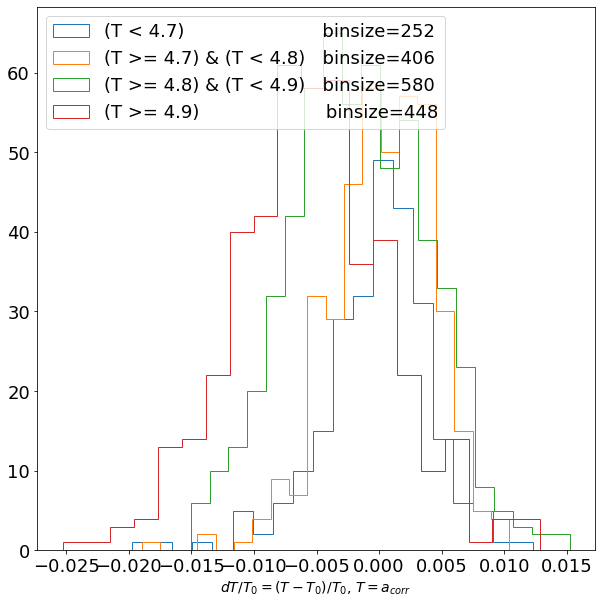

In [74]:
table = tab_corr
ref = tab_corr[np.where(tab_corr['exptime'] == 6.0)][0]
from math import log10, floor
y1key="a"
y2key="b"
xkey="maxADC"
#xkey = "base_CircularApertureFlux_3_0_instFlux"
#xkey="base_CircularApertureFlux_70_0_instFlux"
#zskey="base_CircularApertureFlux_3_0_instFlux"
zskey="base_PsfFlux_instFlux"
zlkey="base_CircularApertureFlux_70_0_instFlux"

fontsize=14

x = []
y = []
z = []
e = []

x2 = []
y2 = []
z2 = []
e2 = []
ixxiyy = []
apflux = []

for iterable in table:
    if iterable['exptime'] == 6:
        continue
    
    spots, iter_ind, ref_ind = np.intersect1d(iterable['spot_indices'], ref['spot_indices'], return_indices=True)
    x.extend(iterable[xkey][iter_ind])
    ixxiyy_tmp = iterable['base_SdssShape_xx'][iter_ind] + iterable['base_SdssShape_yy'][iter_ind]
    apflux_tmp = iterable["base_CircularApertureFlux_3_0_instFlux"][iter_ind]
    Y1=iterable[y1key][iter_ind]
    Y2=iterable[y2key][iter_ind]
    Y0_1=ref[y1key][ref_ind]
    Y0_2=ref[y2key][ref_ind] 
    
    z.extend((Y0_1+Y0_2))
    y.extend( ((Y1)-(Y0_1)) / (Y0_1))
    e.extend((Y1+Y2))
    ixxiyy.extend(ixxiyy_tmp)
    apflux.extend(apflux_tmp)
    
    x2.extend(iterable[xkey][iter_ind])
    Y1=iterable[y1key][iter_ind]
    Y2=iterable[y2key][iter_ind]
    Y0_1=ref[y1key][ref_ind]
    Y0_2=ref[y2key][ref_ind] 
    
    z2.extend((Y0_1+Y0_2))
    y2.extend( ((Y2)-(Y0_2)) / (Y0_2))
    e2.extend((Y1+Y2))

x=np.array(x)
y=np.array(y)
z=np.array(z)
e=np.array(e)
apflux = np.array(apflux)

x2=np.array(x2)
y2=np.array(y2)
z2=np.array(z2)
e2=np.array(e2)
ixxiyy = np.array(ixxiyy)

def round_sig(x, sig=3):
    return round(x, sig-int(floor(log10(abs(x))))-1)

# Plot

fig = plt.figure(figsize=(10,10), facecolor='w')
ax = plt.subplot("111")
cond = (x>=5000) & (x<=10000)
bin1 = (z < 4.7)
bin2 = (z >= 4.7) & (z < 4.8)
bin3 = (z >= 4.8) & (z < 4.9)
bin4 = (z >= 4.9)
binsizes = [str(len(z[cond & bin1])), str(len(z[cond & bin2])), str(len(z[cond & bin3])), str(len(z[cond & bin4]))]
ax.hist(y[cond & bin1], bins=20, histtype='step', label="(T < 4.7)                        binsize=" + binsizes[0])
ax.hist(y[cond & bin2], bins=20, histtype='step', label="(T >= 4.7) & (T < 4.8)   binsize=" + binsizes[1])
ax.hist(y[cond & bin3], bins=20, histtype='step', label="(T >= 4.8) & (T < 4.9)   binsize=" + binsizes[2])
ax.hist(y[cond & bin4], bins=20, histtype='step', label="(T >= 4.9)                      binsize=" + binsizes[3])
ax.legend(loc=2)
ax.set_xlabel("{}".format(r"$dT/T_0=(T-T_0)/T_0$, $T = a_{corr}$"),fontsize=fontsize)

"""
ax.set_ylabel("{}".format(r"$dT=T-T_0$, $T = (a+b)$"),fontsize=fontsize)
ax.set_xlabel("maxADC")
#ax.set_xlim(1e5,1e7)
ax.set_ylim(-.5,.5)
ax.grid()
"""
# Plot the min and max ptc turnoffs for this sensor
#    from: https://github.com/lsst/obs_lsst/blob/master/policy/lsstCam/R10.yaml

#plt.colorbar(scb,label="EXPTIME",orientation="horizontal",location="bottom")
"""cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
plt.colorbar(scb,cax=cbar_ax,label="a+b (uncorrected)")

plt.subplots_adjust(right=0.90,hspace=0)"""

ixxiyy_corr = ixxiyy
ab_corr = e

NameError: name 'ab_uncorr' is not defined

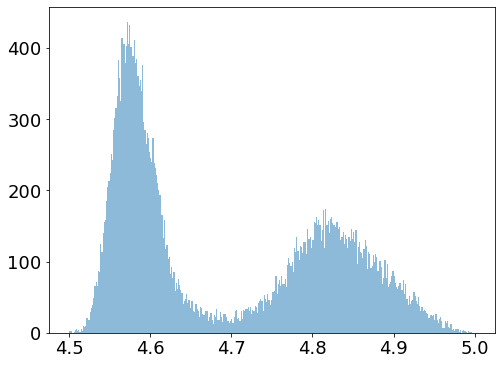

In [75]:
plt.figure(figsize=(8,6))
plt.hist(ab_corr,bins=350, range=(4.5,5.0), alpha=0.5, label="corrected")
plt.hist(ab_uncorr,bins=350, range=(4.5,5.0), alpha=0.5, label="uncorrected")
plt.xlabel("$(a+b)$")
plt.legend()
plt.title("9-Raft E2V R22:S11\nCenter Spots")

NameError: name 'ab_uncorr' is not defined

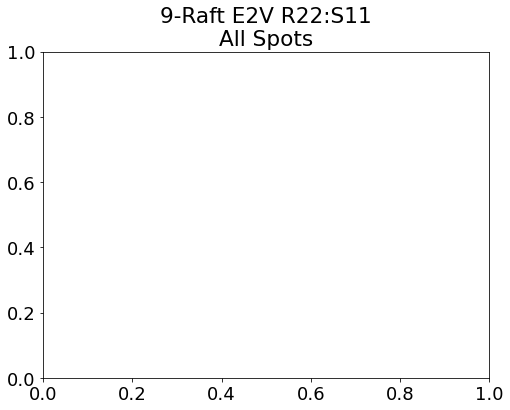

In [76]:
plt.figure(figsize=(8,6))
plt.title("9-Raft E2V R22:S11\nCenter Spots")
sca = plt.scatter(ab_uncorr,ab_corr, c=z, cmap='rainbow', s=3, vmin=4.5,vmax=5.05)
lims = [
    np.min([4.5, 4.5]),  # min of both axes
    np.max([5.0, 5.0]),  # max of both axes
]

# now plot both limits against eachother
plt.plot(lims, lims,'k--', alpha=0.75, zorder=1)
plt.xlabel("$(a+b)_{uncorrected}$", fontsize=12)
plt.ylabel("$(a+b)_{corrected}$", fontsize=12)
plt.colorbar(label="T0")


NameError: name 'ixxiyy_uncorr' is not defined

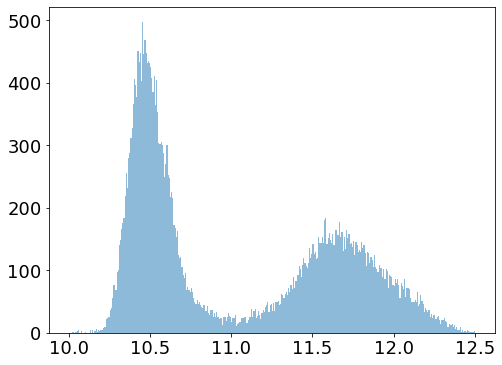

In [77]:
plt.figure(figsize=(8,6))
plt.hist(ixxiyy_corr,bins=350, range=(10,12.5), alpha=0.5, label="corrected")
plt.hist(ixxiyy_uncorr,bins=350, range=(10,12.5), alpha=0.5, label="uncorrected")
plt.legend()
plt.xlabel("$(Ixx+Iyy)$")
plt.title("9-Raft E2V R22:S11\nCenter Spots")

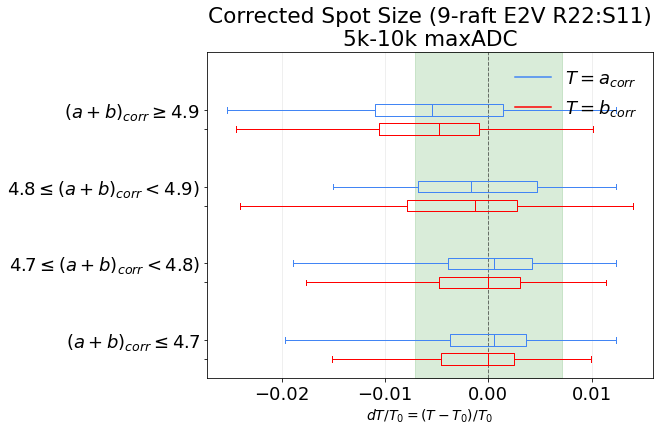

In [78]:
c = "#4285F4"

import matplotlib.cbook as cbook


stats = {}

# a

stats['A'] = cbook.boxplot_stats(y[cond & bin1])[0]
stats['B'] = cbook.boxplot_stats(y[cond & bin2])[0]
stats['C'] = cbook.boxplot_stats(y[cond & bin3])[0]
stats['D'] = cbook.boxplot_stats(y[cond & bin4])[0]

stats['A']['label'] = r"$(a+b)_{corr} \leq 4.7$"
stats['B']['label'] = r"$4.7 \leq (a+b)_{corr} < 4.8)$"
stats['C']['label'] = r"$4.8 \leq (a+b)_{corr} < 4.9)$"
stats['D']['label'] = r"$(a+b)_{corr} \geq 4.9$"

stats['A']['q1'], stats['A']['q3'] = np.percentile(y[cond & bin1], [50-34.1, 50+34.1])
stats['B']['q1'], stats['B']['q3'] = np.percentile(y[cond & bin2], [50-34.1, 50+34.1])
stats['C']['q1'], stats['C']['q3'] = np.percentile(y[cond & bin3], [50-34.1, 50+34.1])
stats['D']['q1'], stats['D']['q3'] = np.percentile(y[cond & bin4], [50-34.1, 50+34.1])

stats['A']['whislo'], stats['A']['whishi'] = np.min(y[cond & bin1]), np.max(y[cond & bin1])
stats['B']['whislo'], stats['B']['whishi'] = np.min(y[cond & bin2]), np.max(y[cond & bin1])
stats['C']['whislo'], stats['C']['whishi'] = np.min(y[cond & bin3]), np.max(y[cond & bin1])
stats['D']['whislo'], stats['D']['whishi'] = np.min(y[cond & bin4]), np.max(y[cond & bin1])


# b

stats['W'] = cbook.boxplot_stats(y2[cond & bin1])[0]
stats['X'] = cbook.boxplot_stats(y2[cond & bin2])[0]
stats['Y'] = cbook.boxplot_stats(y2[cond & bin3])[0]
stats['Z'] = cbook.boxplot_stats(y2[cond & bin4])[0]

stats['W']['label'] = ""
stats['X']['label'] = ""
stats['Y']['label'] = ""
stats['Z']['label'] = ""

stats['W']['q1'], stats['A']['q3'] = np.percentile(y2[cond & bin1], [50-34.1, 50+34.1])
stats['X']['q1'], stats['B']['q3'] = np.percentile(y2[cond & bin2], [50-34.1, 50+34.1])
stats['Y']['q1'], stats['C']['q3'] = np.percentile(y2[cond & bin3], [50-34.1, 50+34.1])
stats['Z']['q1'], stats['D']['q3'] = np.percentile(y2[cond & bin4], [50-34.1, 50+34.1])

stats['W']['whislo'], stats['A']['whishi'] = np.min(y2[cond & bin1]), np.max(y[cond & bin1])
stats['X']['whislo'], stats['B']['whishi'] = np.min(y2[cond & bin2]), np.max(y[cond & bin1])
stats['Y']['whislo'], stats['C']['whishi'] = np.min(y2[cond & bin3]), np.max(y[cond & bin1])
stats['Z']['whislo'], stats['D']['whishi'] = np.min(y2[cond & bin4]), np.max(y[cond & bin1])

fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.set_title("Corrected Spot Size (9-raft E2V R22:S11)\n5k-10k maxADC")
ax.axvline(0.0,color="black", linestyle="dashed", linewidth=1, alpha=0.5)
ax.bxp([stats['A'], stats['B'], stats['C'], stats['D']],
             positions=[2*i+1 for i in range(4)],
             widths=[0.3, 0.3,0.3,0.3],
             vert=False,
             showfliers=False,
             boxprops=dict(color=c),
             capprops=dict(color=c),
             whiskerprops=dict(color=c),
             flierprops=dict(color=c, markeredgecolor=c),
             medianprops=dict(color='#4285F4') )

c="red"
ax.bxp([stats['W'], stats['X'], stats['Y'], stats['Z']],
             positions=[2*i+1-.5 for i in range(4)],
             widths=[0.3, 0.3,0.3,0.3],
             vert=False,
             showfliers=False,
             boxprops=dict(color=c),
             capprops=dict(color=c),
             whiskerprops=dict(color=c),
             flierprops=dict(color=c, markeredgecolor=c),
             medianprops=dict(color='red') )

ax.set_xlabel("{}".format(r"$dT/T_0=(T-T_0)/T_0$"),fontsize=fontsize)
ax.fill_between(x=[-0.71/100.,0.71/100.], y1=[8.5,8.5], color="green",alpha=0.15)
ax.set_ylim(0,8.5)
#ax.set_xlim(-0.03,0.02)
ax.plot([],[],"-",color="#4285F4", label=r"$T = a_{corr}$")
ax.plot([],[],"-",color="red", label=r"$T = b_{corr}$")
ax.legend(loc=1, frameon=False)
ax.grid(axis='x', alpha=0.25)

<ipython-input-110-b05dbf78d7e3>:61: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot("111")


'cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])\nplt.colorbar(scb,cax=cbar_ax,label="a+b (uncorrected)")\n\nplt.subplots_adjust(right=0.90,hspace=0)'

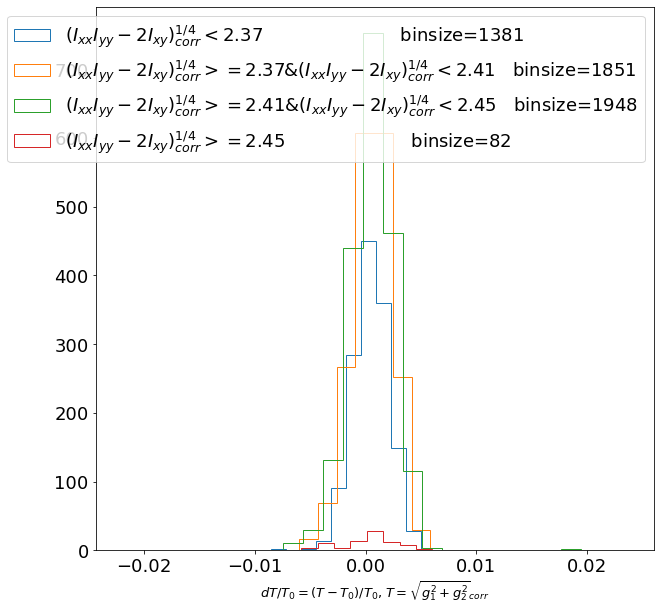

In [110]:
table = tab_corr
ref = tab_corr[np.where(tab_corr['exptime'] == 6.0)][0]
from math import log10, floor
y1key="base_SdssShape_xx"#"a"
y2key="base_SdssShape_yy"#"b"
y3key="base_SdssShape_xy"
xkey="maxADC"
#xkey="base_CircularApertureFlux_70_0_instFlux"
#zskey="base_CircularApertureFlux_3_0_instFlux"
zskey="base_PsfFlux_instFlux"
zlkey="base_CircularApertureFlux_70_0_instFlux"

fontsize=13

x = []
y = []
z = []
e = []

x2 = []
y2 = []
z2 = []
e2 = []

for iterable in table:
    if iterable['exptime'] == 6.0:
        continue
        
    spots, iter_ind, ref_ind = np.intersect1d(iterable['spot_indices'], ref['spot_indices'], return_indices=True)
    x.extend(iterable[xkey][iter_ind])
    Y1=iterable[y1key][iter_ind]
    Y2=iterable[y2key][iter_ind]
    Y3=iterable[y3key][iter_ind]
    Y0_1=ref[y1key][ref_ind]
    Y0_2=ref[y2key][ref_ind] 
    Y0_3=ref[y3key][ref_ind]
    
    g1 = Y1 - Y2
    g2 = 2. * Y3
    g0_1 = Y0_1 - Y0_2
    g0_2 = 2. * Y0_3
    y.extend((Y1*Y2-(Y3**2))**(1./4.))
    z.extend(((Y1*Y2-(Y3**2))**(1./4.) - (Y0_1*Y0_2-(Y0_3**2))**(1./4.)) / (Y0_1*Y0_2-(Y0_3**2))**(1./4.))
    #y.extend( np.sqrt(g1**2. + g2**2.))
    #z.extend((np.sqrt(g1**2. + g2**2.) - np.sqrt(g0_1**2. + g0_2**2.))/ np.sqrt(g0_1**2. + g0_2**2.))
    #y.extend( (Y1+Y2))#-(Y0_1+Y0_2) )
    #e.extend((Y1+Y2))
    e.extend([iterable['exptime']]*len(Y1))

x=np.array(x)
y=np.array(y)
z=np.array(z)
e=np.array(e)

def round_sig(x, sig=3):
    return round(x, sig-int(floor(log10(abs(x))))-1)

# Plot

fig = plt.figure(figsize=(10,10), facecolor='w')
ax = plt.subplot("111")
cond = (x>=35000) & (x<=60000)
zoutliermask = (z >= -1.) & (z <= 1.)
bin1 = (y < 2.28)
bin2 = (y >= 2.28) & (y < 2.29)
bin3 = (y >= 2.29) & (y < 2.31)
bin4 = (y >= 2.31)
"""bin1 = (y < 2.28)
bin2 = (y >= 2.28) & (y < 2.29)
bin3 = (y >= 2.29) & (y < 2.31)
bin4 = (y >= 2.31)"""
"""bin1 = (z <= 4.7)
bin2 = (z >= 4.7) & (z < 4.8) 
bin3 = (z >= 4.8) & (z < 4.9)
bin4 = (z >= 4.9)"""
binsizes = [str(len(y[cond & zoutliermask & bin1])), str(len(y[cond & zoutliermask & bin2])), str(len(y[cond & zoutliermask & bin3])), str(len(y[cond & zoutliermask & bin4]))]
ax.hist(z[cond & zoutliermask & bin1], bins=20, histtype='step', label="$(I_{xx}I_{yy}-2I_{xy})^{1/4} _{corr} < 2.37$                        binsize=" + binsizes[0])
ax.hist(z[cond & zoutliermask & bin2], bins=20, histtype='step', label="$(I_{xx}I_{yy}-2I_{xy})^{1/4} _{corr} >= 2.37 & (I_{xx}I_{yy}-2I_{xy})^{1/4} _{corr} < 2.41$   binsize=" + binsizes[1])
ax.hist(z[cond & zoutliermask & bin3], bins=20, histtype='step', label="$(I_{xx}I_{yy}-2I_{xy})^{1/4} _{corr} >= 2.41 & (I_{xx}I_{yy}-2I_{xy})^{1/4} _{corr} < 2.45$   binsize=" + binsizes[2])
ax.hist(z[cond & zoutliermask & bin4], bins=20, histtype='step', label="$(I_{xx}I_{yy}-2I_{xy})^{1/4} _{corr} >= 2.45$                      binsize=" + binsizes[3])
ax.legend(loc=1)
ax.set_xlabel("{}".format(r"$dT/T_0=(T-T_0)/T_0$, $T = \sqrt{g_{1}^2 + g_{2}^2}_{corr}$"),fontsize=fontsize)
#ax.set_xlim(2.25,2.5)

"""
ax.set_ylabel("{}".format(r"$dT=T-T_0$, $T = (a+b)$"),fontsize=fontsize)
ax.set_xlabel("maxADC")
#ax.set_xlim(1e5,1e7)
ax.set_ylim(-.5,.5)
ax.grid()
"""
# Plot the min and max ptc turnoffs for this sensor
#    from: https://github.com/lsst/obs_lsst/blob/master/policy/lsstCam/R10.yaml

#plt.colorbar(scb,label="EXPTIME",orientation="horizontal",location="bottom")
"""cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
plt.colorbar(scb,cax=cbar_ax,label="a+b (uncorrected)")

plt.subplots_adjust(right=0.90,hspace=0)"""



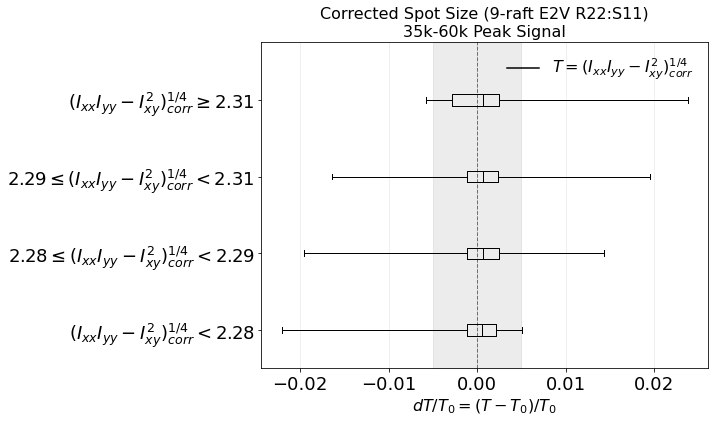

In [111]:

c = "black"

import matplotlib.cbook as cbook


stats = {}

# a
fontsize=16
stats['A'] = cbook.boxplot_stats(z[cond & zoutliermask & bin1])[0]
stats['B'] = cbook.boxplot_stats(z[cond & zoutliermask & bin2])[0]
stats['C'] = cbook.boxplot_stats(z[cond & zoutliermask & bin3])[0]
stats['D'] = cbook.boxplot_stats(z[cond & zoutliermask & bin4])[0]


stats['A']['label'] = r"$(I_{xx}I_{yy}-I_{xy}^{2})^{1/4} _{corr} < 2.28$"
stats['B']['label'] = r"$2.28 \leq (I_{xx}I_{yy}-I_{xy}^{2})^{1/4} _{corr} < 2.29$"
stats['C']['label'] = r"$2.29 \leq (I_{xx}I_{yy}-I_{xy}^{2})^{1/4} _{corr} < 2.31$"
stats['D']['label'] = r"$(I_{xx}I_{yy}-I_{xy}^{2})^{1/4} _{corr} \geq 2.31$"

"""stats['A']['label'] = r"$(a+b)_{corr} \leq 4.7$"
stats['B']['label'] = r"$4.7 \leq (a+b)_{corr} < 4.8)$"
stats['C']['label'] = r"$4.8 \leq (a+b)_{corr} < 4.9)$"
stats['D']['label'] = r"$(a+b)_{corr} \geq 4.9$"""

stats['A']['q1'], stats['A']['q3'] = np.percentile(z[cond & zoutliermask & bin1], [50-34.1, 50+34.1])
stats['B']['q1'], stats['B']['q3'] = np.percentile(z[cond & zoutliermask & bin2], [50-34.1, 50+34.1])
stats['C']['q1'], stats['C']['q3'] = np.percentile(z[cond & zoutliermask & bin3], [50-34.1, 50+34.1])
stats['D']['q1'], stats['D']['q3'] = np.percentile(z[cond & zoutliermask & bin4], [50-34.1, 50+34.1])

stats['A']['whislo'], stats['A']['whishi'] = np.min(z[cond & zoutliermask & bin1]), np.max(z[cond & zoutliermask & bin1])
stats['B']['whislo'], stats['B']['whishi'] = np.min(z[cond & zoutliermask & bin2]), np.max(z[cond & zoutliermask & bin2])
stats['C']['whislo'], stats['C']['whishi'] = np.min(z[cond & zoutliermask & bin3]), np.max(z[cond & zoutliermask & bin3])
stats['D']['whislo'], stats['D']['whishi'] = np.min(z[cond & zoutliermask & bin4]), np.max(z[cond & zoutliermask & bin4])


fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.set_title("Corrected Spot Size (9-raft E2V R22:S11)\n35k-60k Peak Signal", fontsize=fontsize)
ax.axvline(0.0,color="black", linestyle="dashed", linewidth=1, alpha=0.5)
ax.bxp([stats['A'], stats['B'], stats['C'], stats['D']],
             positions=[2*i+1 for i in range(4)],
             widths=[0.3, 0.3,0.3,0.3],
             vert=False,
             showfliers=False,
             boxprops=dict(color=c),
             capprops=dict(color=c),
             whiskerprops=dict(color=c),
             flierprops=dict(color=c, markeredgecolor=c),
             medianprops=dict(color=c) )


ax.set_xlabel("{}".format(r"$dT/T_0=(T-T_0)/T_0$"),fontsize=fontsize)
ax.fill_between(x=[-0.005,0.005], y1=[8.5,8.5], color="grey",alpha=0.15)
ax.set_ylim(0,8.5)
#ax.set_xlim(-0.03,0.02) 
ax.plot([],[],"-",color="black", label=r"$T = (I_{xx}I_{yy}-I_{xy}^{2})^{1/4} _{corr}$")
ax.legend(loc=1, frameon=False, fontsize=fontsize)
ax.grid(axis='x', alpha=0.25)

In [55]:
print(stats['A'])
print()
print(stats['B'])
print()
print(stats['C'])
print()
print(stats['D'])
print()

{'mean': 0.0002620572428764408, 'iqr': 0.0023401654413195082, 'cilo': 4.2276818428421605e-05, 'cihi': 0.000476022597215821, 'whishi': 0.003936195390745103, 'whislo': -0.0043099465218813535, 'fliers': array([], dtype=float64), 'q1': -0.0014112030744340956, 'med': 0.0002591497078221213, 'q3': 0.001982486428747638, 'label': '$\\sqrt{g_{1}^2 + g_{2}^2}_{corr} < 0.3$'}

{'mean': 0.0006189126433101122, 'iqr': 0.0021228534951291413, 'cilo': 0.0005798387027902767, 'cihi': 0.0007798215014213644, 'whishi': 0.005643868345215095, 'whislo': -0.022503500953438303, 'fliers': array([-0.00372906, -0.0039634 , -0.0225035 , -0.00457673, -0.00397191,
       -0.00366306, -0.00571215, -0.00501716,  0.00564387,  0.00497705]), 'q1': -0.0009241830346237908, 'med': 0.0006798301021058205, 'q3': 0.0022753977244335823, 'label': '$0.3 \\leq \\sqrt{g_{1}^2 + g_{2}^2}_{corr} < 0.4$'}

{'mean': 0.0006121794112316849, 'iqr': 0.0023382355980818706, 'cilo': 0.000622723712027667, 'cihi': 0.0007506295026893557, 'whishi': 0

<ipython-input-15-b927f3936447>:44: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot("211")
<ipython-input-15-b927f3936447>:56: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  bx = plt.subplot("212",sharex=ax)


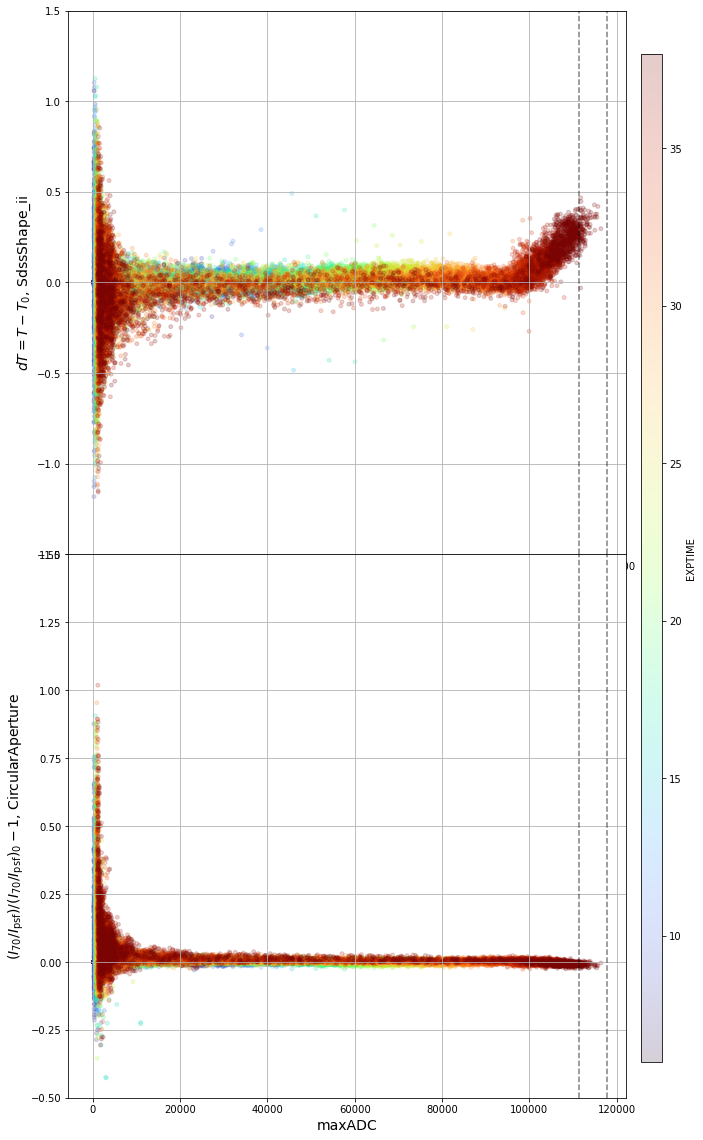

In [15]:
table = tab_corr
ref = table[np.where(table['exptime'] == 6.0)][0]

y1key="base_SdssShape_xx"
y2key="base_SdssShape_yy"
xkey="maxADC"
#xkey="base_CircularApertureFlux_70_0_instFlux"
#zskey="base_CircularApertureFlux_3_0_instFlux"
zskey="base_PsfFlux_instFlux"
zlkey="base_CircularApertureFlux_70_0_instFlux"

fontsize=14

x = []
y = []
zl = []
zs = []
e = []

for iterable in table:
    spots, iter_ind, ref_ind = np.intersect1d(iterable['spot_indices'], ref['spot_indices'], return_indices=True)

    x.extend(iterable[xkey][iter_ind])
    Y1=iterable[y1key][iter_ind]
    Y2=iterable[y2key][iter_ind]
    Y0_1=ref[y1key][ref_ind]
    Y0_2=ref[y2key][ref_ind] 
    
    zl.extend(iterable[zlkey][iter_ind]/ref[zlkey][ref_ind])
    zs.extend(iterable[zskey][iter_ind]/ref[zskey][ref_ind])
    y.extend( Y1+Y2-(Y0_1+Y0_2) )
    e.extend([iterable['exptime']]*len(Y1))

x=np.array(x)
y=np.array(y)
zl=np.array(zl)
zs=np.array(zs)



# Plot

fig = plt.figure(figsize=(10,20), facecolor='w')
ax = plt.subplot("211")
sca=ax.scatter(x,y,c=e,s=15,cmap='turbo',alpha=0.2)
#ax.scatter(x2,y2,c="r", s=15)

"""for i in range(len(e2)):
    if (x2[i] >= 1e5) and (x2[i] <= 1e7) and (np.abs(y2[i]) <= 0.4):
        ax.text(x2[i],y2[i]+0.0075,str(e2[i]), c="red")"""
ax.set_ylabel("{}".format(r"$dT=T-T_0$, SdssShape_ii"),fontsize=fontsize)
#ax.set_xlim(1e5,1e7)
ax.set_ylim(-1.5,1.5)
ax.grid()

bx = plt.subplot("212",sharex=ax)
scb=bx.scatter(x,zs/zl-1,c=e,s=15,cmap='turbo',alpha=0.2)
bx.set_ylabel("{}".format(r"$(I_{70}/I_{\rm psf})/(I_{70}/I_{\rm psf})_0-1$, CircularAperture"),fontsize=fontsize)
#bx.set_xlim(1e5,1e7)
bx.set_ylim(-.5,1.5)
#plt.semilogx()
bx.grid()
bx.set_xlabel(xkey,fontsize=fontsize)

# Plot the min and max ptc turnoffs for this sensor
#    from: https://github.com/lsst/obs_lsst/blob/master/policy/lsstCam/R10.yaml
for ch in [111273, 117803] :
    ax.axvline(ch, c="k", ls="--", alpha=0.5)
    bx.axvline(ch, c="k", ls="--", alpha=0.5)

#plt.colorbar(scb,label="EXPTIME",orientation="horizontal",location="bottom")
cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
plt.colorbar(scb,cax=cbar_ax,label="EXPTIME")

plt.subplots_adjust(right=0.90,hspace=0)
plt.savefig("./plots/e2v-R22_S11-9raft/polynomialfit/centerspots/summary_Ixx+Iyy_BFcorrected.png")



<ipython-input-53-70a2283afa48>:45: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot("211")
<ipython-input-53-70a2283afa48>:57: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  bx = plt.subplot("212",sharex=ax)


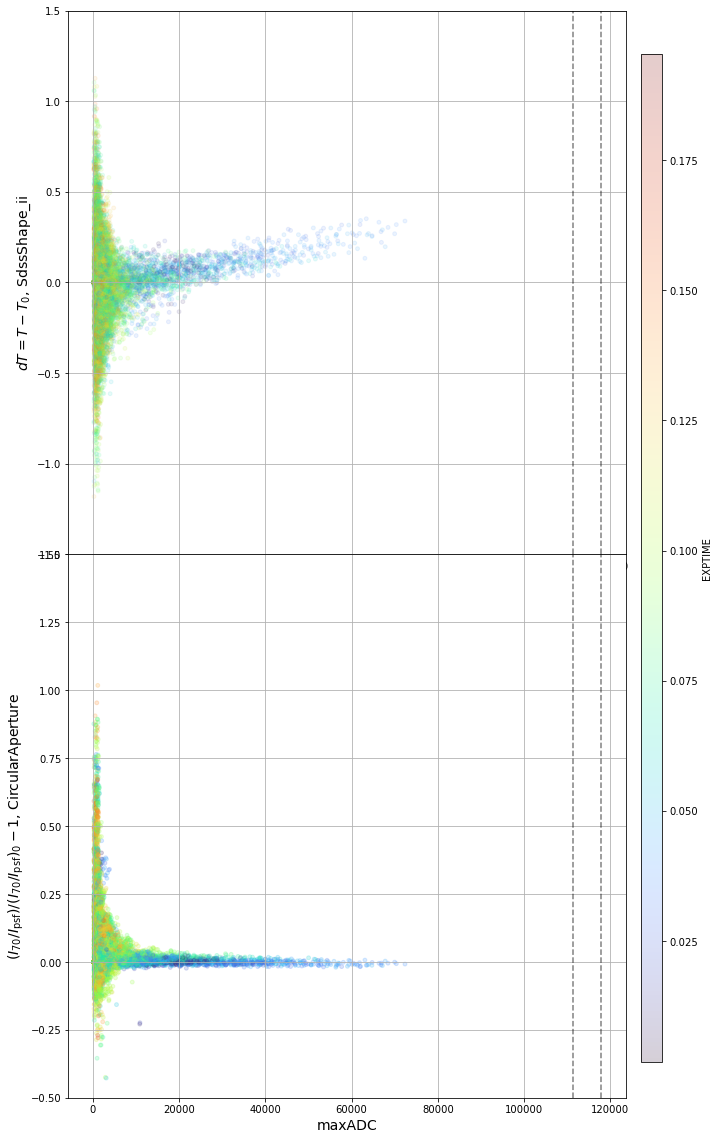

In [53]:
table = tab_uncorr
ref = table[np.where(table['exptime'] == 6.0)][0]

y1key="base_SdssShape_xx"
y2key="base_SdssShape_yy"
xkey="maxADC"
#xkey="base_CircularApertureFlux_70_0_instFlux"
#zskey="base_CircularApertureFlux_3_0_instFlux"
zskey="base_PsfFlux_instFlux"
zlkey="base_CircularApertureFlux_70_0_instFlux"

fontsize=14

x = []
y = []
zl = []
zs = []
e = []

for iterable in table:
    spots, iter_ind, ref_ind = np.intersect1d(iterable['spot_indices'], ref['spot_indices'], return_indices=True)

    x.extend(iterable[xkey][iter_ind])
    Y1=iterable[y1key][iter_ind]
    Y2=iterable[y2key][iter_ind]
    Y0_1=ref[y1key][ref_ind]
    Y0_2=ref[y2key][ref_ind] 
    
    zl.extend(iterable[zlkey][iter_ind]/ref[zlkey][ref_ind])
    zs.extend(iterable[zskey][iter_ind]/ref[zskey][ref_ind])
    y.extend( Y1+Y2-(Y0_1+Y0_2) )
    e.extend((iterable['a'][iter_ind] - iterable['b'][iter_ind]) / iterable['a'][iter_ind])
    #e.extend([iterable['exptime']]*len(Y1))

x=np.array(x)
y=np.array(y)
zl=np.array(zl)
zs=np.array(zs)



# Plot

fig = plt.figure(figsize=(10,20), facecolor='w')
ax = plt.subplot("211")
sca=ax.scatter(x,y,c=e,s=15,cmap='turbo',alpha=0.1)
#ax.scatter(x2,y2,c="r", s=15)

"""for i in range(len(e2)):
    if (x2[i] >= 1e5) and (x2[i] <= 1e7) and (np.abs(y2[i]) <= 0.4):
        ax.text(x2[i],y2[i]+0.0075,str(e2[i]), c="red")"""
ax.set_ylabel("{}".format(r"$dT=T-T_0$, SdssShape_ii"),fontsize=fontsize)
#ax.set_xlim(1e5,1e7)
ax.set_ylim(-1.5,1.5)
ax.grid()

bx = plt.subplot("212",sharex=ax)
scb=bx.scatter(x,zs/zl-1,c=e,s=15,cmap='turbo',alpha=0.2)
bx.set_ylabel("{}".format(r"$(I_{70}/I_{\rm psf})/(I_{70}/I_{\rm psf})_0-1$, CircularAperture"),fontsize=fontsize)
#bx.set_xlim(1e5,1e7)
bx.set_ylim(-.5,1.5)
#plt.semilogx()
bx.grid()
bx.set_xlabel(xkey,fontsize=fontsize)

# Plot the min and max ptc turnoffs for this sensor
#    from: https://github.com/lsst/obs_lsst/blob/master/policy/lsstCam/R10.yaml
for ch in [111273, 117803] :
    ax.axvline(ch, c="k", ls="--", alpha=0.5)
    bx.axvline(ch, c="k", ls="--", alpha=0.5)

#plt.colorbar(scb,label="EXPTIME",orientation="horizontal",location="bottom")

cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
plt.colorbar(scb,cax=cbar_ax,label="EXPTIME")

plt.subplots_adjust(right=0.90,hspace=0)
plt.savefig("./plots/e2v-R22_S11-9raft/polynomialfit/centerspots/summary_Ixx+Iyy_NOT-BFcorrected.png")

<ipython-input-17-48c93173503c>:56: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  bx = plt.subplot("111",sharex=ax)


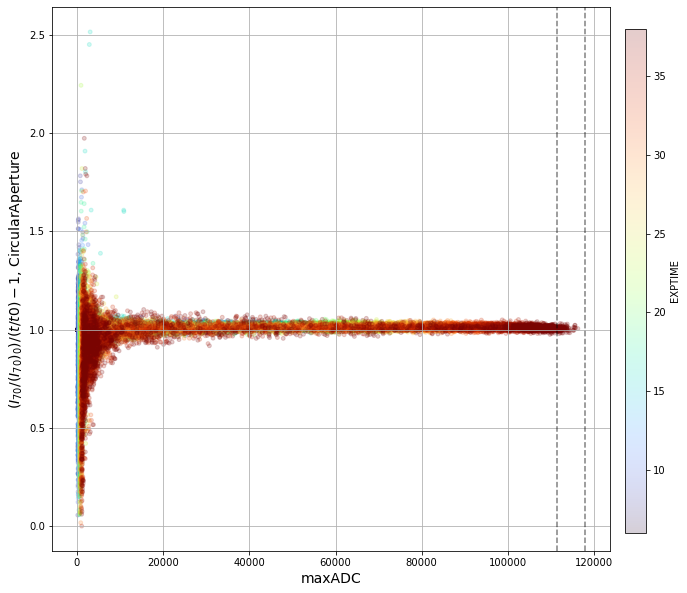

In [17]:
table = tab_uncorr
ref = table[np.where(table['exptime'] == 6.0)][0]

y1key="base_SdssShape_xx"
y2key="base_SdssShape_yy"
xkey="maxADC"
#xkey="base_CircularApertureFlux_70_0_instFlux"
zskey="base_CircularApertureFlux_70_0_instFlux"
#zskey="base_PsfFlux_instFlux"
zlkey="base_CircularApertureFlux_70_0_instFlux"

fontsize=14

x = []
y = []
zl = []
zs = []
e = []

for iterable in table:
    spots, iter_ind, ref_ind = np.intersect1d(iterable['spot_indices'], ref['spot_indices'], return_indices=True)

    x.extend(iterable[xkey][iter_ind])
    Y1=iterable[y1key][iter_ind]
    Y2=iterable[y2key][iter_ind]
    Y0_1=ref[y1key][ref_ind]
    Y0_2=ref[y2key][ref_ind] 
    
    zl.extend(iterable[zlkey][iter_ind]/ref[zlkey][ref_ind])
    zs.extend(iterable[zskey][iter_ind]/ref[zskey][ref_ind])
    y.extend( Y1+Y2-(Y0_1+Y0_2) )
    e.extend([iterable['exptime']]*len(Y1))

x=np.array(x)
y=np.array(y)
zl=np.array(zl)
zs=np.array(zs)



# Plot

fig = plt.figure(figsize=(10,10), facecolor='w')
#ax = plt.subplot("111")
#sca=ax.scatter(x,y,c=e,s=15,cmap='turbo',alpha=0.2)
#ax.scatter(x2,y2,c="r", s=15)

"""for i in range(len(e2)):
    if (x2[i] >= 1e5) and (x2[i] <= 1e7) and (np.abs(y2[i]) <= 0.4):
        ax.text(x2[i],y2[i]+0.0075,str(e2[i]), c="red")"""
#ax.set_ylabel("{}".format(r"$dT=T-T_0$, SdssShape_ii"),fontsize=fontsize)
#ax.set_xlim(1e5,1e7)
#ax.set_ylim(-1.,2.5)
#ax.grid()
e = np.asarray(e)
bx = plt.subplot("111",sharex=ax)
scb=bx.scatter(x,(zs/(e/12.))-1,c=e,s=15,cmap='turbo',alpha=0.2)
bx.set_ylabel("{}".format(r"$(I_{70}/(I_{70})_0) / (t/t0)-1$, CircularAperture"),fontsize=fontsize)
#bx.set_xlim(1e5,1e7)
#bx.set_ylim(-0.5,0.8)
#plt.semilogx()
bx.grid()
bx.set_xlabel(xkey,fontsize=fontsize)

# Plot the min and max ptc turnoffs for this sensor
#    from: https://github.com/lsst/obs_lsst/blob/master/policy/lsstCam/R10.yaml
for ch in [111273, 117803] :
    ax.axvline(ch, c="k", ls="--", alpha=0.5)
    bx.axvline(ch, c="k", ls="--", alpha=0.5)

#plt.colorbar(scb,label="EXPTIME",orientation="horizontal",location="bottom")

cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
plt.colorbar(scb,cax=cbar_ax,label="EXPTIME")

plt.subplots_adjust(right=0.90,hspace=0)
plt.savefig("./plots/e2v-R22_S11-9raft/polynomialfit/centerspots/summary_I70_I70.png")

<ipython-input-18-f6e2e8cf83a8>:43: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  cx = plt.subplot("111")


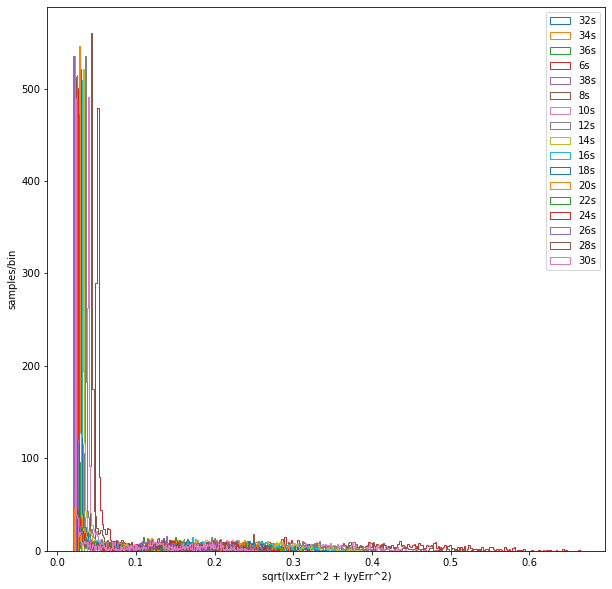

In [18]:
table = tab_uncorr
ref = table[np.where(table['exptime'] == 6.0)][0]

y1key="base_SdssShape_xxErr"
y2key="base_SdssShape_yyErr"
xkey="maxADC"
#xkey="base_CircularApertureFlux_70_0_instFlux"
#zskey="base_CircularApertureFlux_3_0_instFlux"
zskey="base_PsfFlux_instFlux"
zlkey="base_CircularApertureFlux_70_0_instFlux"

fontsize=14

x = []
y = []
zl = []
zs = []
e = []

for iterable in table:
    spots, iter_ind, ref_ind = np.intersect1d(iterable['spot_indices'], ref['spot_indices'], return_indices=True)

    x.extend(iterable[xkey][iter_ind])
    Y1=iterable[y1key][iter_ind]
    Y2=iterable[y2key][iter_ind]
    Y3=iterable["base_SdssShape_xyErr"][iter_ind]
    Y0_1=ref["base_SdssShape_xx"][ref_ind]
    Y0_2=ref["base_SdssShape_yy"][ref_ind] 
    
    zl.extend(iterable[zlkey][iter_ind]/ref[zlkey][ref_ind])
    zs.extend(iterable[zskey][iter_ind]/ref[zskey][ref_ind])
    y.extend( Y1**2 + Y2**2 + 2*Y3**2) #/ (Y0_1+Y0_2))
    e.extend([iterable['exptime']]*len(Y1))

x=np.array(x)
y=np.array(y)
zl=np.array(zl)
zs=np.array(zs)

#np.sqrt()

fig = plt.figure(figsize=(10,10), facecolor='w')
cx = plt.subplot("111")
properr = []
for i in list(set(e)):
    properr.append(np.sqrt(np.mean(y[np.where((e==i)&(y!=0))])))
    plt.hist(np.sqrt(y[np.where((e==i)&(y!=0))]),bins=300,label=f"{i:.0f}s", histtype="step")
plt.xlabel("sqrt(IxxErr^2 + IyyErr^2)")
plt.ylabel("samples/bin")
plt.legend()

Lowest exposure

<ipython-input-76-23bd87ef9a38>:103: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot("211")
<ipython-input-76-23bd87ef9a38>:167: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  bx = plt.subplot("212")


5.8967691813500355e-08 -0.000154423088435526
-9.545539662202563e-05


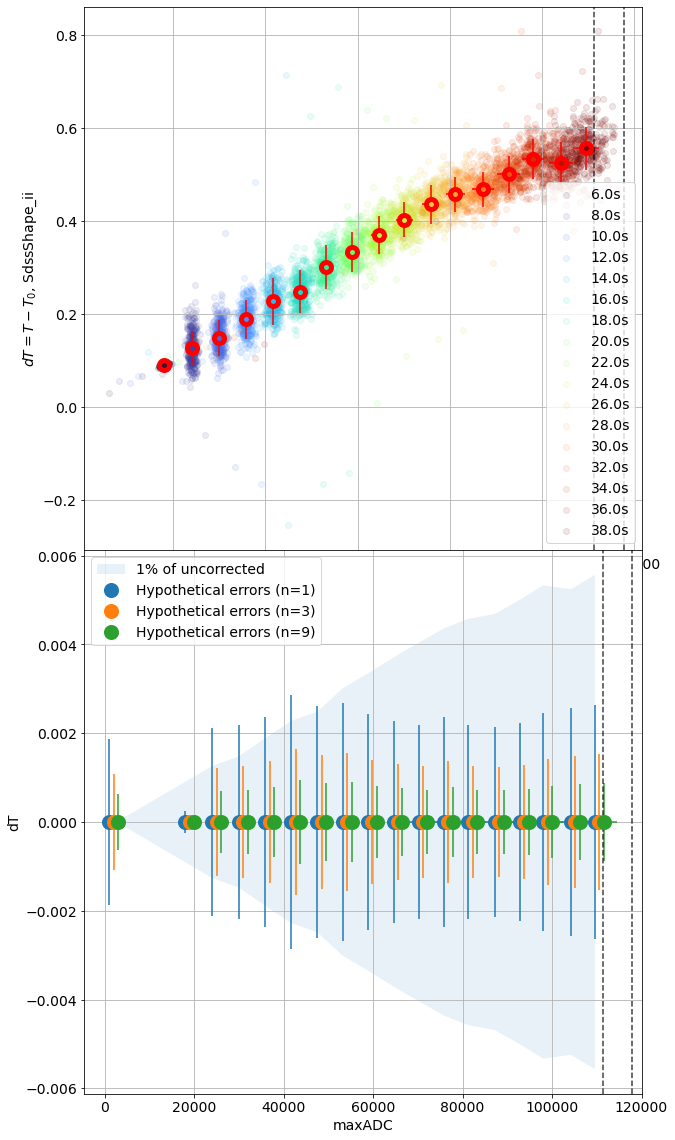

In [76]:
from astropy.stats import mad_std

class Aggregated:
    pass
    
table = tab_uncorr
refs = []
exptimes = np.unique(tab_corr['exptime'])
for t in exptimes:
    refs.append(tab_corr[np.where(tab_corr['exptime'] == t)][0])

y1key="base_SdssShape_xx"
y2key="base_SdssShape_yy"
xkey="maxADC"
#xkey="base_CircularApertureFlux_70_0_instFlux"
#zskey="base_CircularApertureFlux_3_0_instFlux"
zskey="base_PsfFlux_instFlux"
zlkey="base_CircularApertureFlux_70_0_instFlux"

fontsize=14
T0s = []


from functools import reduce
spots_to_track = reduce(np.intersect1d, tuple(i['spot_indices'] for i in table))
T0 = np.zeros(len(spots_to_track))
for i, spot in enumerate(spots_to_track):
    xs = []
    ys = []
    tmp = []
    for exp, tbl in enumerate(table.groups):
        if np.mean(tbl['exptime']) > 16.:
            continue
        for iterable in tbl:
            indx = np.argwhere(iterable['spot_indices'] == spot)[0][0]
            xs.append(iterable[xkey][indx])
            Y1=iterable[y1key][indx]
            Y2=iterable[y2key][indx]
            ys.append(Y1+Y2)
            ref = refs[np.argwhere(iterable['exptime'] == exptimes)[0][0]]
            Y0_1=ref[y1key][indx]
            Y0_2=ref[y2key][indx]
            tmp.append(Y0_1+Y0_2)

    m, b = np.polyfit(xs, ys, 1)
    T0[i] = b
    T0s.append(np.asarray(tmp))


x = []
y = []
IxxErrs = []
IyyErrs = []
IxyErrs = []
ixx = []
iyy = []
zl = []
zs = []
e = []
exps = []
for iterable in table:
    index = np.argwhere(exptimes==iterable['exptime'])[0][0]
    ref = refs[0]
    spots, iter_ind, ref_ind = np.intersect1d(iterable['spot_indices'], spots_to_track, return_indices=True)
        
    x.extend(iterable[xkey][iter_ind])
    Y1=iterable[y1key][iter_ind]
    Y2=iterable[y2key][iter_ind]
    Y0_1=ref[y1key][ref_ind]
    Y0_2=ref[y2key][ref_ind] 
    
    IxxErrs.extend(iterable["base_SdssShape_xxErr"][ref_ind])
    IyyErrs.extend(iterable["base_SdssShape_yyErr"][ref_ind])
    IxyErrs.extend(iterable["base_SdssShape_xyErr"][ref_ind])
    ixx.extend(iterable["base_SdssShape_xx"][ref_ind])
    iyy.extend(iterable["base_SdssShape_yy"][ref_ind])

    t_0 = T0[ref_ind]
    zl.extend(iterable[zlkey][iter_ind]/ref[zlkey][ref_ind])
    zs.extend(iterable[zskey][iter_ind]/ref[zskey][ref_ind])
#    y.extend( (Y1+Y2-(Y0_1+Y0_2)) / (Y0_1+Y0_2))
    y.extend( (Y1+Y2) - (Y0_1+Y0_2)) #- t_0) #
    e.extend([iterable['exptime']]*len(Y1))

x=np.array(x)
y=np.array(y)
IxxErrs = np.array(IxxErrs)
IyyErrs = np.array(IyyErrs)
IxyErrs = np.array(IxyErrs)
ixx = np.array(ixx)
iyy = np.array(iyy)
zl=np.array(zl)
zs=np.array(zs)
#print(e[0], y[np.where((e==e[0])&(y!=0))].std())


n = len(set(e))-1


# Plot

fig = plt.figure(figsize=(10,20), facecolor='w')
ax = plt.subplot("211")

array_aggregated = []

xs_stderrs = []
ys = []
es = []
stderrs_lowestexp = []
errofstderr_lowestexp = []
xxErrs = []
yyErrs = []
xyErrs = []
ixxs = []
iyys = []
properrs = []

for j, i in enumerate(sorted(list(set(e)))):
    cond = np.argwhere((e==i)&(y!=0))
    sca=ax.scatter(x[cond],y[cond],color=plt.get_cmap('turbo')((j)/n),alpha=0.1, label=str(i)+'s')
    ax.legend()
    num = len(x[cond])
    from astropy.stats import bootstrap
    errofstderr_lowestexp.append(bootstrap(y[cond], bootnum=100, bootfunc=np.std))
    
    aggregated = Aggregated()
    aggregated.e = np.median(i)    
    aggregated.x = np.median(x[cond])
    aggregated.y = np.median(y[cond])
    aggregated.xerr = mad_std(x[cond])
    aggregated.yerr = np.std(y[cond])
    
    xxErrs.append(np.median(IxxErrs[cond]))
    yyErrs.append(np.median(IyyErrs[cond]))
    xyErrs.append(np.median(IxyErrs[cond]))
    ixxs.append(np.median(ixx[cond]))
    iyys.append(np.median(iyy[cond]))
    properrs.append(np.sqrt(np.mean(  IxxErrs[cond]**2 + IyyErrs[cond]**2 + 2*IxyErrs[cond]**2 )))
    
    stderrs_lowestexp.append(aggregated.yerr)
    xs_stderrs.append(aggregated.x)
    aggregated.num = num
    aggregated.color = plt.get_cmap('turbo')((j)/n)
    array_aggregated.append(aggregated)
    
    for spec in [1]:
        sca_3=ax.errorbar(aggregated.x,aggregated.y*spec,
                        xerr=aggregated.xerr,
                        yerr=aggregated.yerr,
                        fmt="o",color=aggregated.color,mec="r",ecolor="r",alpha=1,
                        ms=10,mew=5)

#ax.scatter(x2,y2,c="r", s=15)

"""for i in range(len(e2)):
    if (x2[i] >= 1e5) and (x2[i] <= 1e7) and (np.abs(y2[i]) <= 0.4):
        ax.text(x2[i],y2[i]+0.0075,str(e2[i]), c="red")"""
ax.set_ylabel("{}".format(r"$dT=T - T_0$, SdssShape_ii"),fontsize=fontsize)
#ax.set_xlim(50000,120000)
#plt.ylim(-0.5,1.)

ax.grid()
ax.legend()


bx = plt.subplot("212")

m, b = np.polyfit(xs_stderrs[1:3], stderrs_lowestexp[1:3], 1)
critical_error = m*1000. + b
new = Aggregated()   
new.x = 1000.
new.y = 1000.
new.xerr = 0
new.yerr = critical_error
xi = np.array([ aggregated.x for aggregated in array_aggregated ])
yi = np.array([ aggregated.y*0.01 for aggregated in array_aggregated ])
m, b = np.polyfit(xi[0:2], yi[0:2], 1)
print(m,b)
critical_level = m*1000. + b
xi = np.insert(xi, 0, [1000.])
print(critical_level)
yi = np.insert(yi, 0, [critical_level])
bx.fill_between(xi, -yi, yi, alpha=0.1, label="1% of uncorrected" )
array_aggregated.insert(0,new)

for i, n in enumerate([1, 3, 9]):
    sca_2=bx.errorbar(
        [ aggregated.x+i*1000 for aggregated in array_aggregated ],
        [ aggregated.y*0.0 for aggregated in array_aggregated ],
        xerr=[ aggregated.xerr for aggregated in array_aggregated ],
        yerr=[ aggregated.yerr/np.sqrt(n*311) for aggregated in array_aggregated ],
        fmt="o",
        ms=10,mew=5,
        label="Hypothetical errors (n={})".format(n)
    )

bx.set_ylabel("dT")
bx.legend()
bx.grid()



# Plot the min and max ptc turnoffs for this sensor
#    from: https://github.com/lsst/obs_lsst/blob/master/policy/lsstCam/R10.yaml

for ch in [111273, 117803] :
    for axis in [ax, bx]:
        #axis.set_xlim(50000, 120000)
        axis.axvline(ch, c="k", ls="--", alpha=0.75)

        
#plt.colorbar(scb,label="EXPTIME",orientation="horizontal",location="bottom")

bx.set_xlabel("maxADC")
#cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
#plt.colorbar(sca,cax=cbar_ax,label="EXPTIME")

plt.subplots_adjust(right=0.90,hspace=0)
plt.savefig("./BF-9raft-e2v-error.png")

Exponential

<ipython-input-20-2f3106124cde>:103: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot("211")
<ipython-input-20-2f3106124cde>:168: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  bx = plt.subplot("212")


1.2265168995961468e-07 -0.00019284221496730704
-7.019052500769235e-05


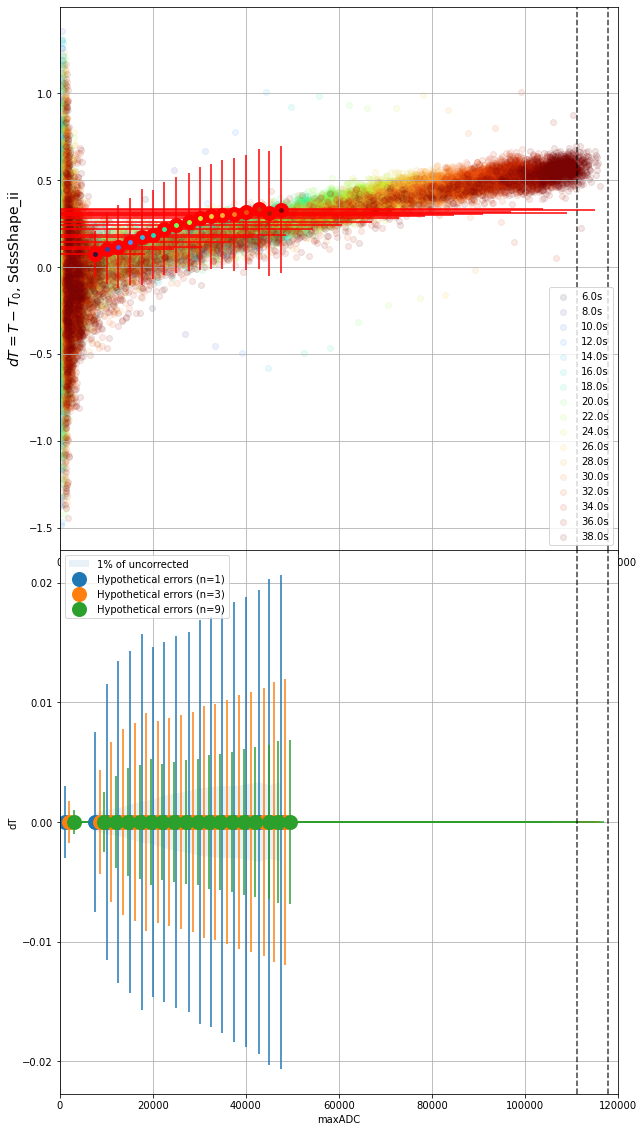

In [20]:
from astropy.stats import mad_std
from scipy.optimize import curve_fit

class Aggregated:
    pass
    
table = tab_uncorr
refs = []
exptimes = np.unique(tab_corr['exptime'])
for t in exptimes:
    refs.append(tab_corr[np.where(tab_corr['exptime'] == t)][0])

y1key="base_SdssShape_xx"
y2key="base_SdssShape_yy"
xkey="maxADC"
#xkey="base_CircularApertureFlux_70_0_instFlux"
#zskey="base_CircularApertureFlux_3_0_instFlux"
zskey="base_PsfFlux_instFlux"
zlkey="base_CircularApertureFlux_70_0_instFlux"

fontsize=14
T0s = []

from functools import reduce
spots_to_track = reduce(np.intersect1d, tuple(i['spot_indices'] for i in table))
T0 = np.zeros(len(spots_to_track))
for i, spot in enumerate(spots_to_track):
    xs = []
    ys = []
    tmp = []
    for exp, tbl in enumerate(table.groups):
        if np.mean(tbl['exptime']) > 14.:
            continue
        for iterable in tbl:
            indx = np.argwhere(iterable['spot_indices'] == spot)[0][0]
            xs.append(iterable[xkey][indx])
            Y1=iterable[y1key][indx]
            Y2=iterable[y2key][indx]
            ys.append(Y1+Y2)
            ref = refs[np.argwhere(iterable['exptime'] == exptimes)[0][0]]
            Y0_1=ref[y1key][indx]
            Y0_2=ref[y2key][indx]
            tmp.append(Y0_1+Y0_2)

    popt, pcov = curve_fit(lambda t,a,b: a*np.exp(b*t),  xs,  ys, p0=(10.4,1./40000.))
    T0[i] = popt[0]
    T0s.append(np.asarray(tmp))


x = []
y = []
IxxErrs = []
IyyErrs = []
IxyErrs = []
ixx = []
iyy = []
zl = []
zs = []
e = []
exps = []
for iterable in table:
    index = np.argwhere(exptimes==iterable['exptime'])[0][0]
    ref = refs[0]
    spots, iter_ind, ref_ind = np.intersect1d(iterable['spot_indices'], spots_to_track, return_indices=True)
        
    x.extend(iterable[xkey][iter_ind])
    Y1=iterable[y1key][iter_ind]
    Y2=iterable[y2key][iter_ind]
    Y0_1=ref[y1key][ref_ind]
    Y0_2=ref[y2key][ref_ind] 
    
    IxxErrs.extend(iterable["base_SdssShape_xxErr"][ref_ind])
    IyyErrs.extend(iterable["base_SdssShape_yyErr"][ref_ind])
    IxyErrs.extend(iterable["base_SdssShape_xyErr"][ref_ind])
    ixx.extend(iterable["base_SdssShape_xx"][ref_ind])
    iyy.extend(iterable["base_SdssShape_yy"][ref_ind])

    t_0 = T0[ref_ind]
    zl.extend(iterable[zlkey][iter_ind]/ref[zlkey][ref_ind])
    zs.extend(iterable[zskey][iter_ind]/ref[zskey][ref_ind])
#    y.extend( (Y1+Y2-(Y0_1+Y0_2)) / (Y0_1+Y0_2))
    y.extend( (Y1+Y2) - t_0) #- (Y0_1+Y0_2)) #
    e.extend([iterable['exptime']]*len(Y1))

x=np.array(x)
y=np.array(y)
IxxErrs = np.array(IxxErrs)
IyyErrs = np.array(IyyErrs)
IxyErrs = np.array(IxyErrs)
ixx = np.array(ixx)
iyy = np.array(iyy)
zl=np.array(zl)
zs=np.array(zs)
#print(e[0], y[np.where((e==e[0])&(y!=0))].std())


n = len(set(e))-1


# Plot

fig = plt.figure(figsize=(10,20), facecolor='w')
ax = plt.subplot("211")

array_aggregated = []

xs_stderrs = []
ys = []
es = []
stderrs_exp = []
errofstderr_exp = []
xxErrs = []
yyErrs = []
xyErrs = []
ixxs = []
iyys = []
properrs = []

for j, i in enumerate(sorted(list(set(e)))):
    cond = np.argwhere((e==i)&(y!=0))
    sca=ax.scatter(x[cond],y[cond],color=plt.get_cmap('turbo')((j)/n),alpha=0.1, label=str(i)+'s')
    ax.legend()
    num = len(x[cond])
    from astropy.stats import bootstrap
    errofstderr_exp.append(bootstrap(y[cond], bootnum=100, bootfunc=np.std))
    
    aggregated = Aggregated()
    aggregated.e = np.median(i)    
    aggregated.x = np.median(x[cond])
    aggregated.y = np.median(y[cond])
    aggregated.xerr = mad_std(x[cond])
    aggregated.yerr = np.std(y[cond])
    
    xxErrs.append(np.median(IxxErrs[cond]))
    yyErrs.append(np.median(IyyErrs[cond]))
    xyErrs.append(np.median(IxyErrs[cond]))
    ixxs.append(np.median(ixx[cond]))
    iyys.append(np.median(iyy[cond]))
    properrs.append(np.sqrt(np.mean(  IxxErrs[cond]**2 + IyyErrs[cond]**2 + 2*IxyErrs[cond]**2 )))
    
    stderrs_exp.append(aggregated.yerr)
    xs_stderrs.append(aggregated.x)
    aggregated.num = num
    aggregated.color = plt.get_cmap('turbo')((j)/n)
    array_aggregated.append(aggregated)
    
    for spec in [1]:
        sca_3=ax.errorbar(aggregated.x,aggregated.y*spec,
                        xerr=aggregated.xerr,
                        yerr=aggregated.yerr,
                        fmt="o",color=aggregated.color,mec="r",ecolor="r",alpha=1,
                        ms=10,mew=5)


#ax.scatter(x2,y2,c="r", s=15)

"""for i in range(len(e2)):
    if (x2[i] >= 1e5) and (x2[i] <= 1e7) and (np.abs(y2[i]) <= 0.4):
        ax.text(x2[i],y2[i]+0.0075,str(e2[i]), c="red")"""
ax.set_ylabel("{}".format(r"$dT=T - T_0$, SdssShape_ii"),fontsize=fontsize)
#ax.set_xlim(50000,120000)
#plt.ylim(-0.5,1.)

ax.grid()
ax.legend()


bx = plt.subplot("212")

#
m, b = np.polyfit(xs_stderrs[0:2], stderrs_exp[0:2], 1)
critical_error = m*1000. + b
new = Aggregated()   
new.x = 1000.
new.y = 1000.
new.xerr = 0
new.yerr = critical_error
xi = np.array([ aggregated.x for aggregated in array_aggregated ])
yi = np.array([ aggregated.y*0.01 for aggregated in array_aggregated ])
m, b = np.polyfit(xi[0:2], yi[0:2], 1)
print(m,b)
critical_level = m*1000. + b
np.insert(xi, 0, [1000.])
print(critical_level)
np.insert(yi, 0, [critical_level])
bx.fill_between(xi, -yi, yi, alpha=0.1, label="1% of uncorrected" )
array_aggregated.insert(0,new)

for i, n in enumerate([1, 3, 9]):
    sca_2=bx.errorbar(
        [ aggregated.x+i*1000 for aggregated in array_aggregated ],
        [ aggregated.y*0.0 for aggregated in array_aggregated ],
        xerr=[ aggregated.xerr for aggregated in array_aggregated ],
        yerr=[ aggregated.yerr/np.sqrt(n*311) for aggregated in array_aggregated ],
        fmt="o",
        ms=10,mew=5,
        label="Hypothetical errors (n={})".format(n)
    )

bx.set_ylabel("dT")
bx.legend()
bx.grid()



# Plot the min and max ptc turnoffs for this sensor
#    from: https://github.com/lsst/obs_lsst/blob/master/policy/lsstCam/R10.yaml

for ch in [111273, 117803] :
    for axis in [ax, bx]:
        axis.set_xlim(0, 120000)
        axis.axvline(ch, c="k", ls="--", alpha=0.75)

        
#plt.colorbar(scb,label="EXPTIME",orientation="horizontal",location="bottom")

bx.set_xlabel("maxADC")
#cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
#plt.colorbar(sca,cax=cbar_ax,label="EXPTIME")

plt.subplots_adjust(right=0.90,hspace=0)
plt.savefig("./BF-9raft-e2v-error.png")

1st order y-intercept (all exposures)

<ipython-input-21-1c69bca2b437>:103: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot("211")
<ipython-input-21-1c69bca2b437>:167: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  bx = plt.subplot("212")


1.3293839412484506e-07 -0.00044616605782319286
-0.0003132276636983478


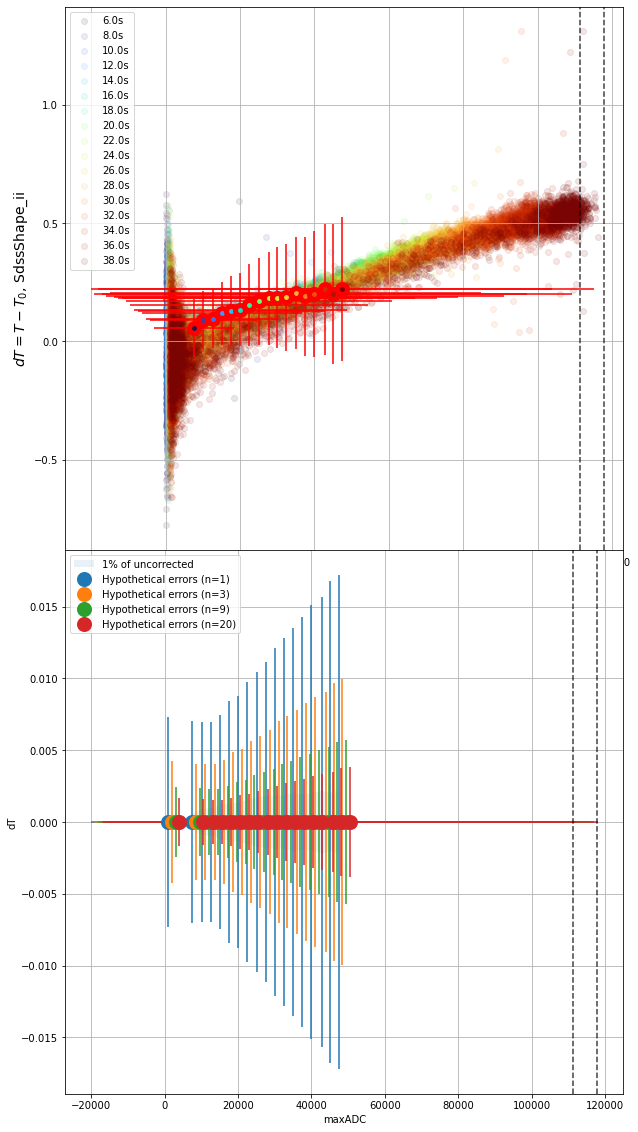

In [21]:
from astropy.stats import mad_std

class Aggregated:
    pass
    
table = tab_uncorr
refs = []
exptimes = np.unique(tab_corr['exptime'])
for t in exptimes:
    refs.append(tab_corr[np.where(tab_corr['exptime'] == t)][0])

y1key="base_SdssShape_xx"
y2key="base_SdssShape_yy"
xkey="maxADC"
#xkey="base_CircularApertureFlux_70_0_instFlux"
#zskey="base_CircularApertureFlux_3_0_instFlux"
zskey="base_PsfFlux_instFlux"
zlkey="base_CircularApertureFlux_70_0_instFlux"

fontsize=14
T0s = []


from functools import reduce
spots_to_track = reduce(np.intersect1d, tuple(i['spot_indices'] for i in table))
T0 = np.zeros(len(spots_to_track))
for i, spot in enumerate(spots_to_track):
    xs = []
    ys = []
    tmp = []
    for exp, tbl in enumerate(table.groups):
        #if np.mean(tbl['exptime']) > 16.:
        #continue
        for iterable in tbl:
            indx = np.argwhere(iterable['spot_indices'] == spot)[0][0]
            xs.append(iterable[xkey][indx])
            Y1=iterable[y1key][indx]
            Y2=iterable[y2key][indx]
            ys.append(Y1+Y2)
            ref = refs[np.argwhere(iterable['exptime'] == exptimes)[0][0]]
            Y0_1=ref[y1key][indx]
            Y0_2=ref[y2key][indx]
            tmp.append(Y0_1+Y0_2)

    m, b = np.polyfit(xs, ys, 1)
    T0[i] = b
    T0s.append(np.asarray(tmp))


x = []
y = []
IxxErrs = []
IyyErrs = []
IxyErrs = []
ixx = []
iyy = []
zl = []
zs = []
e = []
exps = []
for iterable in table:
    index = np.argwhere(exptimes==iterable['exptime'])[0][0]
    ref = refs[0]
    spots, iter_ind, ref_ind = np.intersect1d(iterable['spot_indices'], spots_to_track, return_indices=True)
        
    x.extend(iterable[xkey][iter_ind])
    Y1=iterable[y1key][iter_ind]
    Y2=iterable[y2key][iter_ind]
    Y0_1=ref[y1key][ref_ind]
    Y0_2=ref[y2key][ref_ind] 
    
    IxxErrs.extend(iterable["base_SdssShape_xxErr"][ref_ind])
    IyyErrs.extend(iterable["base_SdssShape_yyErr"][ref_ind])
    IxyErrs.extend(iterable["base_SdssShape_xyErr"][ref_ind])
    ixx.extend(iterable["base_SdssShape_xx"][ref_ind])
    iyy.extend(iterable["base_SdssShape_yy"][ref_ind])

    t_0 = T0[ref_ind]
    zl.extend(iterable[zlkey][iter_ind]/ref[zlkey][ref_ind])
    zs.extend(iterable[zskey][iter_ind]/ref[zskey][ref_ind])
#    y.extend( (Y1+Y2-(Y0_1+Y0_2)) / (Y0_1+Y0_2))
    y.extend( (Y1+Y2) - t_0) #- (Y0_1+Y0_2)) #
    e.extend([iterable['exptime']]*len(Y1))

x=np.array(x)
y=np.array(y)
IxxErrs = np.array(IxxErrs)
IyyErrs = np.array(IyyErrs)
IxyErrs = np.array(IxyErrs)
ixx = np.array(ixx)
iyy = np.array(iyy)
zl=np.array(zl)
zs=np.array(zs)
#print(e[0], y[np.where((e==e[0])&(y!=0))].std())


n = len(set(e))-1


# Plot

fig = plt.figure(figsize=(10,20), facecolor='w')
ax = plt.subplot("211")

array_aggregated = []

xs_stderrs = []
ys = []
es = []
stderrs_linfitallflux = []
errofstderr_linfitallflux = []
xxErrs = []
yyErrs = []
xyErrs = []
ixxs = []
iyys = []
properrs = []

for j, i in enumerate(sorted(list(set(e)))):
    cond = np.argwhere((e==i)&(y!=0))
    sca=ax.scatter(x[cond],y[cond],color=plt.get_cmap('turbo')((j)/n),alpha=0.1, label=str(i)+'s')
    ax.legend()
    num = len(x[cond])
    from astropy.stats import bootstrap
    errofstderr_linfitallflux.append(bootstrap(y[cond], bootnum=100, bootfunc=np.std))
    
    aggregated = Aggregated()
    aggregated.e = np.median(i)    
    aggregated.x = np.median(x[cond])
    aggregated.y = np.median(y[cond])
    aggregated.xerr = mad_std(x[cond])
    aggregated.yerr = np.std(y[cond])
    
    xxErrs.append(np.median(IxxErrs[cond]))
    yyErrs.append(np.median(IyyErrs[cond]))
    xyErrs.append(np.median(IxyErrs[cond]))
    ixxs.append(np.median(ixx[cond]))
    iyys.append(np.median(iyy[cond]))
    properrs.append(np.sqrt(np.mean(  IxxErrs[cond]**2 + IyyErrs[cond]**2 + 2*IxyErrs[cond]**2 )))
    
    stderrs_linfitallflux.append(aggregated.yerr)
    xs_stderrs.append(aggregated.x)
    aggregated.num = num
    aggregated.color = plt.get_cmap('turbo')((j)/n)
    array_aggregated.append(aggregated)
    
    for spec in [1]:
        sca_3=ax.errorbar(aggregated.x,aggregated.y*spec,
                        xerr=aggregated.xerr,
                        yerr=aggregated.yerr,
                        fmt="o",color=aggregated.color,mec="r",ecolor="r",alpha=1,
                        ms=10,mew=5)

#ax.scatter(x2,y2,c="r", s=15)

"""for i in range(len(e2)):
    if (x2[i] >= 1e5) and (x2[i] <= 1e7) and (np.abs(y2[i]) <= 0.4):
        ax.text(x2[i],y2[i]+0.0075,str(e2[i]), c="red")"""
ax.set_ylabel("{}".format(r"$dT=T - T_0$, SdssShape_ii"),fontsize=fontsize)
#ax.set_xlim(50000,120000)
#plt.ylim(-0.5,1.)

ax.grid()
ax.legend()


bx = plt.subplot("212")

m, b = np.polyfit(xs_stderrs[0:2], stderrs_linfitallflux[0:2], 1)
critical_error = m*1000. + b
new = Aggregated()   
new.x = 1000.
new.y = 1000.
new.xerr = 0
new.yerr = critical_error
xi = np.array([ aggregated.x for aggregated in array_aggregated ])
yi = np.array([ aggregated.y*0.01 for aggregated in array_aggregated ])
m, b = np.polyfit(xi[0:2], yi[0:2], 1)
print(m,b)
critical_level = m*1000. + b
xi = np.insert(xi, 0, [1000.])
print(critical_level)
yi = np.insert(yi, 0, [critical_level])
bx.fill_between(xi, -yi, yi, alpha=0.1, label="1% of uncorrected" )
array_aggregated.insert(0,new)
for i, n in enumerate([1, 3, 9,20]):
    sca_2=bx.errorbar(
        [ aggregated.x+i*1000 for aggregated in array_aggregated ],
        [ aggregated.y*0.0 for aggregated in array_aggregated ],
        xerr=[ aggregated.xerr for aggregated in array_aggregated ],
        yerr=[ aggregated.yerr/np.sqrt(n*311) for aggregated in array_aggregated ],
        fmt="o",
        ms=10,mew=5,
        label="Hypothetical errors (n={})".format(n)
    )

bx.set_ylabel("dT")
bx.legend()
bx.grid()



# Plot the min and max ptc turnoffs for this sensor
#    from: https://github.com/lsst/obs_lsst/blob/master/policy/lsstCam/R10.yaml

for ch in [111273, 117803] :
    for axis in [ax, bx]:
        #axis.set_xlim(50000, 120000)
        axis.axvline(ch, c="k", ls="--", alpha=0.75)

        
#plt.colorbar(scb,label="EXPTIME",orientation="horizontal",location="bottom")

bx.set_xlabel("maxADC")
#cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
#plt.colorbar(sca,cax=cbar_ax,label="EXPTIME")

plt.subplots_adjust(right=0.90,hspace=0)
plt.savefig("./BF-9raft-e2v-error.png")

1st order y-intercept low flux (<16s)

<ipython-input-22-0dd89abbf1e7>:103: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot("211")
<ipython-input-22-0dd89abbf1e7>:167: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  bx = plt.subplot("212")


1.3099249451804747e-07 -0.0003016421890380125
-0.00017064969451996502


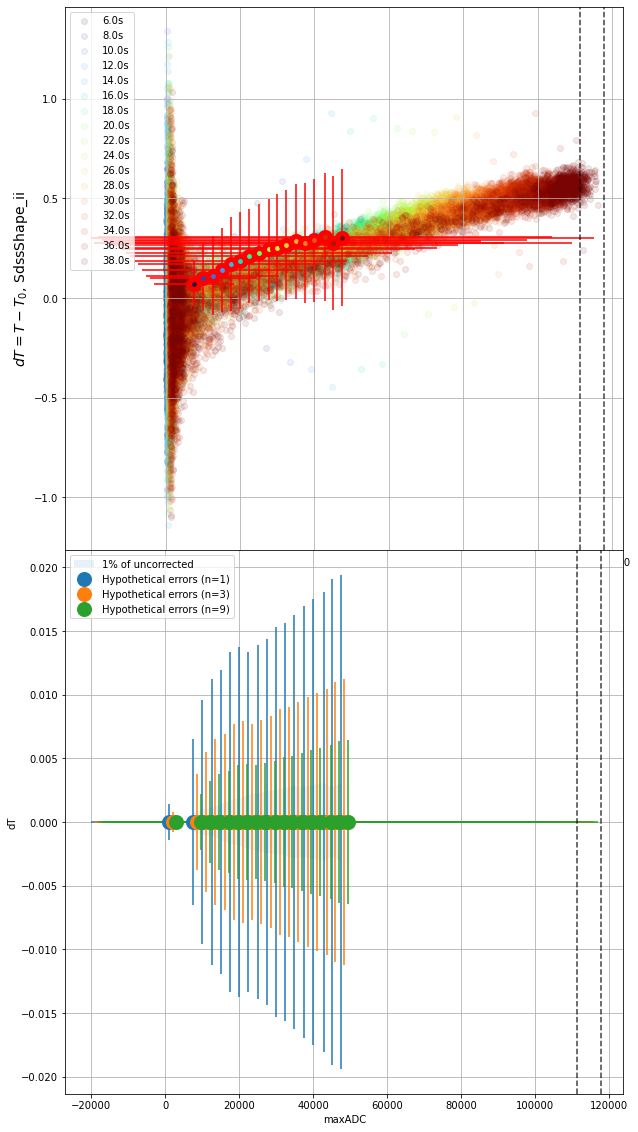

In [22]:
from astropy.stats import mad_std

class Aggregated:
    pass
    
table = tab_uncorr
refs = []
exptimes = np.unique(tab_corr['exptime'])
for t in exptimes:
    refs.append(tab_corr[np.where(tab_corr['exptime'] == t)][0])

y1key="base_SdssShape_xx"
y2key="base_SdssShape_yy"
xkey="maxADC"
#xkey="base_CircularApertureFlux_70_0_instFlux"
#zskey="base_CircularApertureFlux_3_0_instFlux"
zskey="base_PsfFlux_instFlux"
zlkey="base_CircularApertureFlux_70_0_instFlux"

fontsize=14
T0s = []


from functools import reduce
spots_to_track = reduce(np.intersect1d, tuple(i['spot_indices'] for i in table))
T0 = np.zeros(len(spots_to_track))
for i, spot in enumerate(spots_to_track):
    xs = []
    ys = []
    tmp = []
    for exp, tbl in enumerate(table.groups):
        if np.mean(tbl['exptime']) > 16.:
            continue
        for iterable in tbl:
            indx = np.argwhere(iterable['spot_indices'] == spot)[0][0]
            xs.append(iterable[xkey][indx])
            Y1=iterable[y1key][indx]
            Y2=iterable[y2key][indx]
            ys.append(Y1+Y2)
            ref = refs[np.argwhere(iterable['exptime'] == exptimes)[0][0]]
            Y0_1=ref[y1key][indx]
            Y0_2=ref[y2key][indx]
            tmp.append(Y0_1+Y0_2)

    m, b = np.polyfit(xs, ys, 1)
    T0[i] = b
    T0s.append(np.asarray(tmp))


x = []
y = []
IxxErrs = []
IyyErrs = []
IxyErrs = []
ixx = []
iyy = []
zl = []
zs = []
e = []
exps = []
for iterable in table:
    index = np.argwhere(exptimes==iterable['exptime'])[0][0]
    ref = refs[0]
    spots, iter_ind, ref_ind = np.intersect1d(iterable['spot_indices'], spots_to_track, return_indices=True)
        
    x.extend(iterable[xkey][iter_ind])
    Y1=iterable[y1key][iter_ind]
    Y2=iterable[y2key][iter_ind]
    Y0_1=ref[y1key][ref_ind]
    Y0_2=ref[y2key][ref_ind] 
    
    IxxErrs.extend(iterable["base_SdssShape_xxErr"][ref_ind])
    IyyErrs.extend(iterable["base_SdssShape_yyErr"][ref_ind])
    IxyErrs.extend(iterable["base_SdssShape_xyErr"][ref_ind])
    ixx.extend(iterable["base_SdssShape_xx"][ref_ind])
    iyy.extend(iterable["base_SdssShape_yy"][ref_ind])

    t_0 = T0[ref_ind]
    zl.extend(iterable[zlkey][iter_ind]/ref[zlkey][ref_ind])
    zs.extend(iterable[zskey][iter_ind]/ref[zskey][ref_ind])
#    y.extend( (Y1+Y2-(Y0_1+Y0_2)) / (Y0_1+Y0_2))
    y.extend( (Y1+Y2) - t_0) #- (Y0_1+Y0_2)) #
    e.extend([iterable['exptime']]*len(Y1))

x=np.array(x)
y=np.array(y)
IxxErrs = np.array(IxxErrs)
IyyErrs = np.array(IyyErrs)
IxyErrs = np.array(IxyErrs)
ixx = np.array(ixx)
iyy = np.array(iyy)
zl=np.array(zl)
zs=np.array(zs)
#print(e[0], y[np.where((e==e[0])&(y!=0))].std())


n = len(set(e))-1


# Plot

fig = plt.figure(figsize=(10,20), facecolor='w')
ax = plt.subplot("211")

array_aggregated = []

xs_stderrs = []
ys = []
es = []
stderrs_linfitlowflux16 = []
errofstderr_linfitlowflux16 = []
xxErrs = []
yyErrs = []
xyErrs = []
ixxs = []
iyys = []
properrs = []

for j, i in enumerate(sorted(list(set(e)))):
    cond = np.argwhere((e==i)&(y!=0))
    sca=ax.scatter(x[cond],y[cond],color=plt.get_cmap('turbo')((j)/n),alpha=0.1, label=str(i)+'s')
    ax.legend()
    num = len(x[cond])
    from astropy.stats import bootstrap
    errofstderr_linfitlowflux16.append(bootstrap(y[cond], bootnum=100, bootfunc=np.std))
    
    aggregated = Aggregated()
    aggregated.e = np.median(i)    
    aggregated.x = np.median(x[cond])
    aggregated.y = np.median(y[cond])
    aggregated.xerr = mad_std(x[cond])
    aggregated.yerr = np.std(y[cond])
    
    xxErrs.append(np.median(IxxErrs[cond]))
    yyErrs.append(np.median(IyyErrs[cond]))
    xyErrs.append(np.median(IxyErrs[cond]))
    ixxs.append(np.median(ixx[cond]))
    iyys.append(np.median(iyy[cond]))
    properrs.append(np.sqrt(np.mean(  IxxErrs[cond]**2 + IyyErrs[cond]**2 + 2*IxyErrs[cond]**2 )))
    
    stderrs_linfitlowflux16.append(aggregated.yerr)
    xs_stderrs.append(aggregated.x)
    aggregated.num = num
    aggregated.color = plt.get_cmap('turbo')((j)/n)
    array_aggregated.append(aggregated)
    
    for spec in [1]:
        sca_3=ax.errorbar(aggregated.x,aggregated.y*spec,
                        xerr=aggregated.xerr,
                        yerr=aggregated.yerr,
                        fmt="o",color=aggregated.color,mec="r",ecolor="r",alpha=1,
                        ms=10,mew=5)

#ax.scatter(x2,y2,c="r", s=15)

"""for i in range(len(e2)):
    if (x2[i] >= 1e5) and (x2[i] <= 1e7) and (np.abs(y2[i]) <= 0.4):
        ax.text(x2[i],y2[i]+0.0075,str(e2[i]), c="red")"""
ax.set_ylabel("{}".format(r"$dT=T - T_0$, SdssShape_ii"),fontsize=fontsize)
#ax.set_xlim(50000,120000)
#plt.ylim(-0.5,1.)

ax.grid()
ax.legend()


bx = plt.subplot("212")

m, b = np.polyfit(xs_stderrs[0:2], stderrs_linfitlowflux16[0:2], 1)
critical_error = m*1000. + b
new = Aggregated()   
new.x = 1000.
new.y = 1000.
new.xerr = 0
new.yerr = critical_error
xi = np.array([ aggregated.x for aggregated in array_aggregated ])
yi = np.array([ aggregated.y*0.01 for aggregated in array_aggregated ])
m, b = np.polyfit(xi[0:2], yi[0:2], 1)
print(m,b)
critical_level = m*1000. + b
np.insert(xi, 0, [1000.])
print(critical_level)
np.insert(yi, 0, [critical_level])
bx.fill_between(xi, -yi, yi, alpha=0.1, label="1% of uncorrected" )
array_aggregated.insert(0,new)

for i, n in enumerate([1, 3, 9]):
    sca_2=bx.errorbar(
        [ aggregated.x+i*1000 for aggregated in array_aggregated ],
        [ aggregated.y*0.0 for aggregated in array_aggregated ],
        xerr=[ aggregated.xerr for aggregated in array_aggregated ],
        yerr=[ aggregated.yerr/np.sqrt(n*311) for aggregated in array_aggregated ],
        fmt="o",
        ms=10,mew=5,
        label="Hypothetical errors (n={})".format(n)
    )

bx.set_ylabel("dT")
bx.legend()
bx.grid()



# Plot the min and max ptc turnoffs for this sensor
#    from: https://github.com/lsst/obs_lsst/blob/master/policy/lsstCam/R10.yaml

for ch in [111273, 117803] :
    for axis in [ax, bx]:
        #axis.set_xlim(50000, 120000)
        axis.axvline(ch, c="k", ls="--", alpha=0.75)

        
#plt.colorbar(scb,label="EXPTIME",orientation="horizontal",location="bottom")

bx.set_xlabel("maxADC")
#cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
#plt.colorbar(sca,cax=cbar_ax,label="EXPTIME")

plt.subplots_adjust(right=0.90,hspace=0)
plt.savefig("./BF-9raft-e2v-error.png")

<ipython-input-23-0167e50654eb>:103: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot("211")
<ipython-input-23-0167e50654eb>:167: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  bx = plt.subplot("212")


1.2247584311524384e-07 -0.00018323569971074322
-6.0759856595499385e-05


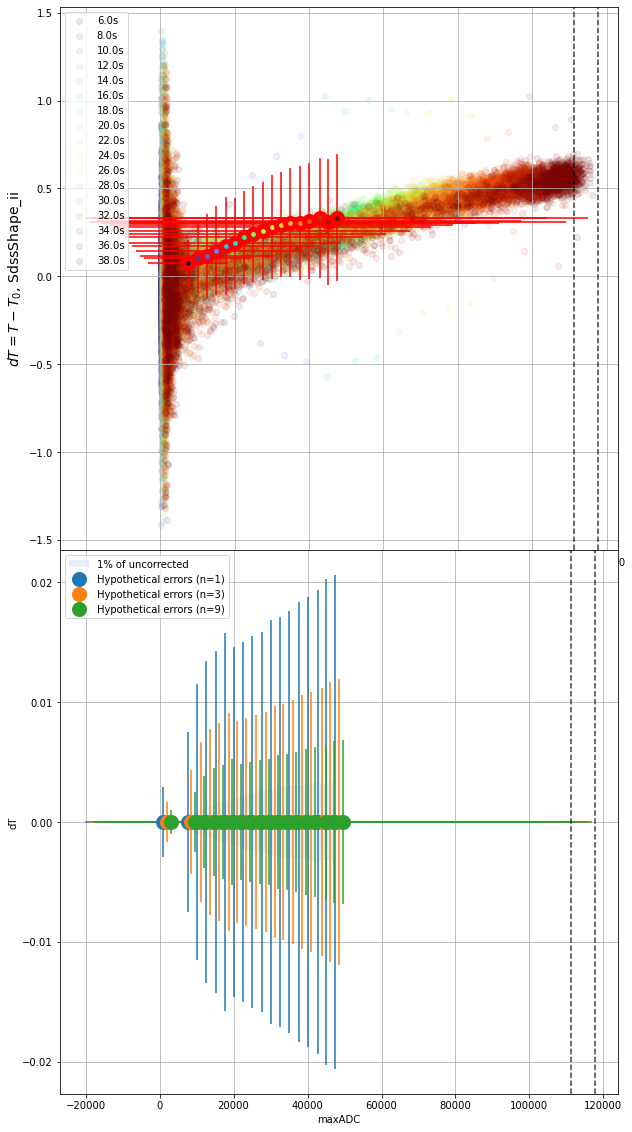

In [23]:
from astropy.stats import mad_std

class Aggregated:
    pass
    
table = tab_uncorr
refs = []
exptimes = np.unique(tab_corr['exptime'])
for t in exptimes:
    refs.append(tab_corr[np.where(tab_corr['exptime'] == t)][0])

y1key="base_SdssShape_xx"
y2key="base_SdssShape_yy"
xkey="maxADC"
#xkey="base_CircularApertureFlux_70_0_instFlux"
#zskey="base_CircularApertureFlux_3_0_instFlux"
zskey="base_PsfFlux_instFlux"
zlkey="base_CircularApertureFlux_70_0_instFlux"

fontsize=14
T0s = []


from functools import reduce
spots_to_track = reduce(np.intersect1d, tuple(i['spot_indices'] for i in table))
T0 = np.zeros(len(spots_to_track))
for i, spot in enumerate(spots_to_track):
    xs = []
    ys = []
    tmp = []
    for exp, tbl in enumerate(table.groups):
        if np.mean(tbl['exptime']) > 14.:
            continue
        for iterable in tbl:
            indx = np.argwhere(iterable['spot_indices'] == spot)[0][0]
            xs.append(iterable[xkey][indx])
            Y1=iterable[y1key][indx]
            Y2=iterable[y2key][indx]
            ys.append(Y1+Y2)
            ref = refs[np.argwhere(iterable['exptime'] == exptimes)[0][0]]
            Y0_1=ref[y1key][indx]
            Y0_2=ref[y2key][indx]
            tmp.append(Y0_1+Y0_2)

    m, b = np.polyfit(xs, ys, 1)
    T0[i] = b
    T0s.append(np.asarray(tmp))


x = []
y = []
IxxErrs = []
IyyErrs = []
IxyErrs = []
ixx = []
iyy = []
zl = []
zs = []
e = []
exps = []
for iterable in table:
    index = np.argwhere(exptimes==iterable['exptime'])[0][0]
    ref = refs[0]
    spots, iter_ind, ref_ind = np.intersect1d(iterable['spot_indices'], spots_to_track, return_indices=True)
        
    x.extend(iterable[xkey][iter_ind])
    Y1=iterable[y1key][iter_ind]
    Y2=iterable[y2key][iter_ind]
    Y0_1=ref[y1key][ref_ind]
    Y0_2=ref[y2key][ref_ind] 
    
    IxxErrs.extend(iterable["base_SdssShape_xxErr"][ref_ind])
    IyyErrs.extend(iterable["base_SdssShape_yyErr"][ref_ind])
    IxyErrs.extend(iterable["base_SdssShape_xyErr"][ref_ind])
    ixx.extend(iterable["base_SdssShape_xx"][ref_ind])
    iyy.extend(iterable["base_SdssShape_yy"][ref_ind])

    t_0 = T0[ref_ind]
    zl.extend(iterable[zlkey][iter_ind]/ref[zlkey][ref_ind])
    zs.extend(iterable[zskey][iter_ind]/ref[zskey][ref_ind])
#    y.extend( (Y1+Y2-(Y0_1+Y0_2)) / (Y0_1+Y0_2))
    y.extend( (Y1+Y2) - t_0) #- (Y0_1+Y0_2)) #
    e.extend([iterable['exptime']]*len(Y1))

x=np.array(x)
y=np.array(y)
IxxErrs = np.array(IxxErrs)
IyyErrs = np.array(IyyErrs)
IxyErrs = np.array(IxyErrs)
ixx = np.array(ixx)
iyy = np.array(iyy)
zl=np.array(zl)
zs=np.array(zs)
#print(e[0], y[np.where((e==e[0])&(y!=0))].std())


n = len(set(e))-1


# Plot

fig = plt.figure(figsize=(10,20), facecolor='w')
ax = plt.subplot("211")

array_aggregated = []

xs_stderrs = []
ys = []
es = []
stderrs_linfitlowflux14 = []
errofstderr_linfitlowflux14 = []
xxErrs = []
yyErrs = []
xyErrs = []
ixxs = []
iyys = []
properrs = []

for j, i in enumerate(sorted(list(set(e)))):
    cond = np.argwhere((e==i)&(y!=0))
    sca=ax.scatter(x[cond],y[cond],color=plt.get_cmap('turbo')((j)/n),alpha=0.1, label=str(i)+'s')
    ax.legend()
    num = len(x[cond])
    from astropy.stats import bootstrap
    errofstderr_linfitlowflux14.append(bootstrap(y[cond], bootnum=100, bootfunc=np.std))
    
    aggregated = Aggregated()
    aggregated.e = np.median(i)    
    aggregated.x = np.median(x[cond])
    aggregated.y = np.median(y[cond])
    aggregated.xerr = mad_std(x[cond])
    aggregated.yerr = np.std(y[cond])
    
    xxErrs.append(np.median(IxxErrs[cond]))
    yyErrs.append(np.median(IyyErrs[cond]))
    xyErrs.append(np.median(IxyErrs[cond]))
    ixxs.append(np.median(ixx[cond]))
    iyys.append(np.median(iyy[cond]))
    properrs.append(np.sqrt(np.mean(  IxxErrs[cond]**2 + IyyErrs[cond]**2 + 2*IxyErrs[cond]**2 )))
    
    stderrs_linfitlowflux14.append(aggregated.yerr)
    xs_stderrs.append(aggregated.x)
    aggregated.num = num
    aggregated.color = plt.get_cmap('turbo')((j)/n)
    array_aggregated.append(aggregated)
    
    for spec in [1]:
        sca_3=ax.errorbar(aggregated.x,aggregated.y*spec,
                        xerr=aggregated.xerr,
                        yerr=aggregated.yerr,
                        fmt="o",color=aggregated.color,mec="r",ecolor="r",alpha=1,
                        ms=10,mew=5)

#ax.scatter(x2,y2,c="r", s=15)

"""for i in range(len(e2)):
    if (x2[i] >= 1e5) and (x2[i] <= 1e7) and (np.abs(y2[i]) <= 0.4):
        ax.text(x2[i],y2[i]+0.0075,str(e2[i]), c="red")"""
ax.set_ylabel("{}".format(r"$dT=T - T_0$, SdssShape_ii"),fontsize=fontsize)
#ax.set_xlim(50000,120000)
#plt.ylim(-0.5,1.)

ax.grid()
ax.legend()


bx = plt.subplot("212")

m, b = np.polyfit(xs_stderrs[0:2], stderrs_linfitlowflux14[0:2], 1)
critical_error = m*1000. + b
new = Aggregated()   
new.x = 1000.
new.y = 1000.
new.xerr = 0
new.yerr = critical_error
xi = np.array([ aggregated.x for aggregated in array_aggregated ])
yi = np.array([ aggregated.y*0.01 for aggregated in array_aggregated ])
m, b = np.polyfit(xi[0:2], yi[0:2], 1)
print(m,b)
critical_level = m*1000. + b
np.insert(xi, 0, [1000.])
print(critical_level)
np.insert(yi, 0, [critical_level])
bx.fill_between(xi, -yi, yi, alpha=0.1, label="1% of uncorrected" )
array_aggregated.insert(0,new)

for i, n in enumerate([1, 3, 9]):
    sca_2=bx.errorbar(
        [ aggregated.x+i*1000 for aggregated in array_aggregated ],
        [ aggregated.y*0.0 for aggregated in array_aggregated ],
        xerr=[ aggregated.xerr for aggregated in array_aggregated ],
        yerr=[ aggregated.yerr/np.sqrt(n*311) for aggregated in array_aggregated ],
        fmt="o",
        ms=10,mew=5,
        label="Hypothetical errors (n={})".format(n)
    )

bx.set_ylabel("dT")
bx.legend()
bx.grid()



# Plot the min and max ptc turnoffs for this sensor
#    from: https://github.com/lsst/obs_lsst/blob/master/policy/lsstCam/R10.yaml

for ch in [111273, 117803] :
    for axis in [ax, bx]:
        #axis.set_xlim(50000, 120000)
        axis.axvline(ch, c="k", ls="--", alpha=0.75)

        
#plt.colorbar(scb,label="EXPTIME",orientation="horizontal",location="bottom")

bx.set_xlabel("maxADC")
#cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
#plt.colorbar(sca,cax=cbar_ax,label="EXPTIME")

plt.subplots_adjust(right=0.90,hspace=0)
plt.savefig("./BF-9raft-e2v-error.png")

<ipython-input-24-60eec1849b0a>:103: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot("211")
<ipython-input-24-60eec1849b0a>:167: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  bx = plt.subplot("212")


1.3051040969707098e-07 -0.0003124297596756905
-0.00018191934997861952


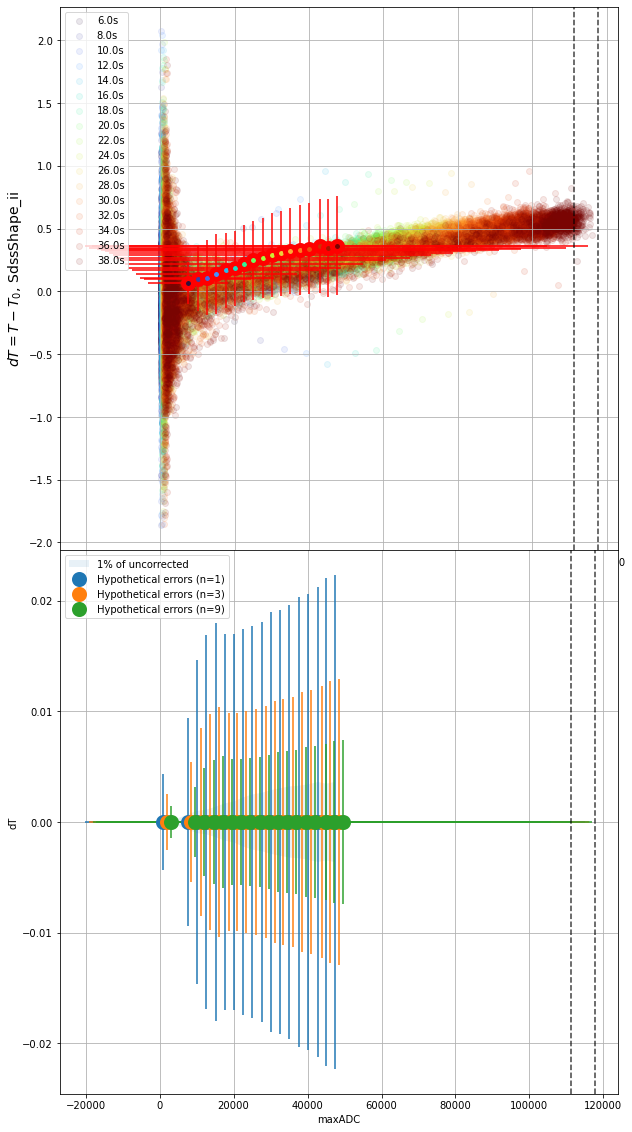

In [24]:
from astropy.stats import mad_std

class Aggregated:
    pass
    
table = tab_uncorr
refs = []
exptimes = np.unique(tab_corr['exptime'])
for t in exptimes:
    refs.append(tab_corr[np.where(tab_corr['exptime'] == t)][0])

y1key="base_SdssShape_xx"
y2key="base_SdssShape_yy"
xkey="maxADC"
#xkey="base_CircularApertureFlux_70_0_instFlux"
#zskey="base_CircularApertureFlux_3_0_instFlux"
zskey="base_PsfFlux_instFlux"
zlkey="base_CircularApertureFlux_70_0_instFlux"

fontsize=14
T0s = []


from functools import reduce
spots_to_track = reduce(np.intersect1d, tuple(i['spot_indices'] for i in table))
T0 = np.zeros(len(spots_to_track))
for i, spot in enumerate(spots_to_track):
    xs = []
    ys = []
    tmp = []
    for exp, tbl in enumerate(table.groups):
        if np.mean(tbl['exptime']) > 12.:
            continue
        for iterable in tbl:
            indx = np.argwhere(iterable['spot_indices'] == spot)[0][0]
            xs.append(iterable[xkey][indx])
            Y1=iterable[y1key][indx]
            Y2=iterable[y2key][indx]
            ys.append(Y1+Y2)
            ref = refs[np.argwhere(iterable['exptime'] == exptimes)[0][0]]
            Y0_1=ref[y1key][indx]
            Y0_2=ref[y2key][indx]
            tmp.append(Y0_1+Y0_2)

    m, b = np.polyfit(xs, ys, 1)
    T0[i] = b
    T0s.append(np.asarray(tmp))


x = []
y = []
IxxErrs = []
IyyErrs = []
IxyErrs = []
ixx = []
iyy = []
zl = []
zs = []
e = []
exps = []
for iterable in table:
    index = np.argwhere(exptimes==iterable['exptime'])[0][0]
    ref = refs[0]
    spots, iter_ind, ref_ind = np.intersect1d(iterable['spot_indices'], spots_to_track, return_indices=True)
        
    x.extend(iterable[xkey][iter_ind])
    Y1=iterable[y1key][iter_ind]
    Y2=iterable[y2key][iter_ind]
    Y0_1=ref[y1key][ref_ind]
    Y0_2=ref[y2key][ref_ind] 
    
    IxxErrs.extend(iterable["base_SdssShape_xxErr"][ref_ind])
    IyyErrs.extend(iterable["base_SdssShape_yyErr"][ref_ind])
    IxyErrs.extend(iterable["base_SdssShape_xyErr"][ref_ind])
    ixx.extend(iterable["base_SdssShape_xx"][ref_ind])
    iyy.extend(iterable["base_SdssShape_yy"][ref_ind])

    t_0 = T0[ref_ind]
    zl.extend(iterable[zlkey][iter_ind]/ref[zlkey][ref_ind])
    zs.extend(iterable[zskey][iter_ind]/ref[zskey][ref_ind])
#    y.extend( (Y1+Y2-(Y0_1+Y0_2)) / (Y0_1+Y0_2))
    y.extend( (Y1+Y2) - t_0) #- (Y0_1+Y0_2)) #
    e.extend([iterable['exptime']]*len(Y1))

x=np.array(x)
y=np.array(y)
IxxErrs = np.array(IxxErrs)
IyyErrs = np.array(IyyErrs)
IxyErrs = np.array(IxyErrs)
ixx = np.array(ixx)
iyy = np.array(iyy)
zl=np.array(zl)
zs=np.array(zs)
#print(e[0], y[np.where((e==e[0])&(y!=0))].std())


n = len(set(e))-1


# Plot

fig = plt.figure(figsize=(10,20), facecolor='w')
ax = plt.subplot("211")

array_aggregated = []

xs_stderrs = []
ys = []
es = []
stderrs_linfitlowflux12 = []
errofstderr_linfitlowflux12 = []
xxErrs = []
yyErrs = []
xyErrs = []
ixxs = []
iyys = []
properrs = []

for j, i in enumerate(sorted(list(set(e)))):
    cond = np.argwhere((e==i)&(y!=0))
    sca=ax.scatter(x[cond],y[cond],color=plt.get_cmap('turbo')((j)/n),alpha=0.1, label=str(i)+'s')
    ax.legend()
    num = len(x[cond])
    from astropy.stats import bootstrap
    errofstderr_linfitlowflux12.append(bootstrap(y[cond], bootnum=100, bootfunc=np.std))
    
    aggregated = Aggregated()
    aggregated.e = np.median(i)    
    aggregated.x = np.median(x[cond])
    aggregated.y = np.median(y[cond])
    aggregated.xerr = mad_std(x[cond])
    aggregated.yerr = np.std(y[cond])
    
    xxErrs.append(np.median(IxxErrs[cond]))
    yyErrs.append(np.median(IyyErrs[cond]))
    xyErrs.append(np.median(IxyErrs[cond]))
    ixxs.append(np.median(ixx[cond]))
    iyys.append(np.median(iyy[cond]))
    properrs.append(np.sqrt(np.mean(  IxxErrs[cond]**2 + IyyErrs[cond]**2 + 2*IxyErrs[cond]**2 )))
    
    stderrs_linfitlowflux12.append(aggregated.yerr)
    xs_stderrs.append(aggregated.x)
    aggregated.num = num
    aggregated.color = plt.get_cmap('turbo')((j)/n)
    array_aggregated.append(aggregated)
    
    for spec in [1]:
        sca_3=ax.errorbar(aggregated.x,aggregated.y*spec,
                        xerr=aggregated.xerr,
                        yerr=aggregated.yerr,
                        fmt="o",color=aggregated.color,mec="r",ecolor="r",alpha=1,
                        ms=10,mew=5)

#ax.scatter(x2,y2,c="r", s=15)

"""for i in range(len(e2)):
    if (x2[i] >= 1e5) and (x2[i] <= 1e7) and (np.abs(y2[i]) <= 0.4):
        ax.text(x2[i],y2[i]+0.0075,str(e2[i]), c="red")"""
ax.set_ylabel("{}".format(r"$dT=T - T_0$, SdssShape_ii"),fontsize=fontsize)
#ax.set_xlim(50000,120000)
#plt.ylim(-0.5,1.)

ax.grid()
ax.legend()


bx = plt.subplot("212")

m, b = np.polyfit(xs_stderrs[0:2], stderrs_linfitlowflux12[0:2], 1)
critical_error = m*1000. + b
new = Aggregated()   
new.x = 1000.
new.y = 1000.
new.xerr = 0
new.yerr = critical_error
xi = np.array([ aggregated.x for aggregated in array_aggregated ])
yi = np.array([ aggregated.y*0.01 for aggregated in array_aggregated ])
m, b = np.polyfit(xi[0:2], yi[0:2], 1)
print(m,b)
critical_level = m*1000. + b
xi = np.insert(xi, 0, [1000.])
print(critical_level)
yi = np.insert(yi, 0, [critical_level])
bx.fill_between(xi, -yi, yi, alpha=0.1, label="1% of uncorrected" )
array_aggregated.insert(0,new)

for i, n in enumerate([1, 3, 9]):
    sca_2=bx.errorbar(
        [ aggregated.x+i*1000 for aggregated in array_aggregated ],
        [ aggregated.y*0.0 for aggregated in array_aggregated ],
        xerr=[ aggregated.xerr for aggregated in array_aggregated ],
        yerr=[ aggregated.yerr/np.sqrt(n*311) for aggregated in array_aggregated ],
        fmt="o",
        ms=10,mew=5,
        label="Hypothetical errors (n={})".format(n)
    )

bx.set_ylabel("dT")
bx.legend()
bx.grid()



# Plot the min and max ptc turnoffs for this sensor
#    from: https://github.com/lsst/obs_lsst/blob/master/policy/lsstCam/R10.yaml

for ch in [111273, 117803] :
    for axis in [ax, bx]:
        #axis.set_xlim(50000, 120000)
        axis.axvline(ch, c="k", ls="--", alpha=0.75)

        
#plt.colorbar(scb,label="EXPTIME",orientation="horizontal",location="bottom")

bx.set_xlabel("maxADC")
#cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
#plt.colorbar(sca,cax=cbar_ax,label="EXPTIME")

plt.subplots_adjust(right=0.90,hspace=0)
plt.savefig("./BF-9raft-e2v-error.png")

<ipython-input-25-22632d57a26c>:103: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot("211")
<ipython-input-25-22632d57a26c>:167: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  bx = plt.subplot("212")


1.4434862872539618e-07 -0.0005090528928076825
-0.0003647042640822863
1 True
3 True
9 True


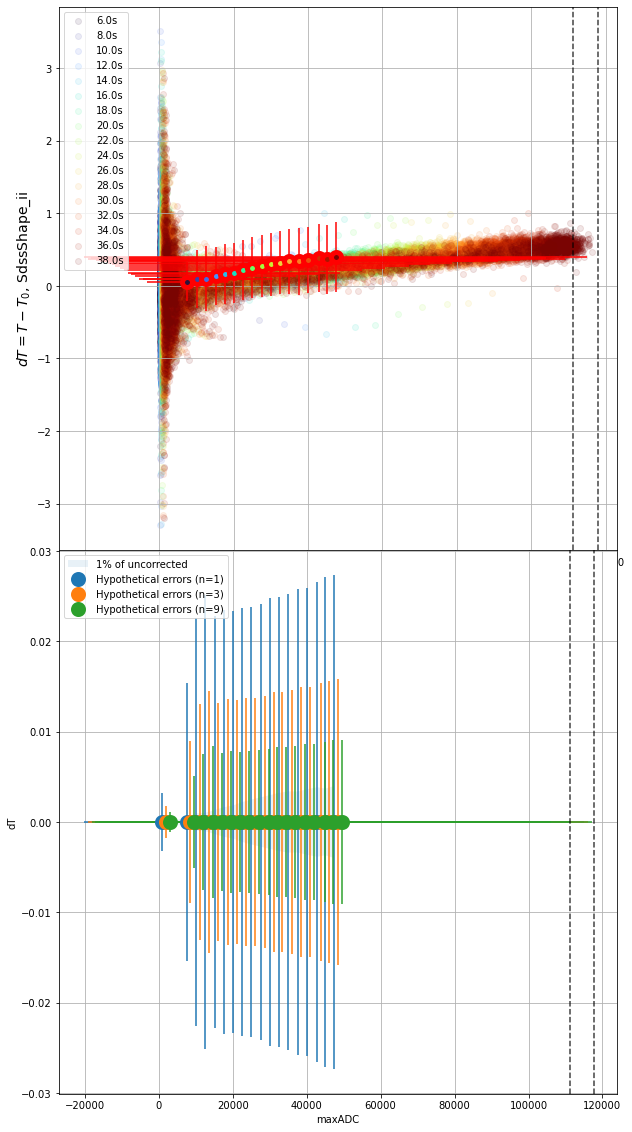

In [25]:
from astropy.stats import mad_std

class Aggregated:
    pass
    
table = tab_uncorr
refs = []
exptimes = np.unique(tab_corr['exptime'])
for t in exptimes:
    refs.append(tab_corr[np.where(tab_corr['exptime'] == t)][0])

y1key="base_SdssShape_xx"
y2key="base_SdssShape_yy"
xkey="maxADC"
#xkey="base_CircularApertureFlux_70_0_instFlux"
#zskey="base_CircularApertureFlux_3_0_instFlux"
zskey="base_PsfFlux_instFlux"
zlkey="base_CircularApertureFlux_70_0_instFlux"

fontsize=14
T0s = []


from functools import reduce
spots_to_track = reduce(np.intersect1d, tuple(i['spot_indices'] for i in table))
T0 = np.zeros(len(spots_to_track))
for i, spot in enumerate(spots_to_track):
    xs = []
    ys = []
    tmp = []
    for exp, tbl in enumerate(table.groups):
        if np.mean(tbl['exptime']) > 10.:
            continue
        for iterable in tbl:
            indx = np.argwhere(iterable['spot_indices'] == spot)[0][0]
            xs.append(iterable[xkey][indx])
            Y1=iterable[y1key][indx]
            Y2=iterable[y2key][indx]
            ys.append(Y1+Y2)
            ref = refs[np.argwhere(iterable['exptime'] == exptimes)[0][0]]
            Y0_1=ref[y1key][indx]
            Y0_2=ref[y2key][indx]
            tmp.append(Y0_1+Y0_2)

    m, b = np.polyfit(xs, ys, 1)
    T0[i] = b
    T0s.append(np.asarray(tmp))


x = []
y = []
IxxErrs = []
IyyErrs = []
IxyErrs = []
ixx = []
iyy = []
zl = []
zs = []
e = []
exps = []
for iterable in table:
    index = np.argwhere(exptimes==iterable['exptime'])[0][0]
    ref = refs[0]
    spots, iter_ind, ref_ind = np.intersect1d(iterable['spot_indices'], spots_to_track, return_indices=True)
        
    x.extend(iterable[xkey][iter_ind])
    Y1=iterable[y1key][iter_ind]
    Y2=iterable[y2key][iter_ind]
    Y0_1=ref[y1key][ref_ind]
    Y0_2=ref[y2key][ref_ind] 
    
    IxxErrs.extend(iterable["base_SdssShape_xxErr"][ref_ind])
    IyyErrs.extend(iterable["base_SdssShape_yyErr"][ref_ind])
    IxyErrs.extend(iterable["base_SdssShape_xyErr"][ref_ind])
    ixx.extend(iterable["base_SdssShape_xx"][ref_ind])
    iyy.extend(iterable["base_SdssShape_yy"][ref_ind])

    t_0 = T0[ref_ind]
    zl.extend(iterable[zlkey][iter_ind]/ref[zlkey][ref_ind])
    zs.extend(iterable[zskey][iter_ind]/ref[zskey][ref_ind])
#    y.extend( (Y1+Y2-(Y0_1+Y0_2)) / (Y0_1+Y0_2))
    y.extend( (Y1+Y2) - t_0) #- (Y0_1+Y0_2)) #
    e.extend([iterable['exptime']]*len(Y1))

x=np.array(x)
y=np.array(y)
IxxErrs = np.array(IxxErrs)
IyyErrs = np.array(IyyErrs)
IxyErrs = np.array(IxyErrs)
ixx = np.array(ixx)
iyy = np.array(iyy)
zl=np.array(zl)
zs=np.array(zs)
#print(e[0], y[np.where((e==e[0])&(y!=0))].std())


n = len(set(e))-1


# Plot

fig = plt.figure(figsize=(10,20), facecolor='w')
ax = plt.subplot("211")

array_aggregated = []

xs_stderrs = []
ys = []
es = []
stderrs_linfitlowflux10 = []
errofstderr_linfitlowflux10 = []
xxErrs = []
yyErrs = []
xyErrs = []
ixxs = []
iyys = []
properrs = []

for j, i in enumerate(sorted(list(set(e)))):
    cond = np.argwhere((e==i)&(y!=0))
    sca=ax.scatter(x[cond],y[cond],color=plt.get_cmap('turbo')((j)/n),alpha=0.1, label=str(i)+'s')
    ax.legend()
    num = len(x[cond])
    from astropy.stats import bootstrap
    errofstderr_linfitlowflux10.append(bootstrap(y[cond], bootnum=100, bootfunc=np.std))
    
    aggregated = Aggregated()
    aggregated.e = np.median(i)    
    aggregated.x = np.median(x[cond])
    aggregated.y = np.median(y[cond])
    aggregated.xerr = mad_std(x[cond])
    aggregated.yerr = np.std(y[cond])
    
    xxErrs.append(np.median(IxxErrs[cond]))
    yyErrs.append(np.median(IyyErrs[cond]))
    xyErrs.append(np.median(IxyErrs[cond]))
    ixxs.append(np.median(ixx[cond]))
    iyys.append(np.median(iyy[cond]))
    properrs.append(np.sqrt(np.mean(  IxxErrs[cond]**2 + IyyErrs[cond]**2 + 2*IxyErrs[cond]**2 )))
    
    stderrs_linfitlowflux10.append(aggregated.yerr)
    xs_stderrs.append(aggregated.x)
    aggregated.num = num
    aggregated.color = plt.get_cmap('turbo')((j)/n)
    array_aggregated.append(aggregated)
    
    for spec in [1]:
        sca_3=ax.errorbar(aggregated.x,aggregated.y*spec,
                        xerr=aggregated.xerr,
                        yerr=aggregated.yerr,
                        fmt="o",color=aggregated.color,mec="r",ecolor="r",alpha=1,
                        ms=10,mew=5)

#ax.scatter(x2,y2,c="r", s=15)

"""for i in range(len(e2)):
    if (x2[i] >= 1e5) and (x2[i] <= 1e7) and (np.abs(y2[i]) <= 0.4):
        ax.text(x2[i],y2[i]+0.0075,str(e2[i]), c="red")"""
ax.set_ylabel("{}".format(r"$dT=T - T_0$, SdssShape_ii"),fontsize=fontsize)
#ax.set_xlim(50000,120000)
#plt.ylim(-0.5,1.)

ax.grid()
ax.legend()


bx = plt.subplot("212")

m, b = np.polyfit(xs_stderrs[0:2], stderrs_linfitlowflux10[0:2], 1)
critical_error = m*1000. + b
new = Aggregated()   
new.x = 1000.
new.y = 1000.
new.xerr = 0
new.yerr = critical_error
xi = np.array([ aggregated.x for aggregated in array_aggregated ])
yi = np.array([ aggregated.y*0.01 for aggregated in array_aggregated ])
m, b = np.polyfit(xi[0:2], yi[0:2], 1)
print(m,b)
critical_level = m*1000. + b
xi = np.insert(xi, 0, 1000.)
print(critical_level)
yi = np.insert(yi, 0, critical_level)

bx.fill_between(xi, -yi, yi, alpha=0.1, label="1% of uncorrected" )
array_aggregated.insert(0,new)

for i, n in enumerate([1, 3, 9]):
    sca_2=bx.errorbar(
        [ aggregated.x+i*1000 for aggregated in array_aggregated ],
        [ aggregated.y*0.0 for aggregated in array_aggregated ],
        xerr=[ aggregated.xerr for aggregated in array_aggregated ],
        yerr=[ aggregated.yerr/np.sqrt(n*311) for aggregated in array_aggregated ],
        fmt="o",
        ms=10,mew=5,
        label="Hypothetical errors (n={})".format(n)
    )
    
for i, n in enumerate([1, 3, 9]):
    print(n, (array_aggregated[0].yerr/np.sqrt(n*311)) < critical_level)
    
bx.set_ylabel("dT")
bx.legend()
bx.grid()



# Plot the min and max ptc turnoffs for this sensor
#    from: https://github.com/lsst/obs_lsst/blob/master/policy/lsstCam/R10.yaml

for ch in [111273, 117803] :
    for axis in [ax, bx]:
        #axis.set_xlim(50000, 120000)
        axis.axvline(ch, c="k", ls="--", alpha=0.75)


#plt.colorbar(scb,label="EXPTIME",orientation="horizontal",location="bottom")

bx.set_xlabel("maxADC")
#cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
#plt.colorbar(sca,cax=cbar_ax,label="EXPTIME")

plt.subplots_adjust(right=0.90,hspace=0)
plt.savefig("./BF-9raft-e2v-error.png")

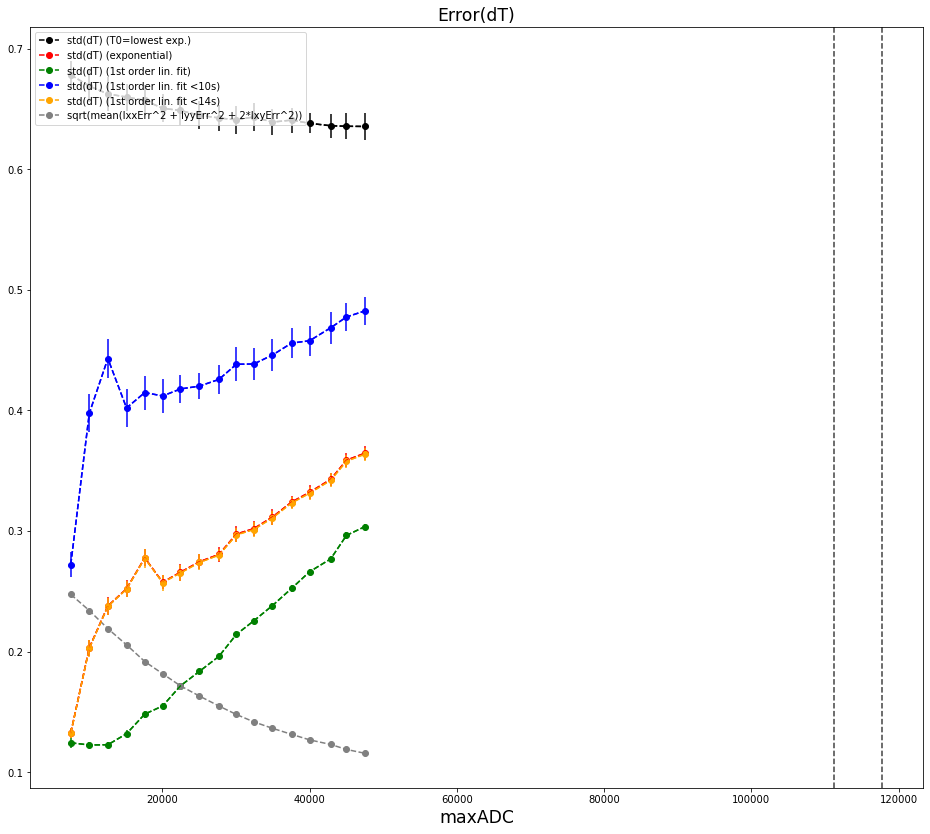

In [26]:
plt.figure(50,figsize=(16,14))
plt.title("Error(dT)", fontsize="xx-large")

plt.plot(xs_stderrs, stderrs_lowestexp, "o--", label="std(dT) (T0=lowest exp.)", color='black')
plt.errorbar(xs_stderrs, stderrs_lowestexp, yerr=[np.std(err) for err in errofstderr_lowestexp], color='black', linestyle='dashed')

plt.plot(xs_stderrs, stderrs_exp, "o--", label="std(dT) (exponential)", color='red')
plt.errorbar(xs_stderrs, stderrs_exp, yerr=[np.std(err) for err in errofstderr_exp], color='red', linestyle='dashed')

plt.plot(xs_stderrs, stderrs_linfitallflux, "o--", label="std(dT) (1st order lin. fit)", color='green')
plt.errorbar(xs_stderrs, stderrs_linfitallflux, yerr=[np.std(err) for err in errofstderr_linfitallflux], color='green', linestyle='dashed')

plt.plot(xs_stderrs, stderrs_linfitlowflux10, "o--", label="std(dT) (1st order lin. fit <10s)", color='blue')
plt.errorbar(xs_stderrs, stderrs_linfitlowflux10, yerr=[np.std(err) for err in errofstderr_linfitlowflux10], color='blue', linestyle='dashed')

#plt.plot(xs_stderrs, stderrs_linfitlowflux12, "o--", label="std(dT) (1st order lin. fit <12s)", color='green')
#plt.errorbar(xs_stderrs, stderrs_linfitlowflux12, yerr=[np.std(err) for err in errofstderr_linfitlowflux12], color='green', linestyle='dashed')

plt.plot(xs_stderrs, stderrs_linfitlowflux14, "o--", label="std(dT) (1st order lin. fit <14s)", color='orange')
plt.errorbar(xs_stderrs, stderrs_linfitlowflux14, yerr=[np.std(err) for err in errofstderr_linfitlowflux14], color='orange', linestyle='dashed')

#plt.plot(xs_stderrs, stderrs_linfitlowflux16, "o--", label="std(dT) (1st order lin. fit <16s)", color='purple')
#plt.errorbar(xs_stderrs, stderrs_linfitlowflux16, yerr=[np.std(err) for err in errofstderr_linfitlowflux16], color='purple', linestyle='dashed')


plt.plot(xs_stderrs,properrs, "o--", label="sqrt(mean(IxxErr^2 + IyyErr^2 + 2*IxyErr^2))", color="grey")

#plt.plot(xs_stderrs,xxErrs, "o--", label="IxxErr", color="red")
#plt.plot(xs_stderrs,yyErrs, "o--", label="IyyErr", color="black")
#plt.plot(xs_stderrs,xyErrs, "o--", label="IxyErr", color="grey")

for ch in [111273, 117803] :
        #plt.xlim(50000, 120000)
        plt.axvline(ch, c="k", ls="--", alpha=0.75)
        
#plt.ylim(0.006,0.03)
plt.ylabel("")
plt.xlabel("maxADC", fontsize="xx-large")
plt.legend(loc=2)
plt.savefig("./summary.png")

Text(0, 0.5, 'T(1st order y-intercept)')

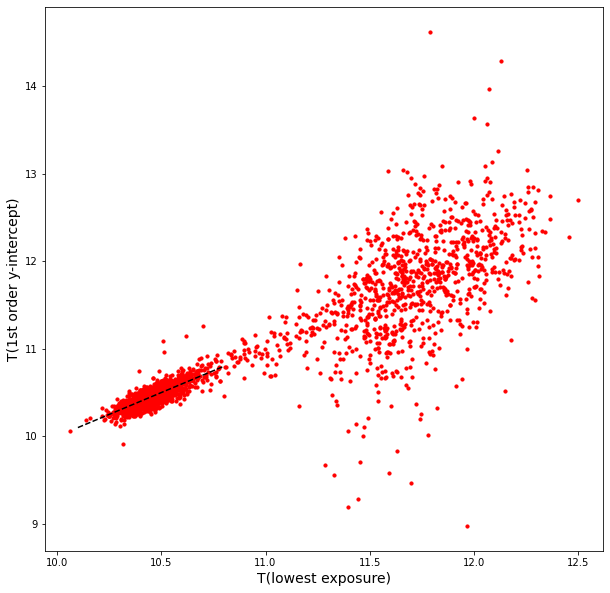

In [39]:
plt.figure(55, figsize=(10,10))
plt.scatter(np.mean(T0s, axis=-1), T0, color="r", s=10)
plt.plot([10.1,10.8], [10.1,10.8], "k--")
plt.xlabel("T(lowest exposure)", fontsize=14)
plt.ylabel("T(1st order y-intercept)", fontsize=14)

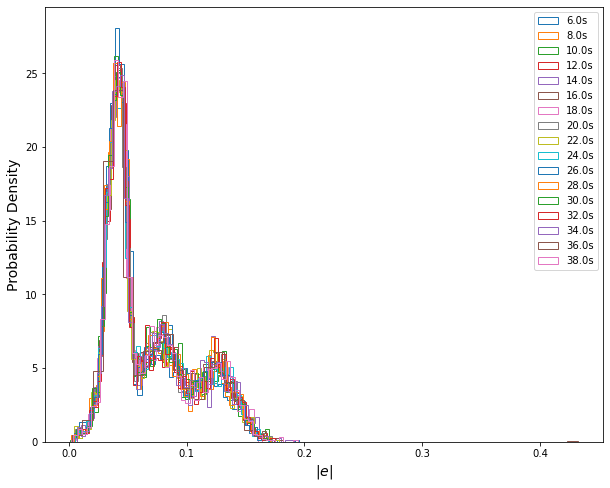

In [5]:
plt.figure(figsize=(10,8))
for tbl in tab_uncorr.groups:
    group = tbl[0]
    plt.hist((group['a'].flatten() - group['b'].flatten()) / group['a'].flatten(), bins=50,histtype='step', label=str(np.mean(group['exptime']))+"s", density=True)
plt.ylabel("Probability Density", fontsize=14)
plt.xlabel(r'$|e|$', fontsize=14)
plt.legend()
plt.savefig("./plots/e2v-R22_S11-9raft/polynomialfit/centerspots/ellipticities.png")

<ipython-input-6-1e5bf740c1f4>:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.array(x)
<ipython-input-6-1e5bf740c1f4>:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = np.array(y)
<ipython-input-6-1e5bf740c1f4>:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  flux = np.array(flux)
<ipython-input-6-1e5bf740c1f4>:60: Vi

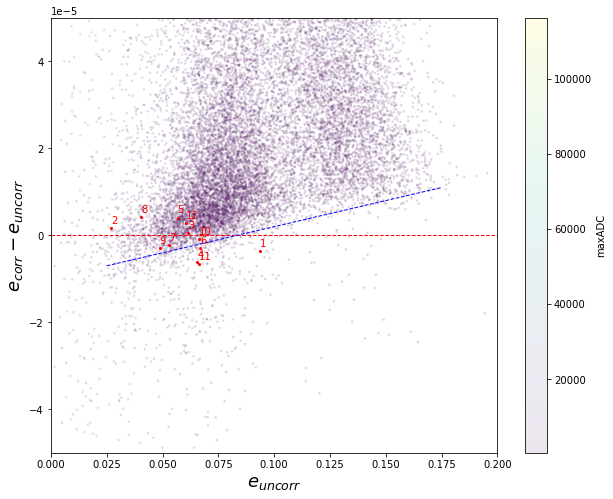

In [6]:
x = []
y = []
flux = []
exps = []

ptexps = []
ptx = []
pty = []
ptflux = []

for tc,tuc in zip(tab_corr, tab_uncorr):
    spots = np.intersect1d(tc['spot_indices'], tuc['spot_indices'])
    tmp_corrected = []
    tmp_uncorrected = []
    e_uncorrected = []
    e_corrected = []
    es = []
    exptime = np.mean(tc['exptime'])

    for pt in spots:
        if pt == 1:
            ptexps.append(exptime)
            ptflux.append(tuc['maxADC'][int(np.argwhere(tuc['spot_indices'] == pt))])


            a = tc["a"][int(np.argwhere(tc['spot_indices'] == pt))]
            b = tc["b"][int(np.argwhere(tc['spot_indices'] == pt))]
            ptx.append((a-b)/a)

            a = tuc["a"][int(np.argwhere(tuc['spot_indices'] == pt))]
            b = tuc["b"][int(np.argwhere(tuc['spot_indices'] == pt))]
            pty.append((a-b)/a)
            
        else:
            flux_corrected = tc['maxADC'][int(np.argwhere(tc['spot_indices'] == pt))]
            flux_uncorrected = tuc['maxADC'][int(np.argwhere(tuc['spot_indices'] == pt))]
            tmp_corrected.append(flux_corrected)
            tmp_uncorrected.append(flux_uncorrected)


            a = tc["a"][int(np.argwhere(tc['spot_indices'] == pt))]
            b = tc["b"][int(np.argwhere(tc['spot_indices'] == pt))]
            e_corrected.append((a-b)/a)

            a = tuc["a"][int(np.argwhere(tuc['spot_indices'] == pt))]
            b = tuc["b"][int(np.argwhere(tuc['spot_indices'] == pt))]
            e_uncorrected.append((a-b)/a)

            es.append(exptime)
    
    
    x.append(np.array(e_uncorrected))
    y.append(np.array(e_corrected))
    flux.append(np.array(tmp_uncorrected))
    exps.append(np.array(es))
    
x = np.array(x)
y = np.array(y)
flux = np.array(flux)
exps = np.array(exps)

plt.figure(90, figsize=(10,8))
for i,j,f in zip(x, y, flux):
    plt.scatter(i, j-i, s=3, c=f, alpha=0.1)
#plt.xlim(-5000,10000)
#plt.ylim(-0.5,0.5)
#for ch in [111273, 117803] :
        #plt.xlim(50000, 120000)
#        plt.axvline(ch, c="k", ls="--", alpha=0.75)
plt.plot(ptx,np.array(pty) - np.array(ptx),"ro",markersize=2)
for i,pt in enumerate(ptx):
    plt.text(ptx[i]+1e-6,pty[i] - ptx[i] + 1e-6, str(i+1), color="red")
    
plt.axhline(0.0, color="red", linestyle="dashed", linewidth=1)
plt.plot([0.025,0.175],[-0.000007,0.000011],"b--", linewidth=1)
plt.ylim(-0.00005,0.00005)
plt.xlim(0.,0.2)
plt.ylabel(r'$e_{corr}-e_{uncorr}$', fontsize=18)
plt.xlabel(r'$e_{uncorr}$', fontsize=18)
plt.colorbar(label="maxADC")


<ipython-input-49-4c2dd6f60d07>:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.array(x)
<ipython-input-49-4c2dd6f60d07>:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = np.array(y)
<ipython-input-49-4c2dd6f60d07>:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  flux = np.array(flux)
<ipython-input-49-4c2dd6f60d07>:60

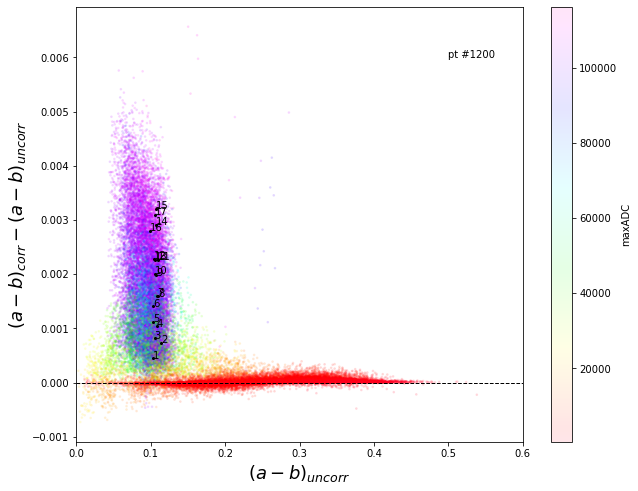

In [49]:
x = []
y = []
flux = []
exps = []

ptexps = []
ptx = []
pty = []
ptflux = []

for tc,tuc in zip(tab_corr, tab_uncorr):
    spots = np.intersect1d(tc['spot_indices'], tuc['spot_indices'])
    tmp_corrected = []
    tmp_uncorrected = []
    e_uncorrected = []
    e_corrected = []
    es = []
    exptime = np.mean(tc['exptime'])

    for pt in spots:
        if pt == 1200:
            ptexps.append(exptime)
            ptflux.append(tuc['maxADC'][int(np.argwhere(tuc['spot_indices'] == pt))])


            a = tuc["a"][int(np.argwhere(tc['spot_indices'] == pt))]
            b = tuc["b"][int(np.argwhere(tc['spot_indices'] == pt))]
            ptx.append(a-b)

            a = tc["a"][int(np.argwhere(tuc['spot_indices'] == pt))]
            b = tc["b"][int(np.argwhere(tuc['spot_indices'] == pt))]
            pty.append(a-b)
            
        else:
            flux_corrected = tc['maxADC'][int(np.argwhere(tc['spot_indices'] == pt))]
            flux_uncorrected = tuc['maxADC'][int(np.argwhere(tuc['spot_indices'] == pt))]
            tmp_corrected.append(flux_corrected)
            tmp_uncorrected.append(flux_uncorrected)


            a = tc["a"][int(np.argwhere(tc['spot_indices'] == pt))]
            b = tc["b"][int(np.argwhere(tc['spot_indices'] == pt))]
            e_corrected.append(np.abs(a-b))

            a = tuc["a"][int(np.argwhere(tuc['spot_indices'] == pt))]
            b = tuc["b"][int(np.argwhere(tuc['spot_indices'] == pt))]
            e_uncorrected.append(np.abs(a-b))

            es.append(exptime)
    
    
    x.append(np.array(e_uncorrected))
    y.append(np.array(e_corrected))
    flux.append(np.array(tmp_uncorrected))
    exps.append(np.array(es))
    
x = np.array(x)
y = np.array(y)
flux = np.array(flux)
exps = np.array(exps)

plt.figure(90, figsize=(10,8))
for i,j,f in zip(x, y, flux):
    plt.scatter(i, j-i, s=3, c=f, cmap='gist_rainbow',alpha=0.1)
    
#plt.xlim(-5000,10000)
#plt.ylim(-0.5,0.5)
#for ch in [111273, 117803] :
        #plt.xlim(50000, 120000)
#        plt.axvline(ch, c="k", ls="--", alpha=0.75)

plt.plot(ptx,np.array(pty) - np.array(ptx),"ko",markersize=2)
for i,pt in enumerate(ptx):
    plt.text(ptx[i]+1e-6,pty[i] - ptx[i] + 1e-6, str(i+1), color="black")
    
plt.text(0.5,0.006,"pt #1200")
plt.axhline(0.0, color="black", linestyle="dashed", linewidth=1)
"""plt.plot([0.025,0.175],[-0.000007,0.000011],"b--", linewidth=1)
plt.ylim(-0.00005,0.00005)"""
plt.xlim(0.,0.6)
plt.ylabel(r'$(a-b)_{corr}-(a-b)_{uncorr}$', fontsize=18)
plt.xlabel(r'$(a-b)_{uncorr}$', fontsize=18)
plt.colorbar(label="maxADC")


<ipython-input-83-9f0b03f0b101>:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.array(x)
<ipython-input-83-9f0b03f0b101>:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = np.array(y)
<ipython-input-83-9f0b03f0b101>:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  flux = np.array(flux)
<ipython-input-83-9f0b03f0b101>:60

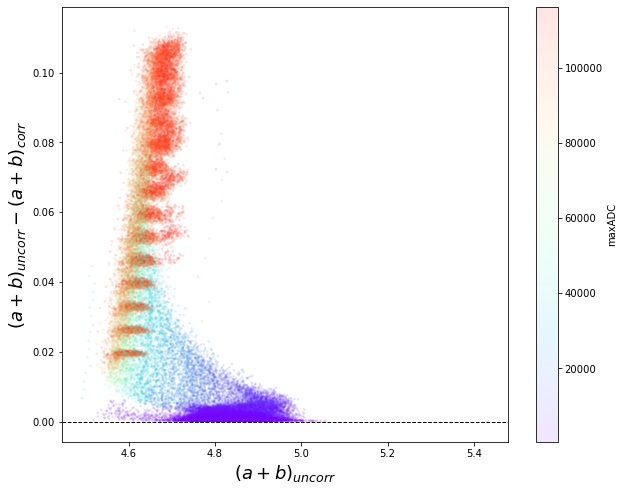

In [83]:
x = []
y = []
flux = []
exps = []

ptexps = []
ptx = []
pty = []
ptflux = []

for tc,tuc in zip(tab_corr, tab_uncorr):
    spots = np.intersect1d(tc['spot_indices'], tuc['spot_indices'])
    tmp_corrected = []
    tmp_uncorrected = []
    e_uncorrected = []
    e_corrected = []
    es = []
    exptime = np.mean(tc['exptime'])

    for pt in spots:
        if pt == 1200:
            ptexps.append(exptime)
            ptflux.append(tuc['maxADC'][int(np.argwhere(tuc['spot_indices'] == pt))])


            a = tuc["a"][int(np.argwhere(tc['spot_indices'] == pt))]
            b = tuc["b"][int(np.argwhere(tc['spot_indices'] == pt))]
            ptx.append(a+b)

            a = tc["a"][int(np.argwhere(tuc['spot_indices'] == pt))]
            b = tc["b"][int(np.argwhere(tuc['spot_indices'] == pt))]
            pty.append(a+b)
            
        else:
            flux_corrected = tc['maxADC'][int(np.argwhere(tc['spot_indices'] == pt))]
            flux_uncorrected = tuc['maxADC'][int(np.argwhere(tuc['spot_indices'] == pt))]
            tmp_corrected.append(flux_corrected)
            tmp_uncorrected.append(flux_uncorrected)


            a = tc["a"][int(np.argwhere(tc['spot_indices'] == pt))]
            b = tc["b"][int(np.argwhere(tc['spot_indices'] == pt))]
            e_corrected.append(np.abs(a+b))

            a = tuc["a"][int(np.argwhere(tuc['spot_indices'] == pt))]
            b = tuc["b"][int(np.argwhere(tuc['spot_indices'] == pt))]
            e_uncorrected.append(np.abs(a+b))

            es.append(exptime)
    
    
    x.append(np.array(e_uncorrected))
    y.append(np.array(e_corrected))
    flux.append(np.array(tmp_uncorrected))
    exps.append(np.array(es))
    
x = np.array(x)
y = np.array(y)
flux = np.array(flux)
exps = np.array(exps)

plt.figure(90, figsize=(10,8))
for i,j,f in zip(x, y, flux):
    plt.scatter(i, i-j, s=3, c=f, cmap='rainbow',alpha=0.1)
    
#plt.xlim(-5000,10000)
#plt.ylim(-0.5,0.5)
#for ch in [111273, 117803] :
        #plt.xlim(50000, 120000)
#        plt.axvline(ch, c="k", ls="--", alpha=0.75)


    

plt.axhline(0.0, color="black", linestyle="dashed", linewidth=1)
"""plt.plot([0.025,0.175],[-0.000007,0.000011],"b--", linewidth=1)
plt.ylim(-0.00005,0.00005)"""

plt.ylabel(r'$(a+b)_{uncorr}-(a+b)_{corr}$', fontsize=18)
plt.xlabel(r'$(a+b)_{uncorr}$', fontsize=18)
plt.colorbar(label="maxADC")


-0.003329813109741116


<ipython-input-120-bc34cda6af07>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.array(x)
<ipython-input-120-bc34cda6af07>:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = np.array(y)
<ipython-input-120-bc34cda6af07>:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  flux = np.array(flux)
<ipython-input-120-bc34cda6af07

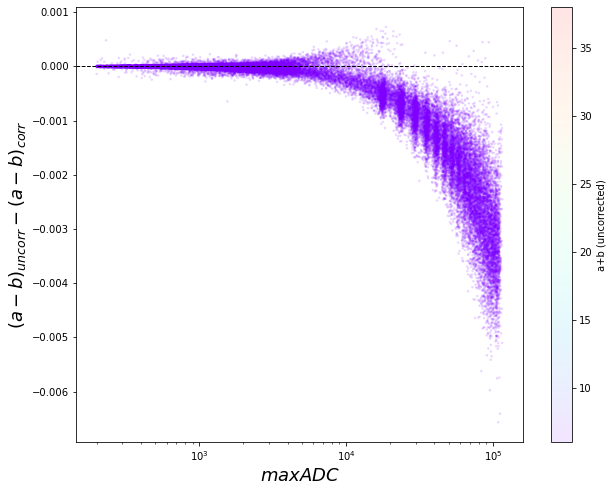

In [120]:
x = []
y = []
flux = []
exps = []

ptexps = []
ptx = []
pty = []
ptflux = []

for tc,tuc in zip(tab_corr, tab_uncorr):
    spots = np.intersect1d(tc['spot_indices'], tuc['spot_indices'])
    tmp_corrected = []
    tmp_uncorrected = []
    e_uncorrected = []
    e_corrected = []
    es = []
    exptime = np.mean(tc['exptime'])

    for pt in spots:
        flux_corrected = tc['maxADC'][int(np.argwhere(tc['spot_indices'] == pt))]
        flux_uncorrected = tuc['maxADC'][int(np.argwhere(tuc['spot_indices'] == pt))]
        tmp_corrected.append(flux_corrected)
        tmp_uncorrected.append(flux_uncorrected)


        a = tc["a"][int(np.argwhere(tc['spot_indices'] == pt))]
        b = tc["b"][int(np.argwhere(tc['spot_indices'] == pt))]
        e_corrected.append(a-b)

        a = tuc["a"][int(np.argwhere(tuc['spot_indices'] == pt))]
        b = tuc["b"][int(np.argwhere(tuc['spot_indices'] == pt))]
        e_uncorrected.append(a-b)

        es.append(exptime)
    
    
    x.append(np.array(e_uncorrected))
    y.append(np.array(e_corrected))
    flux.append(np.array(tmp_uncorrected))
    exps.append(np.array(es))
    
x = np.array(x)
y = np.array(y)
flux = np.array(flux)
exps = np.array(exps)


plt.figure(90, figsize=(10,8))
ms = []
for i,j,f,e in zip(x, y, flux, exps):
    m,b = np.polyfit(f,(i-j)/j,1)
    ms.append(m)
    plt.scatter(f, i-j, s=3, c=i, cmap='rainbow',alpha=0.1)
    plt.clim(6.,38.)
    #plt.ylim(4,6)
    plt.xscale('log')
    
#plt.xlim(-5000,10000)
#plt.ylim(-0.5,0.5)
#for ch in [111273, 117803] :
        #plt.xlim(50000, 120000)
#        plt.axvline(ch, c="k", ls="--", alpha=0.75)

print(np.mean(m)*10000)
    

plt.axhline(0.0, color="black", linestyle="dashed", linewidth=1)
"""plt.plot([0.025,0.175],[-0.000007,0.000011],"b--", linewidth=1)
plt.ylim(-0.00005,0.00005)"""

plt.ylabel(r'$(a-b)_{uncorr} - (a-b)_{corr}$', fontsize=18)
plt.xlabel(r'$maxADC$', fontsize=18)
plt.colorbar(label="a+b (uncorrected)")


<ipython-input-76-9600187d86f1>:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.array(x)
<ipython-input-76-9600187d86f1>:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = np.array(y)
<ipython-input-76-9600187d86f1>:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  flux = np.array(flux)
<ipython-input-76-9600187d86f1>:63

<Figure size 576x432 with 0 Axes>

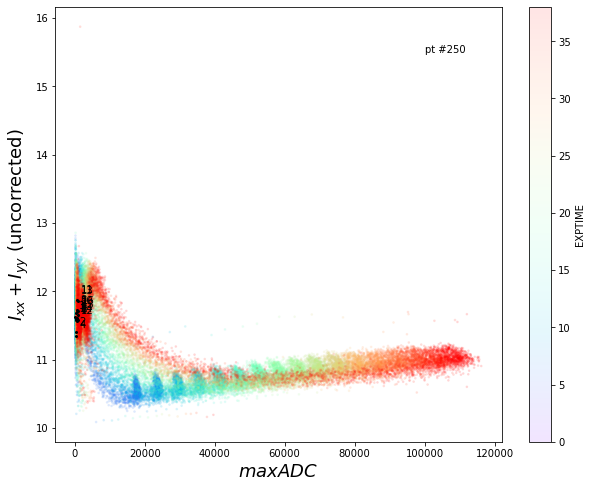

In [76]:
plt.figure(figsize=(8,6))


x = []
y = []
flux = []
exps = []

ptexps = []
ptx = []
pty = []
ptflux = []

for tc,tuc in zip(tab_corr, tab_uncorr):
    spots = np.intersect1d(tc['spot_indices'], tuc['spot_indices'])
    tmp_corrected = []
    tmp_uncorrected = []
    e_uncorrected = []
    e_corrected = []
    es = []
    exptime = np.mean(tc['exptime'])

    for pt in spots:
        if pt == 250:
            ptexps.append(exptime)
            ptflux.append(tuc['maxADC'][int(np.argwhere(tuc['spot_indices'] == pt))])


            Ixx = tuc["base_SdssShape_xx"][int(np.argwhere(tc['spot_indices'] == pt))]
            Iyy = tuc["base_SdssShape_yy"][int(np.argwhere(tc['spot_indices'] == pt))]
            ptx.append(Ixx+Iyy)

            Ixx = tc["base_SdssShape_xx"][int(np.argwhere(tc['spot_indices'] == pt))]
            Iyy = tc["base_SdssShape_yy"][int(np.argwhere(tc['spot_indices'] == pt))]
            pty.append(Ixx+Iyy)
            
        else:
            flux_corrected = tc['maxADC'][int(np.argwhere(tc['spot_indices'] == pt))]
            flux_uncorrected = tuc['maxADC'][int(np.argwhere(tuc['spot_indices'] == pt))]
            tmp_corrected.append(flux_corrected)
            tmp_uncorrected.append(flux_uncorrected)


            Ixx = tc["base_SdssShape_xx"][int(np.argwhere(tc['spot_indices'] == pt))]
            Iyy = tc["base_SdssShape_yy"][int(np.argwhere(tc['spot_indices'] == pt))]
            e_corrected.append(Ixx+Iyy)

            Ixx = tuc["base_SdssShape_xx"][int(np.argwhere(tc['spot_indices'] == pt))]
            Iyy = tuc["base_SdssShape_yy"][int(np.argwhere(tc['spot_indices'] == pt))]
            e_uncorrected.append(Ixx+Iyy)

            es.append(exptime)
    
    
    x.append(np.array(e_uncorrected))
    y.append(np.array(e_corrected))
    flux.append(np.array(tmp_uncorrected))
    exps.append(np.array(es))
    
x = np.array(x)
y = np.array(y)
flux = np.array(flux)
exps = np.array(exps)

plt.figure(figsize=(10,8))

def findminmax(arr):
    minval=0
    for i in arr:
        for j in i:
            if j < minval:
                minval = j
            else:
                continue
                
    maxval=0
    for i in arr:
        for j in i:
            if j > minval:
                maxval = j
            else:
                continue

    return minval, maxval

min_, max_ = findminmax(exps)

for i,j,f,e in zip(x, y, flux, exps):
    plt.scatter(f, i, s=3, c=e, cmap='rainbow',alpha=0.1)
    plt.clim(min_, max_)
    
plt.plot(ptflux,ptx,"ko",markersize=2)
for i,pt in enumerate(ptx):
    plt.text(ptflux[i]+1000, ptx[i]+0.11 + 1e-6, str(i+1), color="black")
    
plt.text(100000,15.5,"pt #250")

plt.ylabel(r'$I_{xx}+I_{yy}$ (uncorrected)', fontsize=18)
#plt.ylabel(r'$\Delta(I_{xx}+I_{yy})_{uncorr - corr}$', fontsize=18)
plt.xlabel(r'$maxADC$', fontsize=18)
plt.colorbar(label="EXPTIME")


<ipython-input-77-e760b9e3d33c>:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.array(x)
<ipython-input-77-e760b9e3d33c>:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = np.array(y)
<ipython-input-77-e760b9e3d33c>:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  flux = np.array(flux)
<ipython-input-77-e760b9e3d33c>:63

<Figure size 576x432 with 0 Axes>

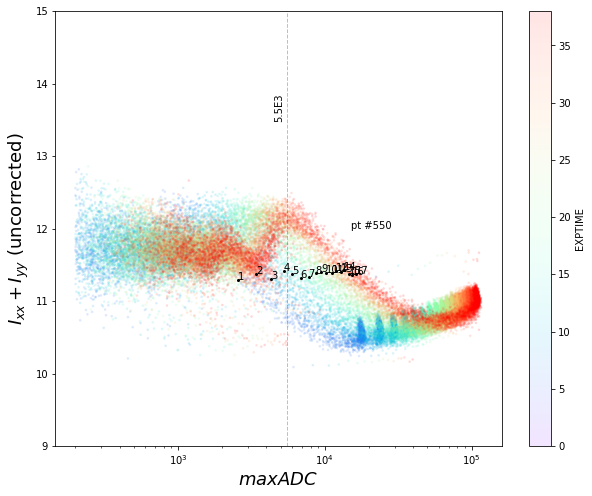

In [77]:
plt.figure(figsize=(8,6))


x = []
y = []
flux = []
exps = []

ptexps = []
ptx = []
pty = []
ptflux = []

for tc,tuc in zip(tab_corr, tab_uncorr):
    spots = np.intersect1d(tc['spot_indices'], tuc['spot_indices'])
    tmp_corrected = []
    tmp_uncorrected = []
    e_uncorrected = []
    e_corrected = []
    es = []
    exptime = np.mean(tc['exptime'])

    for pt in spots:
        if pt == 550:
            ptexps.append(exptime)
            ptflux.append(tuc['maxADC'][int(np.argwhere(tuc['spot_indices'] == pt))])


            Ixx = tuc["base_SdssShape_xx"][int(np.argwhere(tc['spot_indices'] == pt))]
            Iyy = tuc["base_SdssShape_yy"][int(np.argwhere(tc['spot_indices'] == pt))]
            ptx.append(Ixx+Iyy)

            Ixx = tc["base_SdssShape_xx"][int(np.argwhere(tc['spot_indices'] == pt))]
            Iyy = tc["base_SdssShape_yy"][int(np.argwhere(tc['spot_indices'] == pt))]
            pty.append(Ixx+Iyy)
            
        else:
            flux_corrected = tc['maxADC'][int(np.argwhere(tc['spot_indices'] == pt))]
            flux_uncorrected = tuc['maxADC'][int(np.argwhere(tuc['spot_indices'] == pt))]
            tmp_corrected.append(flux_corrected)
            tmp_uncorrected.append(flux_uncorrected)


            Ixx = tc["base_SdssShape_xx"][int(np.argwhere(tc['spot_indices'] == pt))]
            Iyy = tc["base_SdssShape_yy"][int(np.argwhere(tc['spot_indices'] == pt))]
            e_corrected.append(Ixx+Iyy)

            Ixx = tuc["base_SdssShape_xx"][int(np.argwhere(tc['spot_indices'] == pt))]
            Iyy = tuc["base_SdssShape_yy"][int(np.argwhere(tc['spot_indices'] == pt))]
            e_uncorrected.append(Ixx+Iyy)

            es.append(exptime)
    
    
    x.append(np.array(e_uncorrected))
    y.append(np.array(e_corrected))
    flux.append(np.array(tmp_uncorrected))
    exps.append(np.array(es))
    
x = np.array(x)
y = np.array(y)
flux = np.array(flux)
exps = np.array(exps)

fig = plt.figure(figsize=(10,8))

def findminmax(arr):
    minval=0
    for i in arr:
        for j in i:
            if j < minval:
                minval = j
            else:
                continue
                
    maxval=0
    for i in arr:
        for j in i:
            if j > minval:
                maxval = j
            else:
                continue

    return minval, maxval

min_, max_ = findminmax(exps)

for i,j,f,e in zip(x, y, flux, exps):
    plt.scatter(f, i, s=3, c=e, cmap='rainbow',alpha=0.1)
    plt.clim(min_, max_)
    plt.ylim(9,15)
    plt.xscale('log')
    
plt.plot(ptflux,ptx,"ko",markersize=2)

for i,pt in enumerate(ptx):
    plt.text(ptflux[i], ptx[i], str(i+1), color="black")
    
plt.text(1.5E4,12,"pt #550")

plt.axvline(5.5E3,linestyle="dashed",linewidth=1, color="black", alpha=0.25)
plt.text(4.5E3,13.5,"5.5E3",rotation='vertical')

plt.ylabel(r'$I_{xx}+I_{yy}$ (uncorrected)', fontsize=18)
#plt.ylabel(r'$\Delta(I_{xx}+I_{yy})_{uncorr - corr}$', fontsize=18)
plt.xlabel(r'$maxADC$', fontsize=18)
cbar = plt.colorbar(label="EXPTIME")


<ipython-input-79-fd016417facf>:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.array(x)
<ipython-input-79-fd016417facf>:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = np.array(y)
<ipython-input-79-fd016417facf>:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  flux = np.array(flux)
<ipython-input-79-fd016417facf>:63

<Figure size 576x432 with 0 Axes>

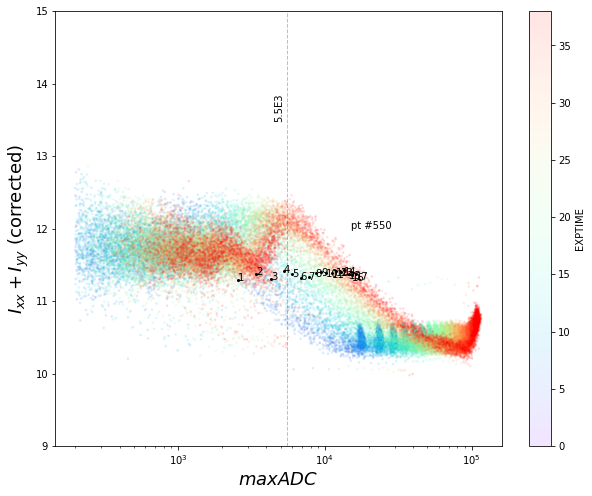

In [79]:
plt.figure(figsize=(8,6))


x = []
y = []
flux = []
exps = []

ptexps = []
ptx = []
pty = []
ptflux = []

for tc,tuc in zip(tab_corr, tab_uncorr):
    spots = np.intersect1d(tc['spot_indices'], tuc['spot_indices'])
    tmp_corrected = []
    tmp_uncorrected = []
    e_uncorrected = []
    e_corrected = []
    es = []
    exptime = np.mean(tc['exptime'])

    for pt in spots:
        if pt == 550:
            ptexps.append(exptime)
            ptflux.append(tuc['maxADC'][int(np.argwhere(tuc['spot_indices'] == pt))])


            Ixx = tuc["base_SdssShape_xx"][int(np.argwhere(tc['spot_indices'] == pt))]
            Iyy = tuc["base_SdssShape_yy"][int(np.argwhere(tc['spot_indices'] == pt))]
            ptx.append(Ixx+Iyy)

            Ixx = tc["base_SdssShape_xx"][int(np.argwhere(tc['spot_indices'] == pt))]
            Iyy = tc["base_SdssShape_yy"][int(np.argwhere(tc['spot_indices'] == pt))]
            pty.append(Ixx+Iyy)
            
        else:
            flux_corrected = tc['maxADC'][int(np.argwhere(tc['spot_indices'] == pt))]
            flux_uncorrected = tuc['maxADC'][int(np.argwhere(tuc['spot_indices'] == pt))]
            tmp_corrected.append(flux_corrected)
            tmp_uncorrected.append(flux_uncorrected)


            Ixx = tc["base_SdssShape_xx"][int(np.argwhere(tc['spot_indices'] == pt))]
            Iyy = tc["base_SdssShape_yy"][int(np.argwhere(tc['spot_indices'] == pt))]
            e_corrected.append(Ixx+Iyy)

            Ixx = tuc["base_SdssShape_xx"][int(np.argwhere(tc['spot_indices'] == pt))]
            Iyy = tuc["base_SdssShape_yy"][int(np.argwhere(tc['spot_indices'] == pt))]
            e_uncorrected.append(Ixx+Iyy)

            es.append(exptime)
    
    
    x.append(np.array(e_uncorrected))
    y.append(np.array(e_corrected))
    flux.append(np.array(tmp_uncorrected))
    exps.append(np.array(es))
    
x = np.array(x)
y = np.array(y)
flux = np.array(flux)
exps = np.array(exps)

fig = plt.figure(figsize=(10,8))

def findminmax(arr):
    minval=0
    for i in arr:
        for j in i:
            if j < minval:
                minval = j
            else:
                continue
                
    maxval=0
    for i in arr:
        for j in i:
            if j > minval:
                maxval = j
            else:
                continue

    return minval, maxval

min_, max_ = findminmax(exps)

for i,j,f,e in zip(x, y, flux, exps):
    plt.scatter(f, j, s=3, c=e, cmap='rainbow',alpha=0.1)
    plt.clim(min_, max_)
    plt.ylim(9,15)
    plt.xscale('log')
    
plt.plot(ptflux,ptx,"ko",markersize=2)

for i,pt in enumerate(ptx):
    plt.text(ptflux[i], pty[i], str(i+1), color="black")
    
plt.text(1.5E4,12,"pt #550")

plt.axvline(5.5E3,linestyle="dashed",linewidth=1, color="black", alpha=0.25)
plt.text(4.5E3,13.5,"5.5E3",rotation='vertical')

plt.ylabel(r'$I_{xx}+I_{yy}$ (corrected)', fontsize=18)
#plt.ylabel(r'$\Delta(I_{xx}+I_{yy})_{uncorr - corr}$', fontsize=18)
plt.xlabel(r'$maxADC$', fontsize=18)
cbar = plt.colorbar(label="EXPTIME")


In [51]:
for t in np.unique(tab_uncorr['exptime']):
    print(str(t)+'s,', len(np.argwhere(tab_uncorr['exptime']==t)), "images")
    

6.0s, 1 images
8.0s, 1 images
10.0s, 1 images
12.0s, 1 images
14.0s, 1 images
16.0s, 1 images
18.0s, 1 images
20.0s, 1 images
22.0s, 1 images
24.0s, 1 images
26.0s, 1 images
28.0s, 1 images
30.0s, 1 images
32.0s, 1 images
34.0s, 1 images
36.0s, 1 images
38.0s, 1 images
